**Chapter 18 – Reinforcement Learning**

_This notebook contains all the sample code in chapter 18_.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
    print("GPU was detected. Training will be faster.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

GPU was detected. Training will be faster.


# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [2]:
import gym

Let's list all the available environments:

In [3]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Using TF-Agents to Beat Breakout

Let's use TF-Agents to create an agent that will learn to play Breakout. We will use the Deep Q-Learning algorithm, so you can easily compare the components with the previous implementation, but TF-Agents implements many other (and more sophisticated) algorithms!

## TF-Agents Environments

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [6]:
env.gym

In [7]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [8]:
env.step(1) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

Saving figure breakout_plot


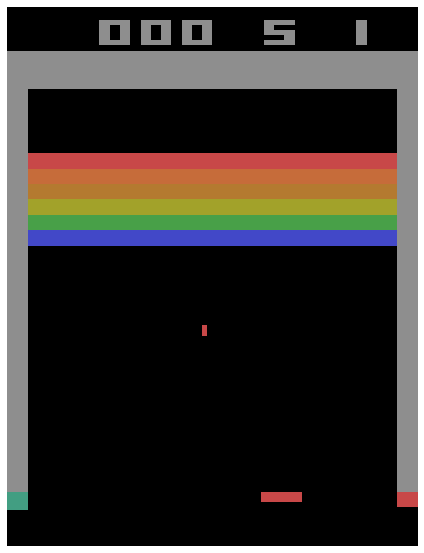

In [9]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [10]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## Environment Specifications

In [11]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [12]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [13]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

## Environment Wrappers

You can wrap a TF-Agents environments in a TF-Agents wrapper:

In [14]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [15]:
repeating_env.unwrapped

Here is the list of available wrappers:

In [16]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapper that accumulates run statistics as the environment iterates.
TimeLimit      

The `suite_gym.load()` function can create an env and wrap it for you, both with TF-Agents environment wrappers and Gym environment wrappers (the latter are applied first).

In [17]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [18]:
limited_repeating_env

Create an Atari Breakout environment, and wrap it to apply the default Atari preprocessing steps:

In [19]:
limited_repeating_env.unwrapped

In [20]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [21]:
env

Play a few steps just to see what happens:

In [22]:
env.seed(42)
env.reset()
time_step = env.step(1) # FIRE
for _ in range(4):
    time_step = env.step(3) # LEFT

In [23]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


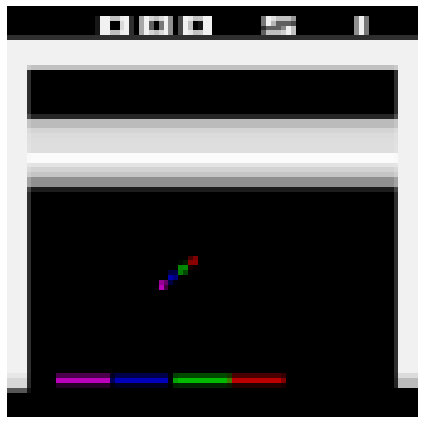

In [24]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

Convert the Python environment to a TF environment:

In [25]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## Creating the DQN

Create a small class to normalize the observations. Images are stored using bytes from 0 to 255 to use less RAM, but we want to pass floats from 0.0 to 1.0 to the neural network:

Create the Q-Network:

In [26]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

Create the DQN Agent:

In [27]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# see TF-agents issue #113
#optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
#                                     epsilon=0.00001, centered=True)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

Create the replay buffer:

In [28]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

Create a simple custom observer that counts and displays the number of times it is called (except when it is passed a trajectory that represents the boundary between two episodes, as this does not count as a step):

In [29]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

Let's add some training metrics:

In [30]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [31]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [32]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


Create the collect driver:

In [33]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

Collect the initial experiences, before training:

In [34]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

Let's sample 2 sub-episodes, with 3 time steps each and display them:

In [35]:
tf.random.set_seed(888) # chosen to show an example of trajectory at the end of an episode

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

In [36]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [37]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [38]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [39]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


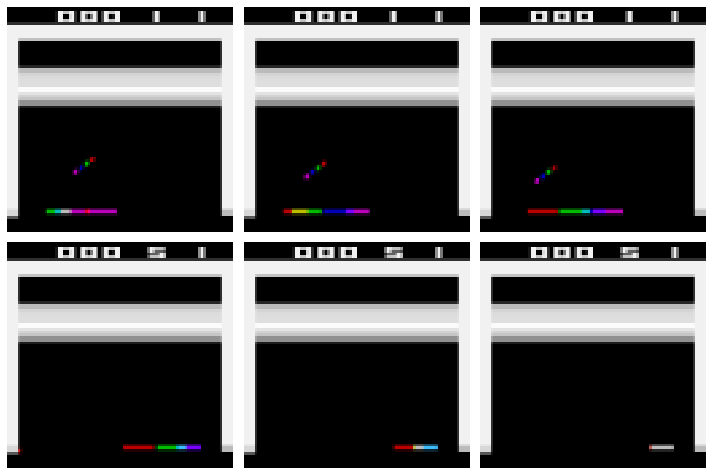

In [40]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

Now let's create the dataset:

In [41]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

Convert the main functions to TF Functions for better performance:

In [42]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

And now we are ready to run the main loop!

In [43]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Run the next cell to train the agent for 10,000 steps. Then look at its behavior by running the following cell. You can run these two cells as many times as you wish. The agent will keep improving!

In [44]:
train_agent(n_iterations=1000000)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


995 loss:0.02344

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 169.39999389648438


1998 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 48
		 EnvironmentSteps = 8004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 174.3000030517578


2999 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 72
		 EnvironmentSteps = 12004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 184.3000030517578


3995 loss:0.00778

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 16004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 169.39999389648438


4996 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 122
		 EnvironmentSteps = 20004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 160.89999389648438


5995 loss:0.00772

INFO:absl: 
		 NumberOfEpisodes = 144
		 EnvironmentSteps = 24004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 168.60000610351562


6999 loss:0.00766

INFO:absl: 
		 NumberOfEpisodes = 165
		 EnvironmentSteps = 28004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 204.39999389648438


7994 loss:0.00019

INFO:absl: 
		 NumberOfEpisodes = 187
		 EnvironmentSteps = 32004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 160.60000610351562


8997 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 210
		 EnvironmentSteps = 36004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 180.39999389648438


9998 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 233
		 EnvironmentSteps = 40004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 189.39999389648438


10996 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 257
		 EnvironmentSteps = 44004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 160.5


11996 loss:0.00746

INFO:absl: 
		 NumberOfEpisodes = 280
		 EnvironmentSteps = 48004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 184.89999389648438


12999 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 302
		 EnvironmentSteps = 52004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 174.0


13995 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 323
		 EnvironmentSteps = 56004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 183.39999389648438


14994 loss:0.01401

INFO:absl: 
		 NumberOfEpisodes = 346
		 EnvironmentSteps = 60004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 188.39999389648438


15994 loss:0.00693

INFO:absl: 
		 NumberOfEpisodes = 368
		 EnvironmentSteps = 64004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 190.0


16995 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 391
		 EnvironmentSteps = 68004
		 AverageReturn = 0.5
		 AverageEpisodeLength = 151.10000610351562


17999 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 414
		 EnvironmentSteps = 72004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 167.5


18996 loss:0.00021

INFO:absl: 
		 NumberOfEpisodes = 435
		 EnvironmentSteps = 76004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 175.60000610351562


19998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 457
		 EnvironmentSteps = 80004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 186.89999389648438


20999 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 479
		 EnvironmentSteps = 84004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 173.89999389648438


21999 loss:0.00020

INFO:absl: 
		 NumberOfEpisodes = 498
		 EnvironmentSteps = 88004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 194.10000610351562


22997 loss:0.00034

INFO:absl: 
		 NumberOfEpisodes = 518
		 EnvironmentSteps = 92004
		 AverageReturn = 1.899999976158142
		 AverageEpisodeLength = 212.0


23998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 539
		 EnvironmentSteps = 96004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 169.5


24999 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 558
		 EnvironmentSteps = 100004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 200.8000030517578


25995 loss:0.00022

INFO:absl: 
		 NumberOfEpisodes = 578
		 EnvironmentSteps = 104004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 204.89999389648438


26998 loss:0.00611

INFO:absl: 
		 NumberOfEpisodes = 598
		 EnvironmentSteps = 108004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 199.60000610351562


27994 loss:0.00026

INFO:absl: 
		 NumberOfEpisodes = 620
		 EnvironmentSteps = 112004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 159.8000030517578


28996 loss:0.00212

INFO:absl: 
		 NumberOfEpisodes = 641
		 EnvironmentSteps = 116004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 173.6999969482422


29995 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 661
		 EnvironmentSteps = 120004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 210.39999389648438


30994 loss:0.00725

INFO:absl: 
		 NumberOfEpisodes = 682
		 EnvironmentSteps = 124004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 187.10000610351562


31994 loss:0.00028

INFO:absl: 
		 NumberOfEpisodes = 702
		 EnvironmentSteps = 128004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 217.1999969482422


32998 loss:0.00029

INFO:absl: 
		 NumberOfEpisodes = 722
		 EnvironmentSteps = 132004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 203.6999969482422


33999 loss:0.00051

INFO:absl: 
		 NumberOfEpisodes = 742
		 EnvironmentSteps = 136004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 199.0


34996 loss:0.00055

INFO:absl: 
		 NumberOfEpisodes = 763
		 EnvironmentSteps = 140004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 187.60000610351562


35999 loss:0.00032

INFO:absl: 
		 NumberOfEpisodes = 782
		 EnvironmentSteps = 144004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 210.1999969482422


36996 loss:0.00032

INFO:absl: 
		 NumberOfEpisodes = 801
		 EnvironmentSteps = 148004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 212.8000030517578


37994 loss:0.00031

INFO:absl: 
		 NumberOfEpisodes = 822
		 EnvironmentSteps = 152004
		 AverageReturn = 2.0
		 AverageEpisodeLength = 215.1999969482422


38998 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 842
		 EnvironmentSteps = 156004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 193.6999969482422


39995 loss:0.00050

INFO:absl: 
		 NumberOfEpisodes = 859
		 EnvironmentSteps = 160004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 214.5


40998 loss:0.00057

INFO:absl: 
		 NumberOfEpisodes = 879
		 EnvironmentSteps = 164004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 214.39999389648438


41999 loss:0.00199

INFO:absl: 
		 NumberOfEpisodes = 897
		 EnvironmentSteps = 168004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 207.5


42999 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 915
		 EnvironmentSteps = 172004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 218.1999969482422


43997 loss:0.00572

INFO:absl: 
		 NumberOfEpisodes = 933
		 EnvironmentSteps = 176004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 219.10000610351562


44997 loss:0.00089

INFO:absl: 
		 NumberOfEpisodes = 950
		 EnvironmentSteps = 180004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 233.3000030517578


45997 loss:0.00044

INFO:absl: 
		 NumberOfEpisodes = 967
		 EnvironmentSteps = 184004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 221.0


46995 loss:0.00067

INFO:absl: 
		 NumberOfEpisodes = 984
		 EnvironmentSteps = 188004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 230.0


47996 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 1000
		 EnvironmentSteps = 192004
		 AverageReturn = 2.200000047683716
		 AverageEpisodeLength = 252.1999969482422


48999 loss:0.00181

INFO:absl: 
		 NumberOfEpisodes = 1015
		 EnvironmentSteps = 196004
		 AverageReturn = 2.5999999046325684
		 AverageEpisodeLength = 265.3999938964844


49995 loss:0.00079

INFO:absl: 
		 NumberOfEpisodes = 1030
		 EnvironmentSteps = 200004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 255.1999969482422


50997 loss:0.00014

INFO:absl: 
		 NumberOfEpisodes = 1044
		 EnvironmentSteps = 204004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 260.3999938964844


51999 loss:0.00203

INFO:absl: 
		 NumberOfEpisodes = 1056
		 EnvironmentSteps = 208004
		 AverageReturn = 3.299999952316284
		 AverageEpisodeLength = 328.0


52999 loss:0.00486

INFO:absl: 
		 NumberOfEpisodes = 1069
		 EnvironmentSteps = 212004
		 AverageReturn = 4.099999904632568
		 AverageEpisodeLength = 307.20001220703125


53999 loss:0.00282

INFO:absl: 
		 NumberOfEpisodes = 1080
		 EnvironmentSteps = 216004
		 AverageReturn = 3.700000047683716
		 AverageEpisodeLength = 357.29998779296875


54994 loss:0.00065

INFO:absl: 
		 NumberOfEpisodes = 1091
		 EnvironmentSteps = 220004
		 AverageReturn = 5.5
		 AverageEpisodeLength = 358.0


55994 loss:0.00176

INFO:absl: 
		 NumberOfEpisodes = 1101
		 EnvironmentSteps = 224004
		 AverageReturn = 3.200000047683716
		 AverageEpisodeLength = 413.6000061035156


56995 loss:0.00144

INFO:absl: 
		 NumberOfEpisodes = 1111
		 EnvironmentSteps = 228004
		 AverageReturn = 4.099999904632568
		 AverageEpisodeLength = 373.70001220703125


57996 loss:0.00229

INFO:absl: 
		 NumberOfEpisodes = 1121
		 EnvironmentSteps = 232004
		 AverageReturn = 5.0
		 AverageEpisodeLength = 430.3999938964844


58998 loss:0.00085

INFO:absl: 
		 NumberOfEpisodes = 1129
		 EnvironmentSteps = 236004
		 AverageReturn = 7.099999904632568
		 AverageEpisodeLength = 481.5


59999 loss:0.00200

INFO:absl: 
		 NumberOfEpisodes = 1136
		 EnvironmentSteps = 240004
		 AverageReturn = 6.099999904632568
		 AverageEpisodeLength = 483.79998779296875


60999 loss:0.00482

INFO:absl: 
		 NumberOfEpisodes = 1142
		 EnvironmentSteps = 244004
		 AverageReturn = 5.900000095367432
		 AverageEpisodeLength = 666.0


61998 loss:0.00101

INFO:absl: 
		 NumberOfEpisodes = 1146
		 EnvironmentSteps = 248004
		 AverageReturn = 7.900000095367432
		 AverageEpisodeLength = 841.2999877929688


62999 loss:0.00203

INFO:absl: 
		 NumberOfEpisodes = 1148
		 EnvironmentSteps = 252004
		 AverageReturn = 9.100000381469727
		 AverageEpisodeLength = 1082.0999755859375


63994 loss:0.00041

INFO:absl: 
		 NumberOfEpisodes = 1150
		 EnvironmentSteps = 256004
		 AverageReturn = 10.199999809265137
		 AverageEpisodeLength = 1296.800048828125


64995 loss:0.00166

INFO:absl: 
		 NumberOfEpisodes = 1153
		 EnvironmentSteps = 260004
		 AverageReturn = 9.399999618530273
		 AverageEpisodeLength = 1503.9000244140625


65995 loss:0.00031

INFO:absl: 
		 NumberOfEpisodes = 1155
		 EnvironmentSteps = 264004
		 AverageReturn = 9.0
		 AverageEpisodeLength = 1691.5999755859375


66995 loss:0.00215

INFO:absl: 
		 NumberOfEpisodes = 1156
		 EnvironmentSteps = 268004
		 AverageReturn = 9.0
		 AverageEpisodeLength = 1788.699951171875


67999 loss:0.00049

INFO:absl: 
		 NumberOfEpisodes = 1159
		 EnvironmentSteps = 272004
		 AverageReturn = 8.100000381469727
		 AverageEpisodeLength = 1716.5


68994 loss:0.00175

INFO:absl: 
		 NumberOfEpisodes = 1161
		 EnvironmentSteps = 276004
		 AverageReturn = 8.699999809265137
		 AverageEpisodeLength = 1913.199951171875


69995 loss:0.00116

INFO:absl: 
		 NumberOfEpisodes = 1164
		 EnvironmentSteps = 280004
		 AverageReturn = 7.900000095367432
		 AverageEpisodeLength = 1763.300048828125


70999 loss:0.00103

INFO:absl: 
		 NumberOfEpisodes = 1168
		 EnvironmentSteps = 284004
		 AverageReturn = 7.5
		 AverageEpisodeLength = 1378.199951171875


71998 loss:0.00078

INFO:absl: 
		 NumberOfEpisodes = 1171
		 EnvironmentSteps = 288004
		 AverageReturn = 6.5
		 AverageEpisodeLength = 1134.300048828125


72996 loss:0.00123

INFO:absl: 
		 NumberOfEpisodes = 1176
		 EnvironmentSteps = 292004
		 AverageReturn = 8.300000190734863
		 AverageEpisodeLength = 998.9000244140625


73996 loss:0.00604

INFO:absl: 
		 NumberOfEpisodes = 1178
		 EnvironmentSteps = 296004
		 AverageReturn = 8.300000190734863
		 AverageEpisodeLength = 1151.0999755859375


74997 loss:0.00267

INFO:absl: 
		 NumberOfEpisodes = 1180
		 EnvironmentSteps = 300004
		 AverageReturn = 9.100000381469727
		 AverageEpisodeLength = 1278.0999755859375


75994 loss:0.00218

INFO:absl: 
		 NumberOfEpisodes = 1186
		 EnvironmentSteps = 304004
		 AverageReturn = 8.5
		 AverageEpisodeLength = 1223.300048828125


76999 loss:0.00124

INFO:absl: 
		 NumberOfEpisodes = 1189
		 EnvironmentSteps = 308004
		 AverageReturn = 7.699999809265137
		 AverageEpisodeLength = 1032.199951171875


77996 loss:0.00117

INFO:absl: 
		 NumberOfEpisodes = 1196
		 EnvironmentSteps = 312004
		 AverageReturn = 7.199999809265137
		 AverageEpisodeLength = 816.7000122070312


78996 loss:0.00269

INFO:absl: 
		 NumberOfEpisodes = 1199
		 EnvironmentSteps = 316004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 896.9000244140625


79996 loss:0.00047

INFO:absl: 
		 NumberOfEpisodes = 1202
		 EnvironmentSteps = 320004
		 AverageReturn = 7.400000095367432
		 AverageEpisodeLength = 1009.2999877929688


80996 loss:0.00271

INFO:absl: 
		 NumberOfEpisodes = 1205
		 EnvironmentSteps = 324004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 1184.4000244140625


81996 loss:0.00080

INFO:absl: 
		 NumberOfEpisodes = 1208
		 EnvironmentSteps = 328004
		 AverageReturn = 9.399999618530273
		 AverageEpisodeLength = 1492.0


82994 loss:0.00093

INFO:absl: 
		 NumberOfEpisodes = 1212
		 EnvironmentSteps = 332004
		 AverageReturn = 9.0
		 AverageEpisodeLength = 1202.199951171875


83999 loss:0.00307

INFO:absl: 
		 NumberOfEpisodes = 1217
		 EnvironmentSteps = 336004
		 AverageReturn = 9.0
		 AverageEpisodeLength = 905.2999877929688


84999 loss:0.00079

INFO:absl: 
		 NumberOfEpisodes = 1227
		 EnvironmentSteps = 340004
		 AverageReturn = 5.800000190734863
		 AverageEpisodeLength = 419.3999938964844


85996 loss:0.00126

INFO:absl: 
		 NumberOfEpisodes = 1232
		 EnvironmentSteps = 344004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 587.0999755859375


86999 loss:0.00069

INFO:absl: 
		 NumberOfEpisodes = 1238
		 EnvironmentSteps = 348004
		 AverageReturn = 9.699999809265137
		 AverageEpisodeLength = 652.7000122070312


87994 loss:0.00067

INFO:absl: 
		 NumberOfEpisodes = 1244
		 EnvironmentSteps = 352004
		 AverageReturn = 7.300000190734863
		 AverageEpisodeLength = 638.0


88994 loss:0.00151

INFO:absl: 
		 NumberOfEpisodes = 1251
		 EnvironmentSteps = 356004
		 AverageReturn = 7.900000095367432
		 AverageEpisodeLength = 607.0999755859375


89999 loss:0.00089

INFO:absl: 
		 NumberOfEpisodes = 1254
		 EnvironmentSteps = 360004
		 AverageReturn = 8.600000381469727
		 AverageEpisodeLength = 728.2000122070312


90999 loss:0.00068

INFO:absl: 
		 NumberOfEpisodes = 1257
		 EnvironmentSteps = 364004
		 AverageReturn = 10.100000381469727
		 AverageEpisodeLength = 990.7000122070312


91994 loss:0.00100

INFO:absl: 
		 NumberOfEpisodes = 1260
		 EnvironmentSteps = 368004
		 AverageReturn = 9.899999618530273
		 AverageEpisodeLength = 1194.5999755859375


92997 loss:0.00082

INFO:absl: 
		 NumberOfEpisodes = 1267
		 EnvironmentSteps = 372004
		 AverageReturn = 9.100000381469727
		 AverageEpisodeLength = 848.5999755859375


93997 loss:0.00106

INFO:absl: 
		 NumberOfEpisodes = 1277
		 EnvironmentSteps = 376004
		 AverageReturn = 5.800000190734863
		 AverageEpisodeLength = 404.6000061035156


94998 loss:0.00107

INFO:absl: 
		 NumberOfEpisodes = 1291
		 EnvironmentSteps = 380004
		 AverageReturn = 4.5
		 AverageEpisodeLength = 286.79998779296875


95994 loss:0.00148

INFO:absl: 
		 NumberOfEpisodes = 1301
		 EnvironmentSteps = 384004
		 AverageReturn = 6.699999809265137
		 AverageEpisodeLength = 378.29998779296875


96997 loss:0.00291

INFO:absl: 
		 NumberOfEpisodes = 1314
		 EnvironmentSteps = 388004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 317.70001220703125


97996 loss:0.00183

INFO:absl: 
		 NumberOfEpisodes = 1324
		 EnvironmentSteps = 392004
		 AverageReturn = 7.5
		 AverageEpisodeLength = 390.20001220703125


98996 loss:0.00082

INFO:absl: 
		 NumberOfEpisodes = 1340
		 EnvironmentSteps = 396004
		 AverageReturn = 5.199999809265137
		 AverageEpisodeLength = 252.6999969482422


99995 loss:0.00071

INFO:absl: 
		 NumberOfEpisodes = 1356
		 EnvironmentSteps = 400004
		 AverageReturn = 4.300000190734863
		 AverageEpisodeLength = 237.6999969482422


100999 loss:0.00186

INFO:absl: 
		 NumberOfEpisodes = 1374
		 EnvironmentSteps = 404004
		 AverageReturn = 3.5999999046325684
		 AverageEpisodeLength = 228.6999969482422


101997 loss:0.00287

INFO:absl: 
		 NumberOfEpisodes = 1390
		 EnvironmentSteps = 408004
		 AverageReturn = 6.699999809265137
		 AverageEpisodeLength = 253.60000610351562


102999 loss:0.00096

INFO:absl: 
		 NumberOfEpisodes = 1407
		 EnvironmentSteps = 412004
		 AverageReturn = 3.700000047683716
		 AverageEpisodeLength = 236.0


103996 loss:0.00258

INFO:absl: 
		 NumberOfEpisodes = 1424
		 EnvironmentSteps = 416004
		 AverageReturn = 3.299999952316284
		 AverageEpisodeLength = 234.8000030517578


104995 loss:0.00150

INFO:absl: 
		 NumberOfEpisodes = 1443
		 EnvironmentSteps = 420004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


105994 loss:0.00102

INFO:absl: 
		 NumberOfEpisodes = 1461
		 EnvironmentSteps = 424004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


106996 loss:0.00159

INFO:absl: 
		 NumberOfEpisodes = 1480
		 EnvironmentSteps = 428004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


107999 loss:0.00319

INFO:absl: 
		 NumberOfEpisodes = 1499
		 EnvironmentSteps = 432004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


108995 loss:0.00609

INFO:absl: 
		 NumberOfEpisodes = 1517
		 EnvironmentSteps = 436004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


109996 loss:0.00193

INFO:absl: 
		 NumberOfEpisodes = 1536
		 EnvironmentSteps = 440004
		 AverageReturn = 3.0999999046325684
		 AverageEpisodeLength = 215.10000610351562


110997 loss:0.00204

INFO:absl: 
		 NumberOfEpisodes = 1555
		 EnvironmentSteps = 444004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


111995 loss:0.00369

INFO:absl: 
		 NumberOfEpisodes = 1574
		 EnvironmentSteps = 448004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


112994 loss:0.00140

INFO:absl: 
		 NumberOfEpisodes = 1592
		 EnvironmentSteps = 452004
		 AverageReturn = 3.4000000953674316
		 AverageEpisodeLength = 215.39999389648438


113994 loss:0.00067

INFO:absl: 
		 NumberOfEpisodes = 1611
		 EnvironmentSteps = 456004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


114999 loss:0.00115

INFO:absl: 
		 NumberOfEpisodes = 1630
		 EnvironmentSteps = 460004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


115997 loss:0.00541

INFO:absl: 
		 NumberOfEpisodes = 1649
		 EnvironmentSteps = 464004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.10000610351562


116999 loss:0.00731

INFO:absl: 
		 NumberOfEpisodes = 1668
		 EnvironmentSteps = 468004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.1999969482422


117996 loss:0.00126

INFO:absl: 
		 NumberOfEpisodes = 1686
		 EnvironmentSteps = 472004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.39999389648438


118998 loss:0.00149

INFO:absl: 
		 NumberOfEpisodes = 1705
		 EnvironmentSteps = 476004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.1999969482422


119994 loss:0.00235

INFO:absl: 
		 NumberOfEpisodes = 1724
		 EnvironmentSteps = 480004
		 AverageReturn = 3.0
		 AverageEpisodeLength = 212.0


120997 loss:0.00097

INFO:absl: 
		 NumberOfEpisodes = 1742
		 EnvironmentSteps = 484004
		 AverageReturn = 4.0
		 AverageEpisodeLength = 228.5


121996 loss:0.00238

INFO:absl: 
		 NumberOfEpisodes = 1759
		 EnvironmentSteps = 488004
		 AverageReturn = 3.299999952316284
		 AverageEpisodeLength = 237.3000030517578


122996 loss:0.00304

INFO:absl: 
		 NumberOfEpisodes = 1777
		 EnvironmentSteps = 492004
		 AverageReturn = 3.200000047683716
		 AverageEpisodeLength = 221.8000030517578


123999 loss:0.00188

INFO:absl: 
		 NumberOfEpisodes = 1795
		 EnvironmentSteps = 496004
		 AverageReturn = 3.4000000953674316
		 AverageEpisodeLength = 218.5


124994 loss:0.00257

INFO:absl: 
		 NumberOfEpisodes = 1812
		 EnvironmentSteps = 500004
		 AverageReturn = 4.800000190734863
		 AverageEpisodeLength = 243.8000030517578


125999 loss:0.00092

INFO:absl: 
		 NumberOfEpisodes = 1829
		 EnvironmentSteps = 504004
		 AverageReturn = 5.0
		 AverageEpisodeLength = 230.60000610351562


126997 loss:0.00096

INFO:absl: 
		 NumberOfEpisodes = 1841
		 EnvironmentSteps = 508004
		 AverageReturn = 6.900000095367432
		 AverageEpisodeLength = 303.79998779296875


127996 loss:0.00251

INFO:absl: 
		 NumberOfEpisodes = 1852
		 EnvironmentSteps = 512004
		 AverageReturn = 5.800000190734863
		 AverageEpisodeLength = 301.20001220703125


128995 loss:0.00218

INFO:absl: 
		 NumberOfEpisodes = 1863
		 EnvironmentSteps = 516004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 367.0


129994 loss:0.00069

INFO:absl: 
		 NumberOfEpisodes = 1877
		 EnvironmentSteps = 520004
		 AverageReturn = 5.400000095367432
		 AverageEpisodeLength = 285.70001220703125


130997 loss:0.00087

INFO:absl: 
		 NumberOfEpisodes = 1891
		 EnvironmentSteps = 524004
		 AverageReturn = 5.0
		 AverageEpisodeLength = 284.29998779296875


131997 loss:0.00128

INFO:absl: 
		 NumberOfEpisodes = 1903
		 EnvironmentSteps = 528004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 331.79998779296875


132999 loss:0.00420

INFO:absl: 
		 NumberOfEpisodes = 1916
		 EnvironmentSteps = 532004
		 AverageReturn = 5.599999904632568
		 AverageEpisodeLength = 308.70001220703125


133999 loss:0.00161

INFO:absl: 
		 NumberOfEpisodes = 1922
		 EnvironmentSteps = 536004
		 AverageReturn = 8.100000381469727
		 AverageEpisodeLength = 498.20001220703125


134994 loss:0.00970

INFO:absl: 
		 NumberOfEpisodes = 1937
		 EnvironmentSteps = 540004
		 AverageReturn = 3.200000047683716
		 AverageEpisodeLength = 224.5


135995 loss:0.00212

INFO:absl: 
		 NumberOfEpisodes = 1945
		 EnvironmentSteps = 544004
		 AverageReturn = 5.599999904632568
		 AverageEpisodeLength = 463.3999938964844


136999 loss:0.00211

INFO:absl: 
		 NumberOfEpisodes = 1960
		 EnvironmentSteps = 548004
		 AverageReturn = 3.5999999046325684
		 AverageEpisodeLength = 249.3000030517578


137996 loss:0.00608

INFO:absl: 
		 NumberOfEpisodes = 1976
		 EnvironmentSteps = 552004
		 AverageReturn = 5.199999809265137
		 AverageEpisodeLength = 290.29998779296875


138994 loss:0.00995

INFO:absl: 
		 NumberOfEpisodes = 1985
		 EnvironmentSteps = 556004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 350.20001220703125


139999 loss:0.00126

INFO:absl: 
		 NumberOfEpisodes = 1998
		 EnvironmentSteps = 560004
		 AverageReturn = 4.300000190734863
		 AverageEpisodeLength = 261.79998779296875


140995 loss:0.00208

INFO:absl: 
		 NumberOfEpisodes = 2007
		 EnvironmentSteps = 564004
		 AverageReturn = 7.900000095367432
		 AverageEpisodeLength = 427.3999938964844


141997 loss:0.00443

INFO:absl: 
		 NumberOfEpisodes = 2021
		 EnvironmentSteps = 568004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 298.20001220703125


142997 loss:0.00652

INFO:absl: 
		 NumberOfEpisodes = 2031
		 EnvironmentSteps = 572004
		 AverageReturn = 7.199999809265137
		 AverageEpisodeLength = 403.79998779296875


143998 loss:0.00774

INFO:absl: 
		 NumberOfEpisodes = 2041
		 EnvironmentSteps = 576004
		 AverageReturn = 6.0
		 AverageEpisodeLength = 377.20001220703125


144999 loss:0.00333

INFO:absl: 
		 NumberOfEpisodes = 2051
		 EnvironmentSteps = 580004
		 AverageReturn = 7.400000095367432
		 AverageEpisodeLength = 412.6000061035156


145995 loss:0.00144

INFO:absl: 
		 NumberOfEpisodes = 2064
		 EnvironmentSteps = 584004
		 AverageReturn = 5.900000095367432
		 AverageEpisodeLength = 311.1000061035156


146998 loss:0.00163

INFO:absl: 
		 NumberOfEpisodes = 2076
		 EnvironmentSteps = 588004
		 AverageReturn = 7.199999809265137
		 AverageEpisodeLength = 320.29998779296875


147997 loss:0.00301

INFO:absl: 
		 NumberOfEpisodes = 2087
		 EnvironmentSteps = 592004
		 AverageReturn = 8.399999618530273
		 AverageEpisodeLength = 364.0


148996 loss:0.02661

INFO:absl: 
		 NumberOfEpisodes = 2098
		 EnvironmentSteps = 596004
		 AverageReturn = 7.699999809265137
		 AverageEpisodeLength = 385.1000061035156


149995 loss:0.00134

INFO:absl: 
		 NumberOfEpisodes = 2110
		 EnvironmentSteps = 600004
		 AverageReturn = 6.099999904632568
		 AverageEpisodeLength = 318.20001220703125


150995 loss:0.00523

INFO:absl: 
		 NumberOfEpisodes = 2123
		 EnvironmentSteps = 604004
		 AverageReturn = 5.599999904632568
		 AverageEpisodeLength = 305.0


151995 loss:0.01643

INFO:absl: 
		 NumberOfEpisodes = 2137
		 EnvironmentSteps = 608004
		 AverageReturn = 5.300000190734863
		 AverageEpisodeLength = 287.1000061035156


152998 loss:0.00521

INFO:absl: 
		 NumberOfEpisodes = 2151
		 EnvironmentSteps = 612004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 314.3999938964844


153996 loss:0.00133

INFO:absl: 
		 NumberOfEpisodes = 2165
		 EnvironmentSteps = 616004
		 AverageReturn = 4.5
		 AverageEpisodeLength = 276.6000061035156


154999 loss:0.00359

INFO:absl: 
		 NumberOfEpisodes = 2181
		 EnvironmentSteps = 620004
		 AverageReturn = 4.400000095367432
		 AverageEpisodeLength = 264.0


155999 loss:0.00325

INFO:absl: 
		 NumberOfEpisodes = 2195
		 EnvironmentSteps = 624004
		 AverageReturn = 6.0
		 AverageEpisodeLength = 280.6000061035156


156997 loss:0.00328

INFO:absl: 
		 NumberOfEpisodes = 2207
		 EnvironmentSteps = 628004
		 AverageReturn = 6.900000095367432
		 AverageEpisodeLength = 333.6000061035156


157994 loss:0.05833

INFO:absl: 
		 NumberOfEpisodes = 2216
		 EnvironmentSteps = 632004
		 AverageReturn = 7.0
		 AverageEpisodeLength = 450.70001220703125


158999 loss:0.00134

INFO:absl: 
		 NumberOfEpisodes = 2229
		 EnvironmentSteps = 636004
		 AverageReturn = 6.800000190734863
		 AverageEpisodeLength = 308.8999938964844


159996 loss:0.00273

INFO:absl: 
		 NumberOfEpisodes = 2243
		 EnvironmentSteps = 640004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 272.8999938964844


160995 loss:0.00288

INFO:absl: 
		 NumberOfEpisodes = 2257
		 EnvironmentSteps = 644004
		 AverageReturn = 7.099999904632568
		 AverageEpisodeLength = 308.3999938964844


161994 loss:0.00252

INFO:absl: 
		 NumberOfEpisodes = 2272
		 EnvironmentSteps = 648004
		 AverageReturn = 4.699999809265137
		 AverageEpisodeLength = 263.5


162995 loss:0.00861

INFO:absl: 
		 NumberOfEpisodes = 2288
		 EnvironmentSteps = 652004
		 AverageReturn = 3.299999952316284
		 AverageEpisodeLength = 230.10000610351562


163999 loss:0.00195

INFO:absl: 
		 NumberOfEpisodes = 2305
		 EnvironmentSteps = 656004
		 AverageReturn = 4.599999904632568
		 AverageEpisodeLength = 263.29998779296875


164995 loss:0.00211

INFO:absl: 
		 NumberOfEpisodes = 2320
		 EnvironmentSteps = 660004
		 AverageReturn = 4.5
		 AverageEpisodeLength = 274.3999938964844


165996 loss:0.00321

INFO:absl: 
		 NumberOfEpisodes = 2335
		 EnvironmentSteps = 664004
		 AverageReturn = 4.300000190734863
		 AverageEpisodeLength = 252.8000030517578


166996 loss:0.00135

INFO:absl: 
		 NumberOfEpisodes = 2350
		 EnvironmentSteps = 668004
		 AverageReturn = 4.199999809265137
		 AverageEpisodeLength = 261.79998779296875


167998 loss:0.00122

INFO:absl: 
		 NumberOfEpisodes = 2366
		 EnvironmentSteps = 672004
		 AverageReturn = 4.400000095367432
		 AverageEpisodeLength = 252.10000610351562


169000 loss:0.00185

INFO:absl: 
		 NumberOfEpisodes = 2381
		 EnvironmentSteps = 676004
		 AverageReturn = 5.5
		 AverageEpisodeLength = 287.0


169999 loss:0.00399

INFO:absl: 
		 NumberOfEpisodes = 2395
		 EnvironmentSteps = 680004
		 AverageReturn = 5.0
		 AverageEpisodeLength = 275.79998779296875


170998 loss:0.00458

INFO:absl: 
		 NumberOfEpisodes = 2408
		 EnvironmentSteps = 684004
		 AverageReturn = 5.300000190734863
		 AverageEpisodeLength = 292.3999938964844


171997 loss:0.00134

INFO:absl: 
		 NumberOfEpisodes = 2419
		 EnvironmentSteps = 688004
		 AverageReturn = 5.599999904632568
		 AverageEpisodeLength = 383.0


172996 loss:0.00073

INFO:absl: 
		 NumberOfEpisodes = 2431
		 EnvironmentSteps = 692004
		 AverageReturn = 6.300000190734863
		 AverageEpisodeLength = 337.70001220703125


173998 loss:0.00109

INFO:absl: 
		 NumberOfEpisodes = 2445
		 EnvironmentSteps = 696004
		 AverageReturn = 6.900000095367432
		 AverageEpisodeLength = 291.0


174996 loss:0.00150

INFO:absl: 
		 NumberOfEpisodes = 2459
		 EnvironmentSteps = 700004
		 AverageReturn = 4.900000095367432
		 AverageEpisodeLength = 286.8999938964844


175994 loss:0.00232

INFO:absl: 
		 NumberOfEpisodes = 2473
		 EnvironmentSteps = 704004
		 AverageReturn = 5.5
		 AverageEpisodeLength = 276.1000061035156


176997 loss:0.00551

INFO:absl: 
		 NumberOfEpisodes = 2484
		 EnvironmentSteps = 708004
		 AverageReturn = 8.399999618530273
		 AverageEpisodeLength = 364.3999938964844


177998 loss:0.00373

INFO:absl: 
		 NumberOfEpisodes = 2496
		 EnvironmentSteps = 712004
		 AverageReturn = 8.0
		 AverageEpisodeLength = 325.6000061035156


178999 loss:0.01078

INFO:absl: 
		 NumberOfEpisodes = 2511
		 EnvironmentSteps = 716004
		 AverageReturn = 5.599999904632568
		 AverageEpisodeLength = 270.70001220703125


179994 loss:0.00112

INFO:absl: 
		 NumberOfEpisodes = 2526
		 EnvironmentSteps = 720004
		 AverageReturn = 4.800000190734863
		 AverageEpisodeLength = 259.0


180999 loss:0.00247

INFO:absl: 
		 NumberOfEpisodes = 2538
		 EnvironmentSteps = 724004
		 AverageReturn = 5.900000095367432
		 AverageEpisodeLength = 332.3999938964844


181997 loss:0.00533

INFO:absl: 
		 NumberOfEpisodes = 2549
		 EnvironmentSteps = 728004
		 AverageReturn = 5.099999904632568
		 AverageEpisodeLength = 288.70001220703125


182999 loss:0.00227

INFO:absl: 
		 NumberOfEpisodes = 2560
		 EnvironmentSteps = 732004
		 AverageReturn = 7.5
		 AverageEpisodeLength = 343.5


183995 loss:0.00150

INFO:absl: 
		 NumberOfEpisodes = 2574
		 EnvironmentSteps = 736004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 297.5


184999 loss:0.00205

INFO:absl: 
		 NumberOfEpisodes = 2588
		 EnvironmentSteps = 740004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 307.29998779296875


185995 loss:0.00770

INFO:absl: 
		 NumberOfEpisodes = 2600
		 EnvironmentSteps = 744004
		 AverageReturn = 6.900000095367432
		 AverageEpisodeLength = 344.5


186996 loss:0.00317

INFO:absl: 
		 NumberOfEpisodes = 2609
		 EnvironmentSteps = 748004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 415.20001220703125


187996 loss:0.00080

INFO:absl: 
		 NumberOfEpisodes = 2621
		 EnvironmentSteps = 752004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 327.0


188996 loss:0.00358

INFO:absl: 
		 NumberOfEpisodes = 2629
		 EnvironmentSteps = 756004
		 AverageReturn = 7.300000190734863
		 AverageEpisodeLength = 395.79998779296875


189996 loss:0.00097

INFO:absl: 
		 NumberOfEpisodes = 2639
		 EnvironmentSteps = 760004
		 AverageReturn = 7.900000095367432
		 AverageEpisodeLength = 455.8999938964844


190999 loss:0.00123

INFO:absl: 
		 NumberOfEpisodes = 2652
		 EnvironmentSteps = 764004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 305.79998779296875


191998 loss:0.00075

INFO:absl: 
		 NumberOfEpisodes = 2662
		 EnvironmentSteps = 768004
		 AverageReturn = 8.300000190734863
		 AverageEpisodeLength = 382.79998779296875


192999 loss:0.00344

INFO:absl: 
		 NumberOfEpisodes = 2675
		 EnvironmentSteps = 772004
		 AverageReturn = 5.199999809265137
		 AverageEpisodeLength = 280.6000061035156


193994 loss:0.00111

INFO:absl: 
		 NumberOfEpisodes = 2690
		 EnvironmentSteps = 776004
		 AverageReturn = 6.300000190734863
		 AverageEpisodeLength = 283.5


194996 loss:0.00209

INFO:absl: 
		 NumberOfEpisodes = 2704
		 EnvironmentSteps = 780004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 288.29998779296875


195995 loss:0.00096

INFO:absl: 
		 NumberOfEpisodes = 2721
		 EnvironmentSteps = 784004
		 AverageReturn = 4.099999904632568
		 AverageEpisodeLength = 231.39999389648438


196996 loss:0.00209

INFO:absl: 
		 NumberOfEpisodes = 2736
		 EnvironmentSteps = 788004
		 AverageReturn = 4.300000190734863
		 AverageEpisodeLength = 264.0


197999 loss:0.00180

INFO:absl: 
		 NumberOfEpisodes = 2749
		 EnvironmentSteps = 792004
		 AverageReturn = 5.400000095367432
		 AverageEpisodeLength = 295.20001220703125


198995 loss:0.00395

INFO:absl: 
		 NumberOfEpisodes = 2761
		 EnvironmentSteps = 796004
		 AverageReturn = 6.300000190734863
		 AverageEpisodeLength = 361.20001220703125


199998 loss:0.00185

INFO:absl: 
		 NumberOfEpisodes = 2773
		 EnvironmentSteps = 800004
		 AverageReturn = 6.5
		 AverageEpisodeLength = 308.5


200994 loss:0.01980

INFO:absl: 
		 NumberOfEpisodes = 2782
		 EnvironmentSteps = 804004
		 AverageReturn = 10.600000381469727
		 AverageEpisodeLength = 471.29998779296875


201997 loss:0.00135

INFO:absl: 
		 NumberOfEpisodes = 2793
		 EnvironmentSteps = 808004
		 AverageReturn = 6.300000190734863
		 AverageEpisodeLength = 329.3999938964844


202995 loss:0.00225

INFO:absl: 
		 NumberOfEpisodes = 2806
		 EnvironmentSteps = 812004
		 AverageReturn = 6.5
		 AverageEpisodeLength = 337.0


203994 loss:0.00639

INFO:absl: 
		 NumberOfEpisodes = 2818
		 EnvironmentSteps = 816004
		 AverageReturn = 6.300000190734863
		 AverageEpisodeLength = 316.20001220703125


204999 loss:0.00100

INFO:absl: 
		 NumberOfEpisodes = 2830
		 EnvironmentSteps = 820004
		 AverageReturn = 6.699999809265137
		 AverageEpisodeLength = 330.3999938964844


205994 loss:0.00158

INFO:absl: 
		 NumberOfEpisodes = 2841
		 EnvironmentSteps = 824004
		 AverageReturn = 8.100000381469727
		 AverageEpisodeLength = 375.0


206996 loss:0.00592

INFO:absl: 
		 NumberOfEpisodes = 2854
		 EnvironmentSteps = 828004
		 AverageReturn = 5.900000095367432
		 AverageEpisodeLength = 309.6000061035156


207999 loss:0.00237

INFO:absl: 
		 NumberOfEpisodes = 2866
		 EnvironmentSteps = 832004
		 AverageReturn = 7.0
		 AverageEpisodeLength = 346.5


208999 loss:0.00554

INFO:absl: 
		 NumberOfEpisodes = 2878
		 EnvironmentSteps = 836004
		 AverageReturn = 6.300000190734863
		 AverageEpisodeLength = 340.79998779296875


209999 loss:0.00924

INFO:absl: 
		 NumberOfEpisodes = 2889
		 EnvironmentSteps = 840004
		 AverageReturn = 6.800000190734863
		 AverageEpisodeLength = 338.0


210996 loss:0.00226

INFO:absl: 
		 NumberOfEpisodes = 2901
		 EnvironmentSteps = 844004
		 AverageReturn = 6.400000095367432
		 AverageEpisodeLength = 345.79998779296875


211994 loss:0.00206

INFO:absl: 
		 NumberOfEpisodes = 2913
		 EnvironmentSteps = 848004
		 AverageReturn = 6.099999904632568
		 AverageEpisodeLength = 322.1000061035156


212999 loss:0.00096

INFO:absl: 
		 NumberOfEpisodes = 2925
		 EnvironmentSteps = 852004
		 AverageReturn = 6.0
		 AverageEpisodeLength = 320.1000061035156


213994 loss:0.00217

INFO:absl: 
		 NumberOfEpisodes = 2937
		 EnvironmentSteps = 856004
		 AverageReturn = 6.0
		 AverageEpisodeLength = 325.29998779296875


214994 loss:0.00262

INFO:absl: 
		 NumberOfEpisodes = 2949
		 EnvironmentSteps = 860004
		 AverageReturn = 6.0
		 AverageEpisodeLength = 341.20001220703125


215995 loss:0.00165

INFO:absl: 
		 NumberOfEpisodes = 2959
		 EnvironmentSteps = 864004
		 AverageReturn = 8.300000190734863
		 AverageEpisodeLength = 403.6000061035156


216994 loss:0.00225

INFO:absl: 
		 NumberOfEpisodes = 2968
		 EnvironmentSteps = 868004
		 AverageReturn = 9.5
		 AverageEpisodeLength = 396.79998779296875


217994 loss:0.00092

INFO:absl: 
		 NumberOfEpisodes = 2979
		 EnvironmentSteps = 872004
		 AverageReturn = 7.199999809265137
		 AverageEpisodeLength = 368.70001220703125


218996 loss:0.00070

INFO:absl: 
		 NumberOfEpisodes = 2991
		 EnvironmentSteps = 876004
		 AverageReturn = 6.699999809265137
		 AverageEpisodeLength = 330.0


219999 loss:0.00926

INFO:absl: 
		 NumberOfEpisodes = 3001
		 EnvironmentSteps = 880004
		 AverageReturn = 10.800000190734863
		 AverageEpisodeLength = 403.5


220995 loss:0.02307

INFO:absl: 
		 NumberOfEpisodes = 3007
		 EnvironmentSteps = 884004
		 AverageReturn = 11.600000381469727
		 AverageEpisodeLength = 568.7000122070312


221997 loss:0.00462

INFO:absl: 
		 NumberOfEpisodes = 3017
		 EnvironmentSteps = 888004
		 AverageReturn = 9.300000190734863
		 AverageEpisodeLength = 391.79998779296875


222997 loss:0.00136

INFO:absl: 
		 NumberOfEpisodes = 3027
		 EnvironmentSteps = 892004
		 AverageReturn = 8.199999809265137
		 AverageEpisodeLength = 383.6000061035156


223995 loss:0.00179

INFO:absl: 
		 NumberOfEpisodes = 3038
		 EnvironmentSteps = 896004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 370.3999938964844


224994 loss:0.00142

INFO:absl: 
		 NumberOfEpisodes = 3048
		 EnvironmentSteps = 900004
		 AverageReturn = 8.399999618530273
		 AverageEpisodeLength = 411.29998779296875


225997 loss:0.00179

INFO:absl: 
		 NumberOfEpisodes = 3058
		 EnvironmentSteps = 904004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 381.29998779296875


226996 loss:0.00148

INFO:absl: 
		 NumberOfEpisodes = 3070
		 EnvironmentSteps = 908004
		 AverageReturn = 6.900000095367432
		 AverageEpisodeLength = 340.29998779296875


227995 loss:0.00065

INFO:absl: 
		 NumberOfEpisodes = 3082
		 EnvironmentSteps = 912004
		 AverageReturn = 5.800000190734863
		 AverageEpisodeLength = 325.5


228994 loss:0.00107

INFO:absl: 
		 NumberOfEpisodes = 3093
		 EnvironmentSteps = 916004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 387.5


229997 loss:0.00254

INFO:absl: 
		 NumberOfEpisodes = 3105
		 EnvironmentSteps = 920004
		 AverageReturn = 5.400000095367432
		 AverageEpisodeLength = 308.1000061035156


230994 loss:0.00129

INFO:absl: 
		 NumberOfEpisodes = 3117
		 EnvironmentSteps = 924004
		 AverageReturn = 7.0
		 AverageEpisodeLength = 345.8999938964844


231996 loss:0.00235

INFO:absl: 
		 NumberOfEpisodes = 3128
		 EnvironmentSteps = 928004
		 AverageReturn = 6.199999809265137
		 AverageEpisodeLength = 334.70001220703125


232994 loss:0.01064

INFO:absl: 
		 NumberOfEpisodes = 3139
		 EnvironmentSteps = 932004
		 AverageReturn = 8.899999618530273
		 AverageEpisodeLength = 391.3999938964844


233995 loss:0.00136

INFO:absl: 
		 NumberOfEpisodes = 3148
		 EnvironmentSteps = 936004
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 429.0


234996 loss:0.00122

INFO:absl: 
		 NumberOfEpisodes = 3157
		 EnvironmentSteps = 940004
		 AverageReturn = 10.0
		 AverageEpisodeLength = 452.6000061035156


235995 loss:0.00324

INFO:absl: 
		 NumberOfEpisodes = 3168
		 EnvironmentSteps = 944004
		 AverageReturn = 7.400000095367432
		 AverageEpisodeLength = 377.1000061035156


236994 loss:0.00161

INFO:absl: 
		 NumberOfEpisodes = 3179
		 EnvironmentSteps = 948004
		 AverageReturn = 6.900000095367432
		 AverageEpisodeLength = 353.0


237998 loss:0.00102

INFO:absl: 
		 NumberOfEpisodes = 3191
		 EnvironmentSteps = 952004
		 AverageReturn = 6.800000190734863
		 AverageEpisodeLength = 321.5


238996 loss:0.00216

INFO:absl: 
		 NumberOfEpisodes = 3202
		 EnvironmentSteps = 956004
		 AverageReturn = 8.100000381469727
		 AverageEpisodeLength = 378.70001220703125


239999 loss:0.00096

INFO:absl: 
		 NumberOfEpisodes = 3212
		 EnvironmentSteps = 960004
		 AverageReturn = 9.0
		 AverageEpisodeLength = 377.20001220703125


240999 loss:0.00102

INFO:absl: 
		 NumberOfEpisodes = 3223
		 EnvironmentSteps = 964004
		 AverageReturn = 7.699999809265137
		 AverageEpisodeLength = 370.79998779296875


241998 loss:0.00167

INFO:absl: 
		 NumberOfEpisodes = 3233
		 EnvironmentSteps = 968004
		 AverageReturn = 10.800000190734863
		 AverageEpisodeLength = 417.20001220703125


242994 loss:0.00665

INFO:absl: 
		 NumberOfEpisodes = 3243
		 EnvironmentSteps = 972004
		 AverageReturn = 9.699999809265137
		 AverageEpisodeLength = 397.20001220703125


243995 loss:0.00581

INFO:absl: 
		 NumberOfEpisodes = 3252
		 EnvironmentSteps = 976004
		 AverageReturn = 10.899999618530273
		 AverageEpisodeLength = 437.0


244999 loss:0.00072

INFO:absl: 
		 NumberOfEpisodes = 3262
		 EnvironmentSteps = 980004
		 AverageReturn = 9.300000190734863
		 AverageEpisodeLength = 402.20001220703125


245996 loss:0.00083

INFO:absl: 
		 NumberOfEpisodes = 3270
		 EnvironmentSteps = 984004
		 AverageReturn = 11.5
		 AverageEpisodeLength = 447.6000061035156


246998 loss:0.00348

INFO:absl: 
		 NumberOfEpisodes = 3280
		 EnvironmentSteps = 988004
		 AverageReturn = 9.600000381469727
		 AverageEpisodeLength = 408.0


247998 loss:0.00131

INFO:absl: 
		 NumberOfEpisodes = 3290
		 EnvironmentSteps = 992004
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 414.1000061035156


248998 loss:0.04667

INFO:absl: 
		 NumberOfEpisodes = 3298
		 EnvironmentSteps = 996004
		 AverageReturn = 12.199999809265137
		 AverageEpisodeLength = 455.29998779296875


249998 loss:0.00177

INFO:absl: 
		 NumberOfEpisodes = 3306
		 EnvironmentSteps = 1000004
		 AverageReturn = 12.0
		 AverageEpisodeLength = 493.0


250997 loss:0.00222

INFO:absl: 
		 NumberOfEpisodes = 3314
		 EnvironmentSteps = 1004004
		 AverageReturn = 11.899999618530273
		 AverageEpisodeLength = 486.79998779296875


251996 loss:0.00108

INFO:absl: 
		 NumberOfEpisodes = 3324
		 EnvironmentSteps = 1008004
		 AverageReturn = 10.399999618530273
		 AverageEpisodeLength = 398.70001220703125


252996 loss:0.00273

INFO:absl: 
		 NumberOfEpisodes = 3333
		 EnvironmentSteps = 1012004
		 AverageReturn = 11.399999618530273
		 AverageEpisodeLength = 437.8999938964844


253996 loss:0.00462

INFO:absl: 
		 NumberOfEpisodes = 3343
		 EnvironmentSteps = 1016004
		 AverageReturn = 9.100000381469727
		 AverageEpisodeLength = 378.5


254994 loss:0.00130

INFO:absl: 
		 NumberOfEpisodes = 3353
		 EnvironmentSteps = 1020004
		 AverageReturn = 11.199999809265137
		 AverageEpisodeLength = 431.3999938964844


255999 loss:0.00247

INFO:absl: 
		 NumberOfEpisodes = 3362
		 EnvironmentSteps = 1024004
		 AverageReturn = 10.5
		 AverageEpisodeLength = 440.6000061035156


256998 loss:0.00071

INFO:absl: 
		 NumberOfEpisodes = 3372
		 EnvironmentSteps = 1028004
		 AverageReturn = 8.5
		 AverageEpisodeLength = 402.8999938964844


257997 loss:0.00399

INFO:absl: 
		 NumberOfEpisodes = 3383
		 EnvironmentSteps = 1032004
		 AverageReturn = 8.199999809265137
		 AverageEpisodeLength = 371.79998779296875


258998 loss:0.00189

INFO:absl: 
		 NumberOfEpisodes = 3393
		 EnvironmentSteps = 1036004
		 AverageReturn = 8.800000190734863
		 AverageEpisodeLength = 398.1000061035156


259994 loss:0.00208

INFO:absl: 
		 NumberOfEpisodes = 3402
		 EnvironmentSteps = 1040004
		 AverageReturn = 9.600000381469727
		 AverageEpisodeLength = 429.6000061035156


260996 loss:0.00230

INFO:absl: 
		 NumberOfEpisodes = 3412
		 EnvironmentSteps = 1044004
		 AverageReturn = 9.300000190734863
		 AverageEpisodeLength = 389.8999938964844


261996 loss:0.00397

INFO:absl: 
		 NumberOfEpisodes = 3422
		 EnvironmentSteps = 1048004
		 AverageReturn = 10.199999809265137
		 AverageEpisodeLength = 431.0


262996 loss:0.00783

INFO:absl: 
		 NumberOfEpisodes = 3431
		 EnvironmentSteps = 1052004
		 AverageReturn = 9.899999618530273
		 AverageEpisodeLength = 421.6000061035156


263995 loss:0.00162

INFO:absl: 
		 NumberOfEpisodes = 3439
		 EnvironmentSteps = 1056004
		 AverageReturn = 12.399999618530273
		 AverageEpisodeLength = 490.5


264995 loss:0.00233

INFO:absl: 
		 NumberOfEpisodes = 3448
		 EnvironmentSteps = 1060004
		 AverageReturn = 12.600000381469727
		 AverageEpisodeLength = 455.29998779296875


265994 loss:0.00136

INFO:absl: 
		 NumberOfEpisodes = 3455
		 EnvironmentSteps = 1064004
		 AverageReturn = 13.699999809265137
		 AverageEpisodeLength = 572.0999755859375


266995 loss:0.00261

INFO:absl: 
		 NumberOfEpisodes = 3463
		 EnvironmentSteps = 1068004
		 AverageReturn = 11.300000190734863
		 AverageEpisodeLength = 488.1000061035156


267997 loss:0.00175

INFO:absl: 
		 NumberOfEpisodes = 3471
		 EnvironmentSteps = 1072004
		 AverageReturn = 12.600000381469727
		 AverageEpisodeLength = 491.79998779296875


268994 loss:0.00124

INFO:absl: 
		 NumberOfEpisodes = 3481
		 EnvironmentSteps = 1076004
		 AverageReturn = 11.800000190734863
		 AverageEpisodeLength = 405.1000061035156


269998 loss:0.00602

INFO:absl: 
		 NumberOfEpisodes = 3489
		 EnvironmentSteps = 1080004
		 AverageReturn = 11.699999809265137
		 AverageEpisodeLength = 450.6000061035156


270997 loss:0.00096

INFO:absl: 
		 NumberOfEpisodes = 3498
		 EnvironmentSteps = 1084004
		 AverageReturn = 12.600000381469727
		 AverageEpisodeLength = 454.0


271994 loss:0.00431

INFO:absl: 
		 NumberOfEpisodes = 3508
		 EnvironmentSteps = 1088004
		 AverageReturn = 11.199999809265137
		 AverageEpisodeLength = 427.8999938964844


272998 loss:0.00249

INFO:absl: 
		 NumberOfEpisodes = 3517
		 EnvironmentSteps = 1092004
		 AverageReturn = 11.300000190734863
		 AverageEpisodeLength = 437.79998779296875


273999 loss:0.01398

INFO:absl: 
		 NumberOfEpisodes = 3527
		 EnvironmentSteps = 1096004
		 AverageReturn = 9.5
		 AverageEpisodeLength = 402.3999938964844


274998 loss:0.00149

INFO:absl: 
		 NumberOfEpisodes = 3537
		 EnvironmentSteps = 1100004
		 AverageReturn = 10.5
		 AverageEpisodeLength = 407.1000061035156


275999 loss:0.00701

INFO:absl: 
		 NumberOfEpisodes = 3545
		 EnvironmentSteps = 1104004
		 AverageReturn = 12.5
		 AverageEpisodeLength = 467.70001220703125


276997 loss:0.00272

INFO:absl: 
		 NumberOfEpisodes = 3555
		 EnvironmentSteps = 1108004
		 AverageReturn = 10.100000381469727
		 AverageEpisodeLength = 418.3999938964844


277998 loss:0.00600

INFO:absl: 
		 NumberOfEpisodes = 3563
		 EnvironmentSteps = 1112004
		 AverageReturn = 13.699999809265137
		 AverageEpisodeLength = 492.3999938964844


278995 loss:0.00165

INFO:absl: 
		 NumberOfEpisodes = 3570
		 EnvironmentSteps = 1116004
		 AverageReturn = 13.600000381469727
		 AverageEpisodeLength = 492.8999938964844


279999 loss:0.04335

INFO:absl: 
		 NumberOfEpisodes = 3578
		 EnvironmentSteps = 1120004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 549.5


280995 loss:0.00209

INFO:absl: 
		 NumberOfEpisodes = 3586
		 EnvironmentSteps = 1124004
		 AverageReturn = 13.0
		 AverageEpisodeLength = 470.5


281997 loss:0.00651

INFO:absl: 
		 NumberOfEpisodes = 3595
		 EnvironmentSteps = 1128004
		 AverageReturn = 12.199999809265137
		 AverageEpisodeLength = 457.20001220703125


282999 loss:0.00605

INFO:absl: 
		 NumberOfEpisodes = 3603
		 EnvironmentSteps = 1132004
		 AverageReturn = 13.199999809265137
		 AverageEpisodeLength = 476.79998779296875


283996 loss:0.00127

INFO:absl: 
		 NumberOfEpisodes = 3612
		 EnvironmentSteps = 1136004
		 AverageReturn = 13.399999618530273
		 AverageEpisodeLength = 471.5


284996 loss:0.00361

INFO:absl: 
		 NumberOfEpisodes = 3621
		 EnvironmentSteps = 1140004
		 AverageReturn = 10.199999809265137
		 AverageEpisodeLength = 437.70001220703125


285998 loss:0.00316

INFO:absl: 
		 NumberOfEpisodes = 3632
		 EnvironmentSteps = 1144004
		 AverageReturn = 8.100000381469727
		 AverageEpisodeLength = 379.6000061035156


286999 loss:0.00179

INFO:absl: 
		 NumberOfEpisodes = 3641
		 EnvironmentSteps = 1148004
		 AverageReturn = 9.0
		 AverageEpisodeLength = 414.20001220703125


287995 loss:0.00204

INFO:absl: 
		 NumberOfEpisodes = 3651
		 EnvironmentSteps = 1152004
		 AverageReturn = 8.199999809265137
		 AverageEpisodeLength = 392.29998779296875


288994 loss:0.00338

INFO:absl: 
		 NumberOfEpisodes = 3660
		 EnvironmentSteps = 1156004
		 AverageReturn = 12.300000190734863
		 AverageEpisodeLength = 473.0


289996 loss:0.00351

INFO:absl: 
		 NumberOfEpisodes = 3668
		 EnvironmentSteps = 1160004
		 AverageReturn = 13.699999809265137
		 AverageEpisodeLength = 458.20001220703125


290999 loss:0.00451

INFO:absl: 
		 NumberOfEpisodes = 3677
		 EnvironmentSteps = 1164004
		 AverageReturn = 11.899999618530273
		 AverageEpisodeLength = 478.70001220703125


291998 loss:0.00128

INFO:absl: 
		 NumberOfEpisodes = 3687
		 EnvironmentSteps = 1168004
		 AverageReturn = 10.100000381469727
		 AverageEpisodeLength = 405.3999938964844


292995 loss:0.02973

INFO:absl: 
		 NumberOfEpisodes = 3696
		 EnvironmentSteps = 1172004
		 AverageReturn = 10.100000381469727
		 AverageEpisodeLength = 416.8999938964844


293998 loss:0.01918

INFO:absl: 
		 NumberOfEpisodes = 3705
		 EnvironmentSteps = 1176004
		 AverageReturn = 10.899999618530273
		 AverageEpisodeLength = 407.20001220703125


294995 loss:0.00174

INFO:absl: 
		 NumberOfEpisodes = 3715
		 EnvironmentSteps = 1180004
		 AverageReturn = 9.800000190734863
		 AverageEpisodeLength = 438.6000061035156


295997 loss:0.00236

INFO:absl: 
		 NumberOfEpisodes = 3724
		 EnvironmentSteps = 1184004
		 AverageReturn = 8.699999809265137
		 AverageEpisodeLength = 429.5


296997 loss:0.00220

INFO:absl: 
		 NumberOfEpisodes = 3734
		 EnvironmentSteps = 1188004
		 AverageReturn = 8.300000190734863
		 AverageEpisodeLength = 419.20001220703125


297998 loss:0.00941

INFO:absl: 
		 NumberOfEpisodes = 3743
		 EnvironmentSteps = 1192004
		 AverageReturn = 9.699999809265137
		 AverageEpisodeLength = 450.29998779296875


298999 loss:0.00222

INFO:absl: 
		 NumberOfEpisodes = 3751
		 EnvironmentSteps = 1196004
		 AverageReturn = 10.5
		 AverageEpisodeLength = 448.29998779296875


299997 loss:0.00311

INFO:absl: 
		 NumberOfEpisodes = 3761
		 EnvironmentSteps = 1200004
		 AverageReturn = 9.5
		 AverageEpisodeLength = 410.8999938964844


300999 loss:0.00498

INFO:absl: 
		 NumberOfEpisodes = 3770
		 EnvironmentSteps = 1204004
		 AverageReturn = 11.0
		 AverageEpisodeLength = 439.20001220703125


301996 loss:0.00309

INFO:absl: 
		 NumberOfEpisodes = 3779
		 EnvironmentSteps = 1208004
		 AverageReturn = 14.0
		 AverageEpisodeLength = 481.6000061035156


302998 loss:0.00274

INFO:absl: 
		 NumberOfEpisodes = 3789
		 EnvironmentSteps = 1212004
		 AverageReturn = 9.600000381469727
		 AverageEpisodeLength = 395.8999938964844


303994 loss:0.00358

INFO:absl: 
		 NumberOfEpisodes = 3797
		 EnvironmentSteps = 1216004
		 AverageReturn = 11.899999618530273
		 AverageEpisodeLength = 449.8999938964844


304994 loss:0.00395

INFO:absl: 
		 NumberOfEpisodes = 3806
		 EnvironmentSteps = 1220004
		 AverageReturn = 11.5
		 AverageEpisodeLength = 438.70001220703125


305995 loss:0.00523

INFO:absl: 
		 NumberOfEpisodes = 3816
		 EnvironmentSteps = 1224004
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 436.1000061035156


306997 loss:0.00440

INFO:absl: 
		 NumberOfEpisodes = 3825
		 EnvironmentSteps = 1228004
		 AverageReturn = 9.300000190734863
		 AverageEpisodeLength = 410.8999938964844


307997 loss:0.00105

INFO:absl: 
		 NumberOfEpisodes = 3833
		 EnvironmentSteps = 1232004
		 AverageReturn = 13.699999809265137
		 AverageEpisodeLength = 483.1000061035156


308998 loss:0.00185

INFO:absl: 
		 NumberOfEpisodes = 3842
		 EnvironmentSteps = 1236004
		 AverageReturn = 11.0
		 AverageEpisodeLength = 428.79998779296875


309999 loss:0.01479

INFO:absl: 
		 NumberOfEpisodes = 3851
		 EnvironmentSteps = 1240004
		 AverageReturn = 13.399999618530273
		 AverageEpisodeLength = 468.8999938964844


310995 loss:0.00125

INFO:absl: 
		 NumberOfEpisodes = 3859
		 EnvironmentSteps = 1244004
		 AverageReturn = 12.199999809265137
		 AverageEpisodeLength = 468.70001220703125


311996 loss:0.00144

INFO:absl: 
		 NumberOfEpisodes = 3868
		 EnvironmentSteps = 1248004
		 AverageReturn = 11.699999809265137
		 AverageEpisodeLength = 464.1000061035156


312999 loss:0.00208

INFO:absl: 
		 NumberOfEpisodes = 3877
		 EnvironmentSteps = 1252004
		 AverageReturn = 10.600000381469727
		 AverageEpisodeLength = 453.70001220703125


313998 loss:0.00214

INFO:absl: 
		 NumberOfEpisodes = 3886
		 EnvironmentSteps = 1256004
		 AverageReturn = 9.699999809265137
		 AverageEpisodeLength = 440.70001220703125


314995 loss:0.00174

INFO:absl: 
		 NumberOfEpisodes = 3894
		 EnvironmentSteps = 1260004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 507.5


315994 loss:0.00316

INFO:absl: 
		 NumberOfEpisodes = 3903
		 EnvironmentSteps = 1264004
		 AverageReturn = 11.800000190734863
		 AverageEpisodeLength = 458.20001220703125


316994 loss:0.00227

INFO:absl: 
		 NumberOfEpisodes = 3911
		 EnvironmentSteps = 1268004
		 AverageReturn = 12.800000190734863
		 AverageEpisodeLength = 484.79998779296875


317995 loss:0.01913

INFO:absl: 
		 NumberOfEpisodes = 3919
		 EnvironmentSteps = 1272004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 502.70001220703125


318996 loss:0.00217

INFO:absl: 
		 NumberOfEpisodes = 3927
		 EnvironmentSteps = 1276004
		 AverageReturn = 14.600000381469727
		 AverageEpisodeLength = 497.79998779296875


319995 loss:0.00310

INFO:absl: 
		 NumberOfEpisodes = 3935
		 EnvironmentSteps = 1280004
		 AverageReturn = 13.899999618530273
		 AverageEpisodeLength = 491.70001220703125


320997 loss:0.00258

INFO:absl: 
		 NumberOfEpisodes = 3944
		 EnvironmentSteps = 1284004
		 AverageReturn = 13.800000190734863
		 AverageEpisodeLength = 465.5


321996 loss:0.00362

INFO:absl: 
		 NumberOfEpisodes = 3954
		 EnvironmentSteps = 1288004
		 AverageReturn = 13.300000190734863
		 AverageEpisodeLength = 429.20001220703125


322998 loss:0.00158

INFO:absl: 
		 NumberOfEpisodes = 3963
		 EnvironmentSteps = 1292004
		 AverageReturn = 14.399999618530273
		 AverageEpisodeLength = 443.20001220703125


323998 loss:0.00633

INFO:absl: 
		 NumberOfEpisodes = 3971
		 EnvironmentSteps = 1296004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 482.8999938964844


324996 loss:0.00353

INFO:absl: 
		 NumberOfEpisodes = 3979
		 EnvironmentSteps = 1300004
		 AverageReturn = 12.800000190734863
		 AverageEpisodeLength = 477.70001220703125


325997 loss:0.00243

INFO:absl: 
		 NumberOfEpisodes = 3988
		 EnvironmentSteps = 1304004
		 AverageReturn = 13.399999618530273
		 AverageEpisodeLength = 438.20001220703125


326994 loss:0.00200

INFO:absl: 
		 NumberOfEpisodes = 3997
		 EnvironmentSteps = 1308004
		 AverageReturn = 13.600000381469727
		 AverageEpisodeLength = 479.6000061035156


327998 loss:0.00295

INFO:absl: 
		 NumberOfEpisodes = 4005
		 EnvironmentSteps = 1312004
		 AverageReturn = 13.399999618530273
		 AverageEpisodeLength = 458.79998779296875


328994 loss:0.00250

INFO:absl: 
		 NumberOfEpisodes = 4014
		 EnvironmentSteps = 1316004
		 AverageReturn = 13.100000381469727
		 AverageEpisodeLength = 486.79998779296875


329997 loss:0.00479

INFO:absl: 
		 NumberOfEpisodes = 4022
		 EnvironmentSteps = 1320004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 457.79998779296875


330996 loss:0.00330

INFO:absl: 
		 NumberOfEpisodes = 4031
		 EnvironmentSteps = 1324004
		 AverageReturn = 12.5
		 AverageEpisodeLength = 439.8999938964844


331998 loss:0.00604

INFO:absl: 
		 NumberOfEpisodes = 4041
		 EnvironmentSteps = 1328004
		 AverageReturn = 11.5
		 AverageEpisodeLength = 406.79998779296875


332998 loss:0.00894

INFO:absl: 
		 NumberOfEpisodes = 4049
		 EnvironmentSteps = 1332004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 491.29998779296875


333995 loss:0.00318

INFO:absl: 
		 NumberOfEpisodes = 4058
		 EnvironmentSteps = 1336004
		 AverageReturn = 13.100000381469727
		 AverageEpisodeLength = 447.5


334998 loss:0.00284

INFO:absl: 
		 NumberOfEpisodes = 4066
		 EnvironmentSteps = 1340004
		 AverageReturn = 13.800000190734863
		 AverageEpisodeLength = 515.0


335998 loss:0.00147

INFO:absl: 
		 NumberOfEpisodes = 4074
		 EnvironmentSteps = 1344004
		 AverageReturn = 13.899999618530273
		 AverageEpisodeLength = 494.70001220703125


336999 loss:0.00677

INFO:absl: 
		 NumberOfEpisodes = 4082
		 EnvironmentSteps = 1348004
		 AverageReturn = 13.100000381469727
		 AverageEpisodeLength = 464.79998779296875


337994 loss:0.00169

INFO:absl: 
		 NumberOfEpisodes = 4091
		 EnvironmentSteps = 1352004
		 AverageReturn = 15.300000190734863
		 AverageEpisodeLength = 455.8999938964844


338995 loss:0.01729

INFO:absl: 
		 NumberOfEpisodes = 4100
		 EnvironmentSteps = 1356004
		 AverageReturn = 13.899999618530273
		 AverageEpisodeLength = 447.0


339997 loss:0.00400

INFO:absl: 
		 NumberOfEpisodes = 4108
		 EnvironmentSteps = 1360004
		 AverageReturn = 14.100000381469727
		 AverageEpisodeLength = 470.5


340998 loss:0.00826

INFO:absl: 
		 NumberOfEpisodes = 4117
		 EnvironmentSteps = 1364004
		 AverageReturn = 14.600000381469727
		 AverageEpisodeLength = 489.1000061035156


341998 loss:0.00466

INFO:absl: 
		 NumberOfEpisodes = 4125
		 EnvironmentSteps = 1368004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 495.8999938964844


342994 loss:0.00381

INFO:absl: 
		 NumberOfEpisodes = 4133
		 EnvironmentSteps = 1372004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 488.1000061035156


343997 loss:0.00448

INFO:absl: 
		 NumberOfEpisodes = 4140
		 EnvironmentSteps = 1376004
		 AverageReturn = 17.200000762939453
		 AverageEpisodeLength = 504.79998779296875


344999 loss:0.00361

INFO:absl: 
		 NumberOfEpisodes = 4148
		 EnvironmentSteps = 1380004
		 AverageReturn = 16.0
		 AverageEpisodeLength = 501.20001220703125


345997 loss:0.00729

INFO:absl: 
		 NumberOfEpisodes = 4155
		 EnvironmentSteps = 1384004
		 AverageReturn = 16.899999618530273
		 AverageEpisodeLength = 542.9000244140625


346996 loss:0.00428

INFO:absl: 
		 NumberOfEpisodes = 4162
		 EnvironmentSteps = 1388004
		 AverageReturn = 17.899999618530273
		 AverageEpisodeLength = 521.0999755859375


347995 loss:0.00303

INFO:absl: 
		 NumberOfEpisodes = 4170
		 EnvironmentSteps = 1392004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 584.2000122070312


348998 loss:0.00241

INFO:absl: 
		 NumberOfEpisodes = 4178
		 EnvironmentSteps = 1396004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 506.0


349997 loss:0.00452

INFO:absl: 
		 NumberOfEpisodes = 4186
		 EnvironmentSteps = 1400004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 502.79998779296875


350998 loss:0.00208

INFO:absl: 
		 NumberOfEpisodes = 4194
		 EnvironmentSteps = 1404004
		 AverageReturn = 16.200000762939453
		 AverageEpisodeLength = 487.70001220703125


351999 loss:0.00174

INFO:absl: 
		 NumberOfEpisodes = 4202
		 EnvironmentSteps = 1408004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 481.5


352997 loss:0.00401

INFO:absl: 
		 NumberOfEpisodes = 4210
		 EnvironmentSteps = 1412004
		 AverageReturn = 17.299999237060547
		 AverageEpisodeLength = 490.79998779296875


353995 loss:0.01724

INFO:absl: 
		 NumberOfEpisodes = 4216
		 EnvironmentSteps = 1416004
		 AverageReturn = 18.299999237060547
		 AverageEpisodeLength = 596.5999755859375


354998 loss:0.00126

INFO:absl: 
		 NumberOfEpisodes = 4225
		 EnvironmentSteps = 1420004
		 AverageReturn = 17.200000762939453
		 AverageEpisodeLength = 475.8999938964844


355995 loss:0.00257

INFO:absl: 
		 NumberOfEpisodes = 4232
		 EnvironmentSteps = 1424004
		 AverageReturn = 17.100000381469727
		 AverageEpisodeLength = 506.29998779296875


356996 loss:0.00343

INFO:absl: 
		 NumberOfEpisodes = 4240
		 EnvironmentSteps = 1428004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 498.70001220703125


357997 loss:0.01178

INFO:absl: 
		 NumberOfEpisodes = 4249
		 EnvironmentSteps = 1432004
		 AverageReturn = 16.5
		 AverageEpisodeLength = 471.79998779296875


358994 loss:0.00354

INFO:absl: 
		 NumberOfEpisodes = 4256
		 EnvironmentSteps = 1436004
		 AverageReturn = 16.799999237060547
		 AverageEpisodeLength = 560.5999755859375


359996 loss:0.00381

INFO:absl: 
		 NumberOfEpisodes = 4263
		 EnvironmentSteps = 1440004
		 AverageReturn = 16.5
		 AverageEpisodeLength = 597.5


360994 loss:0.00166

INFO:absl: 
		 NumberOfEpisodes = 4270
		 EnvironmentSteps = 1444004
		 AverageReturn = 15.399999618530273
		 AverageEpisodeLength = 531.0


361995 loss:0.03442

INFO:absl: 
		 NumberOfEpisodes = 4277
		 EnvironmentSteps = 1448004
		 AverageReturn = 15.399999618530273
		 AverageEpisodeLength = 533.0999755859375


362995 loss:0.00686

INFO:absl: 
		 NumberOfEpisodes = 4285
		 EnvironmentSteps = 1452004
		 AverageReturn = 16.700000762939453
		 AverageEpisodeLength = 522.9000244140625


363994 loss:0.00241

INFO:absl: 
		 NumberOfEpisodes = 4293
		 EnvironmentSteps = 1456004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 507.0


364995 loss:0.00656

INFO:absl: 
		 NumberOfEpisodes = 4301
		 EnvironmentSteps = 1460004
		 AverageReturn = 17.299999237060547
		 AverageEpisodeLength = 515.9000244140625


365996 loss:0.00114

INFO:absl: 
		 NumberOfEpisodes = 4309
		 EnvironmentSteps = 1464004
		 AverageReturn = 16.799999237060547
		 AverageEpisodeLength = 487.8999938964844


366995 loss:0.01017

INFO:absl: 
		 NumberOfEpisodes = 4317
		 EnvironmentSteps = 1468004
		 AverageReturn = 17.100000381469727
		 AverageEpisodeLength = 510.70001220703125


367995 loss:0.00772

INFO:absl: 
		 NumberOfEpisodes = 4326
		 EnvironmentSteps = 1472004
		 AverageReturn = 16.399999618530273
		 AverageEpisodeLength = 480.8999938964844


368997 loss:0.01334

INFO:absl: 
		 NumberOfEpisodes = 4333
		 EnvironmentSteps = 1476004
		 AverageReturn = 17.100000381469727
		 AverageEpisodeLength = 555.2999877929688


369995 loss:0.00227

INFO:absl: 
		 NumberOfEpisodes = 4341
		 EnvironmentSteps = 1480004
		 AverageReturn = 16.700000762939453
		 AverageEpisodeLength = 485.5


370995 loss:0.00800

INFO:absl: 
		 NumberOfEpisodes = 4349
		 EnvironmentSteps = 1484004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 471.8999938964844


371998 loss:0.00327

INFO:absl: 
		 NumberOfEpisodes = 4357
		 EnvironmentSteps = 1488004
		 AverageReturn = 16.799999237060547
		 AverageEpisodeLength = 535.0999755859375


372996 loss:0.02157

INFO:absl: 
		 NumberOfEpisodes = 4364
		 EnvironmentSteps = 1492004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 482.6000061035156


373998 loss:0.00397

INFO:absl: 
		 NumberOfEpisodes = 4373
		 EnvironmentSteps = 1496004
		 AverageReturn = 16.600000381469727
		 AverageEpisodeLength = 463.1000061035156


374994 loss:0.00204

INFO:absl: 
		 NumberOfEpisodes = 4382
		 EnvironmentSteps = 1500004
		 AverageReturn = 17.299999237060547
		 AverageEpisodeLength = 462.79998779296875


375996 loss:0.00143

INFO:absl: 
		 NumberOfEpisodes = 4390
		 EnvironmentSteps = 1504004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 469.8999938964844


376999 loss:0.00109

INFO:absl: 
		 NumberOfEpisodes = 4398
		 EnvironmentSteps = 1508004
		 AverageReturn = 15.800000190734863
		 AverageEpisodeLength = 473.29998779296875


377994 loss:0.00150

INFO:absl: 
		 NumberOfEpisodes = 4406
		 EnvironmentSteps = 1512004
		 AverageReturn = 17.299999237060547
		 AverageEpisodeLength = 521.2000122070312


378996 loss:0.00155

INFO:absl: 
		 NumberOfEpisodes = 4414
		 EnvironmentSteps = 1516004
		 AverageReturn = 17.399999618530273
		 AverageEpisodeLength = 488.0


379996 loss:0.02521

INFO:absl: 
		 NumberOfEpisodes = 4422
		 EnvironmentSteps = 1520004
		 AverageReturn = 17.0
		 AverageEpisodeLength = 496.6000061035156


380998 loss:0.00164

INFO:absl: 
		 NumberOfEpisodes = 4431
		 EnvironmentSteps = 1524004
		 AverageReturn = 16.5
		 AverageEpisodeLength = 470.6000061035156


381997 loss:0.00267

INFO:absl: 
		 NumberOfEpisodes = 4440
		 EnvironmentSteps = 1528004
		 AverageReturn = 16.399999618530273
		 AverageEpisodeLength = 473.5


382995 loss:0.00892

INFO:absl: 
		 NumberOfEpisodes = 4448
		 EnvironmentSteps = 1532004
		 AverageReturn = 16.700000762939453
		 AverageEpisodeLength = 503.0


383994 loss:0.00151

INFO:absl: 
		 NumberOfEpisodes = 4454
		 EnvironmentSteps = 1536004
		 AverageReturn = 17.600000381469727
		 AverageEpisodeLength = 567.7999877929688


384998 loss:0.02170

INFO:absl: 
		 NumberOfEpisodes = 4462
		 EnvironmentSteps = 1540004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 464.6000061035156


385996 loss:0.00425

INFO:absl: 
		 NumberOfEpisodes = 4468
		 EnvironmentSteps = 1544004
		 AverageReturn = 16.200000762939453
		 AverageEpisodeLength = 578.2000122070312


386997 loss:0.00222

INFO:absl: 
		 NumberOfEpisodes = 4478
		 EnvironmentSteps = 1548004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 439.8999938964844


387995 loss:0.00370

INFO:absl: 
		 NumberOfEpisodes = 4485
		 EnvironmentSteps = 1552004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 515.7999877929688


388994 loss:0.00224

INFO:absl: 
		 NumberOfEpisodes = 4492
		 EnvironmentSteps = 1556004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 529.5999755859375


389996 loss:0.00394

INFO:absl: 
		 NumberOfEpisodes = 4500
		 EnvironmentSteps = 1560004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 458.3999938964844


390999 loss:0.00336

INFO:absl: 
		 NumberOfEpisodes = 4509
		 EnvironmentSteps = 1564004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 431.8999938964844


391998 loss:0.00416

INFO:absl: 
		 NumberOfEpisodes = 4517
		 EnvironmentSteps = 1568004
		 AverageReturn = 15.800000190734863
		 AverageEpisodeLength = 513.7000122070312


392994 loss:0.00302

INFO:absl: 
		 NumberOfEpisodes = 4526
		 EnvironmentSteps = 1572004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 443.29998779296875


393994 loss:0.00175

INFO:absl: 
		 NumberOfEpisodes = 4535
		 EnvironmentSteps = 1576004
		 AverageReturn = 16.200000762939453
		 AverageEpisodeLength = 421.8999938964844


394998 loss:0.00265

INFO:absl: 
		 NumberOfEpisodes = 4543
		 EnvironmentSteps = 1580004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 496.0


395994 loss:0.00162

INFO:absl: 
		 NumberOfEpisodes = 4552
		 EnvironmentSteps = 1584004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 439.5


396994 loss:0.00197

INFO:absl: 
		 NumberOfEpisodes = 4561
		 EnvironmentSteps = 1588004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 413.79998779296875


397999 loss:0.00308

INFO:absl: 
		 NumberOfEpisodes = 4570
		 EnvironmentSteps = 1592004
		 AverageReturn = 15.300000190734863
		 AverageEpisodeLength = 440.20001220703125


398997 loss:0.01059

INFO:absl: 
		 NumberOfEpisodes = 4581
		 EnvironmentSteps = 1596004
		 AverageReturn = 14.899999618530273
		 AverageEpisodeLength = 388.0


399998 loss:0.00234

INFO:absl: 
		 NumberOfEpisodes = 4590
		 EnvironmentSteps = 1600004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 431.20001220703125


400997 loss:0.00231

INFO:absl: 
		 NumberOfEpisodes = 4599
		 EnvironmentSteps = 1604004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 458.79998779296875


401996 loss:0.00155

INFO:absl: 
		 NumberOfEpisodes = 4607
		 EnvironmentSteps = 1608004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 511.6000061035156


402998 loss:0.00215

INFO:absl: 
		 NumberOfEpisodes = 4615
		 EnvironmentSteps = 1612004
		 AverageReturn = 17.700000762939453
		 AverageEpisodeLength = 541.2000122070312


403994 loss:0.00280

INFO:absl: 
		 NumberOfEpisodes = 4623
		 EnvironmentSteps = 1616004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 464.79998779296875


404999 loss:0.00373

INFO:absl: 
		 NumberOfEpisodes = 4631
		 EnvironmentSteps = 1620004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 445.20001220703125


405994 loss:0.00210

INFO:absl: 
		 NumberOfEpisodes = 4638
		 EnvironmentSteps = 1624004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 591.9000244140625


406999 loss:0.01339

INFO:absl: 
		 NumberOfEpisodes = 4644
		 EnvironmentSteps = 1628004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 639.5


407999 loss:0.00241

INFO:absl: 
		 NumberOfEpisodes = 4652
		 EnvironmentSteps = 1632004
		 AverageReturn = 16.899999618530273
		 AverageEpisodeLength = 534.4000244140625


408999 loss:0.00275

INFO:absl: 
		 NumberOfEpisodes = 4661
		 EnvironmentSteps = 1636004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 482.0


409999 loss:0.00272

INFO:absl: 
		 NumberOfEpisodes = 4670
		 EnvironmentSteps = 1640004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 445.5


410997 loss:0.00212

INFO:absl: 
		 NumberOfEpisodes = 4679
		 EnvironmentSteps = 1644004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 445.0


411999 loss:0.00490

INFO:absl: 
		 NumberOfEpisodes = 4688
		 EnvironmentSteps = 1648004
		 AverageReturn = 15.199999809265137
		 AverageEpisodeLength = 425.0


412994 loss:0.00134

INFO:absl: 
		 NumberOfEpisodes = 4698
		 EnvironmentSteps = 1652004
		 AverageReturn = 17.600000381469727
		 AverageEpisodeLength = 428.6000061035156


413995 loss:0.00150

INFO:absl: 
		 NumberOfEpisodes = 4708
		 EnvironmentSteps = 1656004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 414.5


414996 loss:0.00248

INFO:absl: 
		 NumberOfEpisodes = 4717
		 EnvironmentSteps = 1660004
		 AverageReturn = 15.300000190734863
		 AverageEpisodeLength = 406.5


415995 loss:0.00404

INFO:absl: 
		 NumberOfEpisodes = 4727
		 EnvironmentSteps = 1664004
		 AverageReturn = 14.600000381469727
		 AverageEpisodeLength = 413.5


416998 loss:0.00763

INFO:absl: 
		 NumberOfEpisodes = 4737
		 EnvironmentSteps = 1668004
		 AverageReturn = 13.800000190734863
		 AverageEpisodeLength = 396.20001220703125


417997 loss:0.00182

INFO:absl: 
		 NumberOfEpisodes = 4745
		 EnvironmentSteps = 1672004
		 AverageReturn = 17.700000762939453
		 AverageEpisodeLength = 469.6000061035156


418999 loss:0.01235

INFO:absl: 
		 NumberOfEpisodes = 4756
		 EnvironmentSteps = 1676004
		 AverageReturn = 14.800000190734863
		 AverageEpisodeLength = 377.29998779296875


419994 loss:0.00141

INFO:absl: 
		 NumberOfEpisodes = 4765
		 EnvironmentSteps = 1680004
		 AverageReturn = 17.0
		 AverageEpisodeLength = 436.3999938964844


420997 loss:0.00396

INFO:absl: 
		 NumberOfEpisodes = 4774
		 EnvironmentSteps = 1684004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 415.79998779296875


421997 loss:0.00135

INFO:absl: 
		 NumberOfEpisodes = 4783
		 EnvironmentSteps = 1688004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 462.79998779296875


422997 loss:0.00384

INFO:absl: 
		 NumberOfEpisodes = 4794
		 EnvironmentSteps = 1692004
		 AverageReturn = 14.300000190734863
		 AverageEpisodeLength = 387.8999938964844


423994 loss:0.00140

INFO:absl: 
		 NumberOfEpisodes = 4803
		 EnvironmentSteps = 1696004
		 AverageReturn = 14.300000190734863
		 AverageEpisodeLength = 399.5


424998 loss:0.00173

INFO:absl: 
		 NumberOfEpisodes = 4814
		 EnvironmentSteps = 1700004
		 AverageReturn = 13.699999809265137
		 AverageEpisodeLength = 366.6000061035156


425996 loss:0.00323

INFO:absl: 
		 NumberOfEpisodes = 4824
		 EnvironmentSteps = 1704004
		 AverageReturn = 15.300000190734863
		 AverageEpisodeLength = 394.20001220703125


426996 loss:0.00290

INFO:absl: 
		 NumberOfEpisodes = 4835
		 EnvironmentSteps = 1708004
		 AverageReturn = 15.199999809265137
		 AverageEpisodeLength = 381.70001220703125


427996 loss:0.00193

INFO:absl: 
		 NumberOfEpisodes = 4845
		 EnvironmentSteps = 1712004
		 AverageReturn = 14.600000381469727
		 AverageEpisodeLength = 413.5


428996 loss:0.00306

INFO:absl: 
		 NumberOfEpisodes = 4856
		 EnvironmentSteps = 1716004
		 AverageReturn = 13.600000381469727
		 AverageEpisodeLength = 361.20001220703125


430000 loss:0.00991

INFO:absl: 
		 NumberOfEpisodes = 4866
		 EnvironmentSteps = 1720004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 401.29998779296875


430996 loss:0.00146

INFO:absl: 
		 NumberOfEpisodes = 4875
		 EnvironmentSteps = 1724004
		 AverageReturn = 16.600000381469727
		 AverageEpisodeLength = 415.29998779296875


431996 loss:0.00191

INFO:absl: 
		 NumberOfEpisodes = 4886
		 EnvironmentSteps = 1728004
		 AverageReturn = 14.100000381469727
		 AverageEpisodeLength = 356.8999938964844


432997 loss:0.00512

INFO:absl: 
		 NumberOfEpisodes = 4896
		 EnvironmentSteps = 1732004
		 AverageReturn = 14.600000381469727
		 AverageEpisodeLength = 388.20001220703125


433998 loss:0.00352

INFO:absl: 
		 NumberOfEpisodes = 4905
		 EnvironmentSteps = 1736004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 421.3999938964844


434994 loss:0.00293

INFO:absl: 
		 NumberOfEpisodes = 4913
		 EnvironmentSteps = 1740004
		 AverageReturn = 17.0
		 AverageEpisodeLength = 507.6000061035156


435999 loss:0.00137

INFO:absl: 
		 NumberOfEpisodes = 4922
		 EnvironmentSteps = 1744004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 455.20001220703125


436999 loss:0.00325

INFO:absl: 
		 NumberOfEpisodes = 4932
		 EnvironmentSteps = 1748004
		 AverageReturn = 15.199999809265137
		 AverageEpisodeLength = 395.5


437999 loss:0.00304

INFO:absl: 
		 NumberOfEpisodes = 4944
		 EnvironmentSteps = 1752004
		 AverageReturn = 13.800000190734863
		 AverageEpisodeLength = 358.5


438999 loss:0.00209

INFO:absl: 
		 NumberOfEpisodes = 4955
		 EnvironmentSteps = 1756004
		 AverageReturn = 14.199999809265137
		 AverageEpisodeLength = 350.0


439997 loss:0.00459

INFO:absl: 
		 NumberOfEpisodes = 4965
		 EnvironmentSteps = 1760004
		 AverageReturn = 14.800000190734863
		 AverageEpisodeLength = 408.5


440997 loss:0.00475

INFO:absl: 
		 NumberOfEpisodes = 4976
		 EnvironmentSteps = 1764004
		 AverageReturn = 14.199999809265137
		 AverageEpisodeLength = 369.5


441998 loss:0.00292

INFO:absl: 
		 NumberOfEpisodes = 4987
		 EnvironmentSteps = 1768004
		 AverageReturn = 14.300000190734863
		 AverageEpisodeLength = 366.29998779296875


442994 loss:0.00552

INFO:absl: 
		 NumberOfEpisodes = 4996
		 EnvironmentSteps = 1772004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 430.5


443994 loss:0.00221

INFO:absl: 
		 NumberOfEpisodes = 5005
		 EnvironmentSteps = 1776004
		 AverageReturn = 15.100000381469727
		 AverageEpisodeLength = 427.8999938964844


444998 loss:0.02188

INFO:absl: 
		 NumberOfEpisodes = 5016
		 EnvironmentSteps = 1780004
		 AverageReturn = 13.899999618530273
		 AverageEpisodeLength = 380.0


445997 loss:0.00217

INFO:absl: 
		 NumberOfEpisodes = 5025
		 EnvironmentSteps = 1784004
		 AverageReturn = 15.800000190734863
		 AverageEpisodeLength = 437.6000061035156


446996 loss:0.00164

INFO:absl: 
		 NumberOfEpisodes = 5035
		 EnvironmentSteps = 1788004
		 AverageReturn = 14.800000190734863
		 AverageEpisodeLength = 379.29998779296875


447997 loss:0.00270

INFO:absl: 
		 NumberOfEpisodes = 5045
		 EnvironmentSteps = 1792004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 436.79998779296875


448996 loss:0.00156

INFO:absl: 
		 NumberOfEpisodes = 5051
		 EnvironmentSteps = 1796004
		 AverageReturn = 16.0
		 AverageEpisodeLength = 611.2000122070312


449997 loss:0.00203

INFO:absl: 
		 NumberOfEpisodes = 5061
		 EnvironmentSteps = 1800004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 399.20001220703125


450996 loss:0.00525

INFO:absl: 
		 NumberOfEpisodes = 5071
		 EnvironmentSteps = 1804004
		 AverageReturn = 13.199999809265137
		 AverageEpisodeLength = 378.70001220703125


451995 loss:0.00224

INFO:absl: 
		 NumberOfEpisodes = 5080
		 EnvironmentSteps = 1808004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 430.5


452996 loss:0.03905

INFO:absl: 
		 NumberOfEpisodes = 5091
		 EnvironmentSteps = 1812004
		 AverageReturn = 12.699999809265137
		 AverageEpisodeLength = 363.0


453998 loss:0.00171

INFO:absl: 
		 NumberOfEpisodes = 5102
		 EnvironmentSteps = 1816004
		 AverageReturn = 13.699999809265137
		 AverageEpisodeLength = 360.6000061035156


454999 loss:0.00340

INFO:absl: 
		 NumberOfEpisodes = 5112
		 EnvironmentSteps = 1820004
		 AverageReturn = 14.100000381469727
		 AverageEpisodeLength = 419.8999938964844


455995 loss:0.01178

INFO:absl: 
		 NumberOfEpisodes = 5122
		 EnvironmentSteps = 1824004
		 AverageReturn = 13.5
		 AverageEpisodeLength = 367.1000061035156


456997 loss:0.00537

INFO:absl: 
		 NumberOfEpisodes = 5133
		 EnvironmentSteps = 1828004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 376.5


457994 loss:0.00290

INFO:absl: 
		 NumberOfEpisodes = 5142
		 EnvironmentSteps = 1832004
		 AverageReturn = 16.600000381469727
		 AverageEpisodeLength = 431.3999938964844


458997 loss:0.00428

INFO:absl: 
		 NumberOfEpisodes = 5152
		 EnvironmentSteps = 1836004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 421.29998779296875


459999 loss:0.00177

INFO:absl: 
		 NumberOfEpisodes = 5161
		 EnvironmentSteps = 1840004
		 AverageReturn = 14.800000190734863
		 AverageEpisodeLength = 400.1000061035156


460997 loss:0.00157

INFO:absl: 
		 NumberOfEpisodes = 5171
		 EnvironmentSteps = 1844004
		 AverageReturn = 14.199999809265137
		 AverageEpisodeLength = 417.1000061035156


461998 loss:0.00439

INFO:absl: 
		 NumberOfEpisodes = 5181
		 EnvironmentSteps = 1848004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 428.1000061035156


462994 loss:0.00410

INFO:absl: 
		 NumberOfEpisodes = 5189
		 EnvironmentSteps = 1852004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 443.70001220703125


463998 loss:0.00517

INFO:absl: 
		 NumberOfEpisodes = 5199
		 EnvironmentSteps = 1856004
		 AverageReturn = 15.199999809265137
		 AverageEpisodeLength = 393.3999938964844


464994 loss:0.00226

INFO:absl: 
		 NumberOfEpisodes = 5209
		 EnvironmentSteps = 1860004
		 AverageReturn = 15.100000381469727
		 AverageEpisodeLength = 400.6000061035156


465997 loss:0.00095

INFO:absl: 
		 NumberOfEpisodes = 5219
		 EnvironmentSteps = 1864004
		 AverageReturn = 14.300000190734863
		 AverageEpisodeLength = 388.5


466998 loss:0.00133

INFO:absl: 
		 NumberOfEpisodes = 5229
		 EnvironmentSteps = 1868004
		 AverageReturn = 15.399999618530273
		 AverageEpisodeLength = 426.79998779296875


467997 loss:0.00399

INFO:absl: 
		 NumberOfEpisodes = 5238
		 EnvironmentSteps = 1872004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 427.0


468999 loss:0.00368

INFO:absl: 
		 NumberOfEpisodes = 5248
		 EnvironmentSteps = 1876004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 431.20001220703125


469994 loss:0.00439

INFO:absl: 
		 NumberOfEpisodes = 5258
		 EnvironmentSteps = 1880004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 404.6000061035156


470996 loss:0.00117

INFO:absl: 
		 NumberOfEpisodes = 5266
		 EnvironmentSteps = 1884004
		 AverageReturn = 16.899999618530273
		 AverageEpisodeLength = 464.5


471997 loss:0.00422

INFO:absl: 
		 NumberOfEpisodes = 5276
		 EnvironmentSteps = 1888004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 425.3999938964844


472999 loss:0.01149

INFO:absl: 
		 NumberOfEpisodes = 5286
		 EnvironmentSteps = 1892004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 394.5


473996 loss:0.00323

INFO:absl: 
		 NumberOfEpisodes = 5295
		 EnvironmentSteps = 1896004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 454.20001220703125


474998 loss:0.00218

INFO:absl: 
		 NumberOfEpisodes = 5304
		 EnvironmentSteps = 1900004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 445.70001220703125


475996 loss:0.00186

INFO:absl: 
		 NumberOfEpisodes = 5314
		 EnvironmentSteps = 1904004
		 AverageReturn = 15.199999809265137
		 AverageEpisodeLength = 404.3999938964844


476998 loss:0.00550

INFO:absl: 
		 NumberOfEpisodes = 5323
		 EnvironmentSteps = 1908004
		 AverageReturn = 16.0
		 AverageEpisodeLength = 419.29998779296875


477999 loss:0.00268

INFO:absl: 
		 NumberOfEpisodes = 5332
		 EnvironmentSteps = 1912004
		 AverageReturn = 15.5
		 AverageEpisodeLength = 428.0


478998 loss:0.00662

INFO:absl: 
		 NumberOfEpisodes = 5342
		 EnvironmentSteps = 1916004
		 AverageReturn = 17.100000381469727
		 AverageEpisodeLength = 418.20001220703125


479994 loss:0.00694

INFO:absl: 
		 NumberOfEpisodes = 5351
		 EnvironmentSteps = 1920004
		 AverageReturn = 16.200000762939453
		 AverageEpisodeLength = 419.29998779296875


480996 loss:0.00278

INFO:absl: 
		 NumberOfEpisodes = 5361
		 EnvironmentSteps = 1924004
		 AverageReturn = 15.100000381469727
		 AverageEpisodeLength = 420.6000061035156


481994 loss:0.00312

INFO:absl: 
		 NumberOfEpisodes = 5370
		 EnvironmentSteps = 1928004
		 AverageReturn = 16.700000762939453
		 AverageEpisodeLength = 452.20001220703125


482996 loss:0.00070

INFO:absl: 
		 NumberOfEpisodes = 5380
		 EnvironmentSteps = 1932004
		 AverageReturn = 14.899999618530273
		 AverageEpisodeLength = 405.5


483997 loss:0.00253

INFO:absl: 
		 NumberOfEpisodes = 5390
		 EnvironmentSteps = 1936004
		 AverageReturn = 15.300000190734863
		 AverageEpisodeLength = 394.5


484999 loss:0.00187

INFO:absl: 
		 NumberOfEpisodes = 5399
		 EnvironmentSteps = 1940004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 413.3999938964844


485996 loss:0.00460

INFO:absl: 
		 NumberOfEpisodes = 5409
		 EnvironmentSteps = 1944004
		 AverageReturn = 16.0
		 AverageEpisodeLength = 446.0


486996 loss:0.00358

INFO:absl: 
		 NumberOfEpisodes = 5418
		 EnvironmentSteps = 1948004
		 AverageReturn = 15.199999809265137
		 AverageEpisodeLength = 405.0


487994 loss:0.00164

INFO:absl: 
		 NumberOfEpisodes = 5428
		 EnvironmentSteps = 1952004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 452.1000061035156


488996 loss:0.00145

INFO:absl: 
		 NumberOfEpisodes = 5436
		 EnvironmentSteps = 1956004
		 AverageReturn = 16.399999618530273
		 AverageEpisodeLength = 434.79998779296875


489997 loss:0.00393

INFO:absl: 
		 NumberOfEpisodes = 5446
		 EnvironmentSteps = 1960004
		 AverageReturn = 16.0
		 AverageEpisodeLength = 442.70001220703125


490995 loss:0.02627

INFO:absl: 
		 NumberOfEpisodes = 5455
		 EnvironmentSteps = 1964004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 449.6000061035156


491995 loss:0.00175

INFO:absl: 
		 NumberOfEpisodes = 5463
		 EnvironmentSteps = 1968004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 463.8999938964844


492994 loss:0.00107

INFO:absl: 
		 NumberOfEpisodes = 5472
		 EnvironmentSteps = 1972004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 464.1000061035156


493999 loss:0.00190

INFO:absl: 
		 NumberOfEpisodes = 5482
		 EnvironmentSteps = 1976004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 427.79998779296875


494997 loss:0.00418

INFO:absl: 
		 NumberOfEpisodes = 5489
		 EnvironmentSteps = 1980004
		 AverageReturn = 16.799999237060547
		 AverageEpisodeLength = 531.7999877929688


495995 loss:0.00142

INFO:absl: 
		 NumberOfEpisodes = 5499
		 EnvironmentSteps = 1984004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 379.6000061035156


496999 loss:0.00132

INFO:absl: 
		 NumberOfEpisodes = 5509
		 EnvironmentSteps = 1988004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 397.20001220703125


497999 loss:0.00224

INFO:absl: 
		 NumberOfEpisodes = 5520
		 EnvironmentSteps = 1992004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 386.3999938964844


498999 loss:0.00296

INFO:absl: 
		 NumberOfEpisodes = 5528
		 EnvironmentSteps = 1996004
		 AverageReturn = 16.5
		 AverageEpisodeLength = 437.1000061035156


499998 loss:0.00213

INFO:absl: 
		 NumberOfEpisodes = 5537
		 EnvironmentSteps = 2000004
		 AverageReturn = 15.699999809265137
		 AverageEpisodeLength = 490.5


500996 loss:0.00268

INFO:absl: 
		 NumberOfEpisodes = 5546
		 EnvironmentSteps = 2004004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 430.6000061035156


501994 loss:0.00189

INFO:absl: 
		 NumberOfEpisodes = 5556
		 EnvironmentSteps = 2008004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 403.6000061035156


502994 loss:0.00190

INFO:absl: 
		 NumberOfEpisodes = 5565
		 EnvironmentSteps = 2012004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 441.5


503998 loss:0.00333

INFO:absl: 
		 NumberOfEpisodes = 5575
		 EnvironmentSteps = 2016004
		 AverageReturn = 14.699999809265137
		 AverageEpisodeLength = 403.20001220703125


504998 loss:0.00176

INFO:absl: 
		 NumberOfEpisodes = 5586
		 EnvironmentSteps = 2020004
		 AverageReturn = 13.699999809265137
		 AverageEpisodeLength = 368.29998779296875


505996 loss:0.00140

INFO:absl: 
		 NumberOfEpisodes = 5594
		 EnvironmentSteps = 2024004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 446.1000061035156


506995 loss:0.00231

INFO:absl: 
		 NumberOfEpisodes = 5605
		 EnvironmentSteps = 2028004
		 AverageReturn = 14.399999618530273
		 AverageEpisodeLength = 377.70001220703125


507994 loss:0.00546

INFO:absl: 
		 NumberOfEpisodes = 5614
		 EnvironmentSteps = 2032004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 434.79998779296875


508999 loss:0.00138

INFO:absl: 
		 NumberOfEpisodes = 5622
		 EnvironmentSteps = 2036004
		 AverageReturn = 16.200000762939453
		 AverageEpisodeLength = 464.29998779296875


509996 loss:0.00256

INFO:absl: 
		 NumberOfEpisodes = 5633
		 EnvironmentSteps = 2040004
		 AverageReturn = 14.100000381469727
		 AverageEpisodeLength = 366.70001220703125


510998 loss:0.00250

INFO:absl: 
		 NumberOfEpisodes = 5641
		 EnvironmentSteps = 2044004
		 AverageReturn = 16.399999618530273
		 AverageEpisodeLength = 455.3999938964844


511997 loss:0.00253

INFO:absl: 
		 NumberOfEpisodes = 5652
		 EnvironmentSteps = 2048004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 384.29998779296875


512994 loss:0.00319

INFO:absl: 
		 NumberOfEpisodes = 5662
		 EnvironmentSteps = 2052004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 399.1000061035156


513995 loss:0.00087

INFO:absl: 
		 NumberOfEpisodes = 5672
		 EnvironmentSteps = 2056004
		 AverageReturn = 15.0
		 AverageEpisodeLength = 393.20001220703125


514995 loss:0.00423

INFO:absl: 
		 NumberOfEpisodes = 5680
		 EnvironmentSteps = 2060004
		 AverageReturn = 17.200000762939453
		 AverageEpisodeLength = 471.8999938964844


515999 loss:0.00332

INFO:absl: 
		 NumberOfEpisodes = 5688
		 EnvironmentSteps = 2064004
		 AverageReturn = 18.0
		 AverageEpisodeLength = 500.29998779296875


516998 loss:0.00138

INFO:absl: 
		 NumberOfEpisodes = 5696
		 EnvironmentSteps = 2068004
		 AverageReturn = 17.899999618530273
		 AverageEpisodeLength = 500.5


517997 loss:0.00255

INFO:absl: 
		 NumberOfEpisodes = 5706
		 EnvironmentSteps = 2072004
		 AverageReturn = 15.800000190734863
		 AverageEpisodeLength = 433.0


518997 loss:0.00138

INFO:absl: 
		 NumberOfEpisodes = 5715
		 EnvironmentSteps = 2076004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 418.5


519996 loss:0.00160

INFO:absl: 
		 NumberOfEpisodes = 5726
		 EnvironmentSteps = 2080004
		 AverageReturn = 14.5
		 AverageEpisodeLength = 365.5


520995 loss:0.00166

INFO:absl: 
		 NumberOfEpisodes = 5737
		 EnvironmentSteps = 2084004
		 AverageReturn = 14.300000190734863
		 AverageEpisodeLength = 370.79998779296875


521996 loss:0.00137

INFO:absl: 
		 NumberOfEpisodes = 5748
		 EnvironmentSteps = 2088004
		 AverageReturn = 14.0
		 AverageEpisodeLength = 361.70001220703125


522996 loss:0.00246

INFO:absl: 
		 NumberOfEpisodes = 5759
		 EnvironmentSteps = 2092004
		 AverageReturn = 14.100000381469727
		 AverageEpisodeLength = 354.70001220703125


523997 loss:0.00254

INFO:absl: 
		 NumberOfEpisodes = 5768
		 EnvironmentSteps = 2096004
		 AverageReturn = 14.100000381469727
		 AverageEpisodeLength = 443.20001220703125


524994 loss:0.00326

INFO:absl: 
		 NumberOfEpisodes = 5776
		 EnvironmentSteps = 2100004
		 AverageReturn = 15.399999618530273
		 AverageEpisodeLength = 380.6000061035156


525996 loss:0.00163

INFO:absl: 
		 NumberOfEpisodes = 5786
		 EnvironmentSteps = 2104004
		 AverageReturn = 14.399999618530273
		 AverageEpisodeLength = 458.8999938964844


526998 loss:0.00152

INFO:absl: 
		 NumberOfEpisodes = 5795
		 EnvironmentSteps = 2108004
		 AverageReturn = 16.0
		 AverageEpisodeLength = 421.8999938964844


527998 loss:0.00102

INFO:absl: 
		 NumberOfEpisodes = 5805
		 EnvironmentSteps = 2112004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 405.6000061035156


528996 loss:0.00143

INFO:absl: 
		 NumberOfEpisodes = 5814
		 EnvironmentSteps = 2116004
		 AverageReturn = 17.5
		 AverageEpisodeLength = 449.1000061035156


529996 loss:0.00132

INFO:absl: 
		 NumberOfEpisodes = 5824
		 EnvironmentSteps = 2120004
		 AverageReturn = 16.799999237060547
		 AverageEpisodeLength = 436.0


530998 loss:0.02396

INFO:absl: 
		 NumberOfEpisodes = 5833
		 EnvironmentSteps = 2124004
		 AverageReturn = 15.899999618530273
		 AverageEpisodeLength = 410.3999938964844


531999 loss:0.00394

INFO:absl: 
		 NumberOfEpisodes = 5842
		 EnvironmentSteps = 2128004
		 AverageReturn = 17.399999618530273
		 AverageEpisodeLength = 435.8999938964844


532999 loss:0.03231

INFO:absl: 
		 NumberOfEpisodes = 5851
		 EnvironmentSteps = 2132004
		 AverageReturn = 17.600000381469727
		 AverageEpisodeLength = 449.79998779296875


533994 loss:0.00647

INFO:absl: 
		 NumberOfEpisodes = 5859
		 EnvironmentSteps = 2136004
		 AverageReturn = 18.200000762939453
		 AverageEpisodeLength = 476.29998779296875


534994 loss:0.01805

INFO:absl: 
		 NumberOfEpisodes = 5868
		 EnvironmentSteps = 2140004
		 AverageReturn = 18.0
		 AverageEpisodeLength = 468.5


535994 loss:0.00289

INFO:absl: 
		 NumberOfEpisodes = 5877
		 EnvironmentSteps = 2144004
		 AverageReturn = 17.5
		 AverageEpisodeLength = 453.1000061035156


536994 loss:0.00352

INFO:absl: 
		 NumberOfEpisodes = 5887
		 EnvironmentSteps = 2148004
		 AverageReturn = 16.399999618530273
		 AverageEpisodeLength = 425.29998779296875


537998 loss:0.00183

INFO:absl: 
		 NumberOfEpisodes = 5896
		 EnvironmentSteps = 2152004
		 AverageReturn = 16.899999618530273
		 AverageEpisodeLength = 417.79998779296875


538994 loss:0.00147

INFO:absl: 
		 NumberOfEpisodes = 5904
		 EnvironmentSteps = 2156004
		 AverageReturn = 17.200000762939453
		 AverageEpisodeLength = 476.5


539995 loss:0.00248

INFO:absl: 
		 NumberOfEpisodes = 5913
		 EnvironmentSteps = 2160004
		 AverageReturn = 17.0
		 AverageEpisodeLength = 449.6000061035156


540996 loss:0.00209

INFO:absl: 
		 NumberOfEpisodes = 5921
		 EnvironmentSteps = 2164004
		 AverageReturn = 18.200000762939453
		 AverageEpisodeLength = 495.70001220703125


541998 loss:0.00449

INFO:absl: 
		 NumberOfEpisodes = 5929
		 EnvironmentSteps = 2168004
		 AverageReturn = 19.100000381469727
		 AverageEpisodeLength = 527.9000244140625


542994 loss:0.00265

INFO:absl: 
		 NumberOfEpisodes = 5935
		 EnvironmentSteps = 2172004
		 AverageReturn = 19.899999618530273
		 AverageEpisodeLength = 567.0999755859375


543996 loss:0.00235

INFO:absl: 
		 NumberOfEpisodes = 5944
		 EnvironmentSteps = 2176004
		 AverageReturn = 18.700000762939453
		 AverageEpisodeLength = 464.6000061035156


544996 loss:0.00484

INFO:absl: 
		 NumberOfEpisodes = 5952
		 EnvironmentSteps = 2180004
		 AverageReturn = 17.700000762939453
		 AverageEpisodeLength = 476.70001220703125


545997 loss:0.00333

INFO:absl: 
		 NumberOfEpisodes = 5959
		 EnvironmentSteps = 2184004
		 AverageReturn = 20.100000381469727
		 AverageEpisodeLength = 535.2000122070312


546996 loss:0.00135

INFO:absl: 
		 NumberOfEpisodes = 5965
		 EnvironmentSteps = 2188004
		 AverageReturn = 21.5
		 AverageEpisodeLength = 575.9000244140625


547994 loss:0.00535

INFO:absl: 
		 NumberOfEpisodes = 5971
		 EnvironmentSteps = 2192004
		 AverageReturn = 21.899999618530273
		 AverageEpisodeLength = 712.7000122070312


548994 loss:0.00105

INFO:absl: 
		 NumberOfEpisodes = 5979
		 EnvironmentSteps = 2196004
		 AverageReturn = 21.799999237060547
		 AverageEpisodeLength = 531.0999755859375


549999 loss:0.00558

INFO:absl: 
		 NumberOfEpisodes = 5988
		 EnvironmentSteps = 2200004
		 AverageReturn = 17.899999618530273
		 AverageEpisodeLength = 459.29998779296875


550998 loss:0.00251

INFO:absl: 
		 NumberOfEpisodes = 5997
		 EnvironmentSteps = 2204004
		 AverageReturn = 17.899999618530273
		 AverageEpisodeLength = 447.29998779296875


551999 loss:0.00290

INFO:absl: 
		 NumberOfEpisodes = 6006
		 EnvironmentSteps = 2208004
		 AverageReturn = 18.299999237060547
		 AverageEpisodeLength = 455.29998779296875


552996 loss:0.00206

INFO:absl: 
		 NumberOfEpisodes = 6015
		 EnvironmentSteps = 2212004
		 AverageReturn = 18.0
		 AverageEpisodeLength = 429.70001220703125


553997 loss:0.00793

INFO:absl: 
		 NumberOfEpisodes = 6023
		 EnvironmentSteps = 2216004
		 AverageReturn = 19.899999618530273
		 AverageEpisodeLength = 490.8999938964844


554999 loss:0.00128

INFO:absl: 
		 NumberOfEpisodes = 6031
		 EnvironmentSteps = 2220004
		 AverageReturn = 19.700000762939453
		 AverageEpisodeLength = 492.5


555999 loss:0.00500

INFO:absl: 
		 NumberOfEpisodes = 6039
		 EnvironmentSteps = 2224004
		 AverageReturn = 19.600000381469727
		 AverageEpisodeLength = 484.20001220703125


556996 loss:0.00123

INFO:absl: 
		 NumberOfEpisodes = 6048
		 EnvironmentSteps = 2228004
		 AverageReturn = 18.299999237060547
		 AverageEpisodeLength = 446.70001220703125


557998 loss:0.00263

INFO:absl: 
		 NumberOfEpisodes = 6057
		 EnvironmentSteps = 2232004
		 AverageReturn = 17.600000381469727
		 AverageEpisodeLength = 427.20001220703125


558999 loss:0.00539

INFO:absl: 
		 NumberOfEpisodes = 6065
		 EnvironmentSteps = 2236004
		 AverageReturn = 18.700000762939453
		 AverageEpisodeLength = 447.70001220703125


559994 loss:0.00435

INFO:absl: 
		 NumberOfEpisodes = 6073
		 EnvironmentSteps = 2240004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 534.9000244140625


560997 loss:0.00149

INFO:absl: 
		 NumberOfEpisodes = 6082
		 EnvironmentSteps = 2244004
		 AverageReturn = 18.100000381469727
		 AverageEpisodeLength = 455.0


561998 loss:0.00330

INFO:absl: 
		 NumberOfEpisodes = 6090
		 EnvironmentSteps = 2248004
		 AverageReturn = 18.700000762939453
		 AverageEpisodeLength = 460.20001220703125


562995 loss:0.00147

INFO:absl: 
		 NumberOfEpisodes = 6098
		 EnvironmentSteps = 2252004
		 AverageReturn = 20.899999618530273
		 AverageEpisodeLength = 497.6000061035156


563995 loss:0.03297

INFO:absl: 
		 NumberOfEpisodes = 6106
		 EnvironmentSteps = 2256004
		 AverageReturn = 20.0
		 AverageEpisodeLength = 517.9000244140625


564996 loss:0.00316

INFO:absl: 
		 NumberOfEpisodes = 6115
		 EnvironmentSteps = 2260004
		 AverageReturn = 19.600000381469727
		 AverageEpisodeLength = 462.29998779296875


565999 loss:0.00204

INFO:absl: 
		 NumberOfEpisodes = 6123
		 EnvironmentSteps = 2264004
		 AverageReturn = 19.799999237060547
		 AverageEpisodeLength = 482.0


566994 loss:0.00126

INFO:absl: 
		 NumberOfEpisodes = 6131
		 EnvironmentSteps = 2268004
		 AverageReturn = 20.600000381469727
		 AverageEpisodeLength = 500.3999938964844


567999 loss:0.00136

INFO:absl: 
		 NumberOfEpisodes = 6138
		 EnvironmentSteps = 2272004
		 AverageReturn = 24.600000381469727
		 AverageEpisodeLength = 582.0


568996 loss:0.00157

INFO:absl: 
		 NumberOfEpisodes = 6146
		 EnvironmentSteps = 2276004
		 AverageReturn = 24.700000762939453
		 AverageEpisodeLength = 551.9000244140625


569998 loss:0.00087

INFO:absl: 
		 NumberOfEpisodes = 6154
		 EnvironmentSteps = 2280004
		 AverageReturn = 19.200000762939453
		 AverageEpisodeLength = 481.6000061035156


570995 loss:0.00560

INFO:absl: 
		 NumberOfEpisodes = 6161
		 EnvironmentSteps = 2284004
		 AverageReturn = 21.700000762939453
		 AverageEpisodeLength = 516.9000244140625


571994 loss:0.00101

INFO:absl: 
		 NumberOfEpisodes = 6169
		 EnvironmentSteps = 2288004
		 AverageReturn = 22.0
		 AverageEpisodeLength = 513.2999877929688


572994 loss:0.00164

INFO:absl: 
		 NumberOfEpisodes = 6178
		 EnvironmentSteps = 2292004
		 AverageReturn = 19.799999237060547
		 AverageEpisodeLength = 456.20001220703125


573995 loss:0.00964

INFO:absl: 
		 NumberOfEpisodes = 6186
		 EnvironmentSteps = 2296004
		 AverageReturn = 22.299999237060547
		 AverageEpisodeLength = 482.79998779296875


574995 loss:0.00119

INFO:absl: 
		 NumberOfEpisodes = 6195
		 EnvironmentSteps = 2300004
		 AverageReturn = 18.399999618530273
		 AverageEpisodeLength = 444.6000061035156


575996 loss:0.00261

INFO:absl: 
		 NumberOfEpisodes = 6203
		 EnvironmentSteps = 2304004
		 AverageReturn = 20.200000762939453
		 AverageEpisodeLength = 493.5


576997 loss:0.00354

INFO:absl: 
		 NumberOfEpisodes = 6211
		 EnvironmentSteps = 2308004
		 AverageReturn = 19.799999237060547
		 AverageEpisodeLength = 463.79998779296875


577999 loss:0.00350

INFO:absl: 
		 NumberOfEpisodes = 6220
		 EnvironmentSteps = 2312004
		 AverageReturn = 22.299999237060547
		 AverageEpisodeLength = 482.20001220703125


578995 loss:0.00156

INFO:absl: 
		 NumberOfEpisodes = 6229
		 EnvironmentSteps = 2316004
		 AverageReturn = 19.200000762939453
		 AverageEpisodeLength = 440.20001220703125


579997 loss:0.00177

INFO:absl: 
		 NumberOfEpisodes = 6238
		 EnvironmentSteps = 2320004
		 AverageReturn = 19.5
		 AverageEpisodeLength = 450.6000061035156


580999 loss:0.00105

INFO:absl: 
		 NumberOfEpisodes = 6246
		 EnvironmentSteps = 2324004
		 AverageReturn = 20.799999237060547
		 AverageEpisodeLength = 469.5


581998 loss:0.00226

INFO:absl: 
		 NumberOfEpisodes = 6254
		 EnvironmentSteps = 2328004
		 AverageReturn = 19.0
		 AverageEpisodeLength = 473.6000061035156


582998 loss:0.00125

INFO:absl: 
		 NumberOfEpisodes = 6264
		 EnvironmentSteps = 2332004
		 AverageReturn = 17.899999618530273
		 AverageEpisodeLength = 420.29998779296875


583999 loss:0.00204

INFO:absl: 
		 NumberOfEpisodes = 6273
		 EnvironmentSteps = 2336004
		 AverageReturn = 18.399999618530273
		 AverageEpisodeLength = 446.8999938964844


584994 loss:0.00160

INFO:absl: 
		 NumberOfEpisodes = 6282
		 EnvironmentSteps = 2340004
		 AverageReturn = 18.399999618530273
		 AverageEpisodeLength = 439.8999938964844


585996 loss:0.00084

INFO:absl: 
		 NumberOfEpisodes = 6290
		 EnvironmentSteps = 2344004
		 AverageReturn = 19.299999237060547
		 AverageEpisodeLength = 479.3999938964844


586995 loss:0.00545

INFO:absl: 
		 NumberOfEpisodes = 6299
		 EnvironmentSteps = 2348004
		 AverageReturn = 19.799999237060547
		 AverageEpisodeLength = 473.0


587998 loss:0.00440

INFO:absl: 
		 NumberOfEpisodes = 6307
		 EnvironmentSteps = 2352004
		 AverageReturn = 19.399999618530273
		 AverageEpisodeLength = 472.8999938964844


588999 loss:0.00188

INFO:absl: 
		 NumberOfEpisodes = 6315
		 EnvironmentSteps = 2356004
		 AverageReturn = 19.5
		 AverageEpisodeLength = 472.8999938964844


589994 loss:0.00707

INFO:absl: 
		 NumberOfEpisodes = 6323
		 EnvironmentSteps = 2360004
		 AverageReturn = 18.299999237060547
		 AverageEpisodeLength = 496.29998779296875


590995 loss:0.00134

INFO:absl: 
		 NumberOfEpisodes = 6330
		 EnvironmentSteps = 2364004
		 AverageReturn = 21.399999618530273
		 AverageEpisodeLength = 523.0999755859375


591995 loss:0.00166

INFO:absl: 
		 NumberOfEpisodes = 6338
		 EnvironmentSteps = 2368004
		 AverageReturn = 20.799999237060547
		 AverageEpisodeLength = 497.3999938964844


592996 loss:0.00173

INFO:absl: 
		 NumberOfEpisodes = 6346
		 EnvironmentSteps = 2372004
		 AverageReturn = 20.100000381469727
		 AverageEpisodeLength = 477.29998779296875


593998 loss:0.00171

INFO:absl: 
		 NumberOfEpisodes = 6355
		 EnvironmentSteps = 2376004
		 AverageReturn = 20.299999237060547
		 AverageEpisodeLength = 479.70001220703125


594994 loss:0.00172

INFO:absl: 
		 NumberOfEpisodes = 6362
		 EnvironmentSteps = 2380004
		 AverageReturn = 22.799999237060547
		 AverageEpisodeLength = 527.5999755859375


595996 loss:0.00308

INFO:absl: 
		 NumberOfEpisodes = 6370
		 EnvironmentSteps = 2384004
		 AverageReturn = 24.0
		 AverageEpisodeLength = 539.2000122070312


596999 loss:0.00257

INFO:absl: 
		 NumberOfEpisodes = 6378
		 EnvironmentSteps = 2388004
		 AverageReturn = 21.600000381469727
		 AverageEpisodeLength = 530.5


597997 loss:0.00661

INFO:absl: 
		 NumberOfEpisodes = 6385
		 EnvironmentSteps = 2392004
		 AverageReturn = 22.299999237060547
		 AverageEpisodeLength = 500.29998779296875


598997 loss:0.04421

INFO:absl: 
		 NumberOfEpisodes = 6393
		 EnvironmentSteps = 2396004
		 AverageReturn = 22.100000381469727
		 AverageEpisodeLength = 514.0999755859375


599998 loss:0.00129

INFO:absl: 
		 NumberOfEpisodes = 6402
		 EnvironmentSteps = 2400004
		 AverageReturn = 18.799999237060547
		 AverageEpisodeLength = 458.0


600999 loss:0.00135

INFO:absl: 
		 NumberOfEpisodes = 6411
		 EnvironmentSteps = 2404004
		 AverageReturn = 18.799999237060547
		 AverageEpisodeLength = 446.70001220703125


601998 loss:0.00108

INFO:absl: 
		 NumberOfEpisodes = 6419
		 EnvironmentSteps = 2408004
		 AverageReturn = 20.100000381469727
		 AverageEpisodeLength = 490.3999938964844


602998 loss:0.00256

INFO:absl: 
		 NumberOfEpisodes = 6427
		 EnvironmentSteps = 2412004
		 AverageReturn = 19.299999237060547
		 AverageEpisodeLength = 473.8999938964844


603996 loss:0.00154

INFO:absl: 
		 NumberOfEpisodes = 6435
		 EnvironmentSteps = 2416004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 540.2999877929688


604999 loss:0.00129

INFO:absl: 
		 NumberOfEpisodes = 6443
		 EnvironmentSteps = 2420004
		 AverageReturn = 21.0
		 AverageEpisodeLength = 533.9000244140625


605997 loss:0.00150

INFO:absl: 
		 NumberOfEpisodes = 6450
		 EnvironmentSteps = 2424004
		 AverageReturn = 20.399999618530273
		 AverageEpisodeLength = 518.2000122070312


606999 loss:0.00373

INFO:absl: 
		 NumberOfEpisodes = 6457
		 EnvironmentSteps = 2428004
		 AverageReturn = 20.399999618530273
		 AverageEpisodeLength = 575.5999755859375


607999 loss:0.00151

INFO:absl: 
		 NumberOfEpisodes = 6466
		 EnvironmentSteps = 2432004
		 AverageReturn = 20.0
		 AverageEpisodeLength = 484.20001220703125


608998 loss:0.00216

INFO:absl: 
		 NumberOfEpisodes = 6474
		 EnvironmentSteps = 2436004
		 AverageReturn = 22.0
		 AverageEpisodeLength = 488.1000061035156


609995 loss:0.00308

INFO:absl: 
		 NumberOfEpisodes = 6481
		 EnvironmentSteps = 2440004
		 AverageReturn = 22.200000762939453
		 AverageEpisodeLength = 497.6000061035156


610998 loss:0.02741

INFO:absl: 
		 NumberOfEpisodes = 6489
		 EnvironmentSteps = 2444004
		 AverageReturn = 22.700000762939453
		 AverageEpisodeLength = 533.0


611994 loss:0.00146

INFO:absl: 
		 NumberOfEpisodes = 6497
		 EnvironmentSteps = 2448004
		 AverageReturn = 23.700000762939453
		 AverageEpisodeLength = 534.7000122070312


612998 loss:0.00126

INFO:absl: 
		 NumberOfEpisodes = 6504
		 EnvironmentSteps = 2452004
		 AverageReturn = 24.799999237060547
		 AverageEpisodeLength = 528.2000122070312


613996 loss:0.01129

INFO:absl: 
		 NumberOfEpisodes = 6512
		 EnvironmentSteps = 2456004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 505.1000061035156


614998 loss:0.00457

INFO:absl: 
		 NumberOfEpisodes = 6520
		 EnvironmentSteps = 2460004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 494.79998779296875


615998 loss:0.00216

INFO:absl: 
		 NumberOfEpisodes = 6529
		 EnvironmentSteps = 2464004
		 AverageReturn = 19.700000762939453
		 AverageEpisodeLength = 498.0


616998 loss:0.00237

INFO:absl: 
		 NumberOfEpisodes = 6537
		 EnvironmentSteps = 2468004
		 AverageReturn = 18.700000762939453
		 AverageEpisodeLength = 465.6000061035156


617998 loss:0.00401

INFO:absl: 
		 NumberOfEpisodes = 6546
		 EnvironmentSteps = 2472004
		 AverageReturn = 19.600000381469727
		 AverageEpisodeLength = 473.0


618998 loss:0.00174

INFO:absl: 
		 NumberOfEpisodes = 6554
		 EnvironmentSteps = 2476004
		 AverageReturn = 20.700000762939453
		 AverageEpisodeLength = 482.1000061035156


619999 loss:0.00458

INFO:absl: 
		 NumberOfEpisodes = 6561
		 EnvironmentSteps = 2480004
		 AverageReturn = 20.399999618530273
		 AverageEpisodeLength = 528.7000122070312


620998 loss:0.00178

INFO:absl: 
		 NumberOfEpisodes = 6569
		 EnvironmentSteps = 2484004
		 AverageReturn = 19.200000762939453
		 AverageEpisodeLength = 507.5


621999 loss:0.00253

INFO:absl: 
		 NumberOfEpisodes = 6578
		 EnvironmentSteps = 2488004
		 AverageReturn = 20.5
		 AverageEpisodeLength = 468.29998779296875


622998 loss:0.00139

INFO:absl: 
		 NumberOfEpisodes = 6586
		 EnvironmentSteps = 2492004
		 AverageReturn = 18.799999237060547
		 AverageEpisodeLength = 471.3999938964844


623994 loss:0.00454

INFO:absl: 
		 NumberOfEpisodes = 6594
		 EnvironmentSteps = 2496004
		 AverageReturn = 20.700000762939453
		 AverageEpisodeLength = 507.29998779296875


624996 loss:0.00171

INFO:absl: 
		 NumberOfEpisodes = 6602
		 EnvironmentSteps = 2500004
		 AverageReturn = 20.700000762939453
		 AverageEpisodeLength = 496.1000061035156


625998 loss:0.00172

INFO:absl: 
		 NumberOfEpisodes = 6610
		 EnvironmentSteps = 2504004
		 AverageReturn = 23.200000762939453
		 AverageEpisodeLength = 505.29998779296875


626994 loss:0.00181

INFO:absl: 
		 NumberOfEpisodes = 6618
		 EnvironmentSteps = 2508004
		 AverageReturn = 21.0
		 AverageEpisodeLength = 491.8999938964844


627995 loss:0.00092

INFO:absl: 
		 NumberOfEpisodes = 6627
		 EnvironmentSteps = 2512004
		 AverageReturn = 18.799999237060547
		 AverageEpisodeLength = 456.70001220703125


628998 loss:0.00290

INFO:absl: 
		 NumberOfEpisodes = 6634
		 EnvironmentSteps = 2516004
		 AverageReturn = 21.299999237060547
		 AverageEpisodeLength = 521.7000122070312


629999 loss:0.00196

INFO:absl: 
		 NumberOfEpisodes = 6643
		 EnvironmentSteps = 2520004
		 AverageReturn = 19.700000762939453
		 AverageEpisodeLength = 490.6000061035156


630997 loss:0.00130

INFO:absl: 
		 NumberOfEpisodes = 6651
		 EnvironmentSteps = 2524004
		 AverageReturn = 18.899999618530273
		 AverageEpisodeLength = 465.8999938964844


631997 loss:0.00278

INFO:absl: 
		 NumberOfEpisodes = 6660
		 EnvironmentSteps = 2528004
		 AverageReturn = 19.899999618530273
		 AverageEpisodeLength = 475.8999938964844


632998 loss:0.00226

INFO:absl: 
		 NumberOfEpisodes = 6668
		 EnvironmentSteps = 2532004
		 AverageReturn = 22.600000381469727
		 AverageEpisodeLength = 516.0999755859375


633996 loss:0.00507

INFO:absl: 
		 NumberOfEpisodes = 6675
		 EnvironmentSteps = 2536004
		 AverageReturn = 21.700000762939453
		 AverageEpisodeLength = 522.5999755859375


634998 loss:0.00492

INFO:absl: 
		 NumberOfEpisodes = 6683
		 EnvironmentSteps = 2540004
		 AverageReturn = 22.100000381469727
		 AverageEpisodeLength = 535.5


635995 loss:0.00396

INFO:absl: 
		 NumberOfEpisodes = 6691
		 EnvironmentSteps = 2544004
		 AverageReturn = 21.100000381469727
		 AverageEpisodeLength = 514.4000244140625


636996 loss:0.00140

INFO:absl: 
		 NumberOfEpisodes = 6699
		 EnvironmentSteps = 2548004
		 AverageReturn = 19.5
		 AverageEpisodeLength = 475.29998779296875


637995 loss:0.00725

INFO:absl: 
		 NumberOfEpisodes = 6707
		 EnvironmentSteps = 2552004
		 AverageReturn = 22.100000381469727
		 AverageEpisodeLength = 513.2000122070312


638998 loss:0.00133

INFO:absl: 
		 NumberOfEpisodes = 6716
		 EnvironmentSteps = 2556004
		 AverageReturn = 20.5
		 AverageEpisodeLength = 477.3999938964844


639996 loss:0.00241

INFO:absl: 
		 NumberOfEpisodes = 6723
		 EnvironmentSteps = 2560004
		 AverageReturn = 20.600000381469727
		 AverageEpisodeLength = 486.8999938964844


640997 loss:0.00387

INFO:absl: 
		 NumberOfEpisodes = 6731
		 EnvironmentSteps = 2564004
		 AverageReturn = 21.799999237060547
		 AverageEpisodeLength = 552.4000244140625


641995 loss:0.00435

INFO:absl: 
		 NumberOfEpisodes = 6739
		 EnvironmentSteps = 2568004
		 AverageReturn = 20.299999237060547
		 AverageEpisodeLength = 489.29998779296875


642996 loss:0.00332

INFO:absl: 
		 NumberOfEpisodes = 6746
		 EnvironmentSteps = 2572004
		 AverageReturn = 21.100000381469727
		 AverageEpisodeLength = 521.5999755859375


643997 loss:0.00246

INFO:absl: 
		 NumberOfEpisodes = 6753
		 EnvironmentSteps = 2576004
		 AverageReturn = 24.299999237060547
		 AverageEpisodeLength = 601.5


644999 loss:0.00128

INFO:absl: 
		 NumberOfEpisodes = 6761
		 EnvironmentSteps = 2580004
		 AverageReturn = 24.700000762939453
		 AverageEpisodeLength = 553.0


645996 loss:0.00872

INFO:absl: 
		 NumberOfEpisodes = 6766
		 EnvironmentSteps = 2584004
		 AverageReturn = 24.700000762939453
		 AverageEpisodeLength = 613.7000122070312


646997 loss:0.00359

INFO:absl: 
		 NumberOfEpisodes = 6774
		 EnvironmentSteps = 2588004
		 AverageReturn = 22.700000762939453
		 AverageEpisodeLength = 514.2999877929688


647994 loss:0.00453

INFO:absl: 
		 NumberOfEpisodes = 6782
		 EnvironmentSteps = 2592004
		 AverageReturn = 23.600000381469727
		 AverageEpisodeLength = 530.0


648997 loss:0.00376

INFO:absl: 
		 NumberOfEpisodes = 6789
		 EnvironmentSteps = 2596004
		 AverageReturn = 24.5
		 AverageEpisodeLength = 534.0999755859375


649996 loss:0.00256

INFO:absl: 
		 NumberOfEpisodes = 6796
		 EnvironmentSteps = 2600004
		 AverageReturn = 26.299999237060547
		 AverageEpisodeLength = 586.2000122070312


650999 loss:0.00221

INFO:absl: 
		 NumberOfEpisodes = 6803
		 EnvironmentSteps = 2604004
		 AverageReturn = 24.0
		 AverageEpisodeLength = 595.7999877929688


651994 loss:0.00571

INFO:absl: 
		 NumberOfEpisodes = 6810
		 EnvironmentSteps = 2608004
		 AverageReturn = 24.200000762939453
		 AverageEpisodeLength = 591.2000122070312


652994 loss:0.00333

INFO:absl: 
		 NumberOfEpisodes = 6816
		 EnvironmentSteps = 2612004
		 AverageReturn = 24.600000381469727
		 AverageEpisodeLength = 618.0


653998 loss:0.00248

INFO:absl: 
		 NumberOfEpisodes = 6824
		 EnvironmentSteps = 2616004
		 AverageReturn = 23.399999618530273
		 AverageEpisodeLength = 537.0999755859375


654997 loss:0.00219

INFO:absl: 
		 NumberOfEpisodes = 6832
		 EnvironmentSteps = 2620004
		 AverageReturn = 25.399999618530273
		 AverageEpisodeLength = 529.7000122070312


655996 loss:0.00271

INFO:absl: 
		 NumberOfEpisodes = 6840
		 EnvironmentSteps = 2624004
		 AverageReturn = 21.600000381469727
		 AverageEpisodeLength = 491.1000061035156


656997 loss:0.00495

INFO:absl: 
		 NumberOfEpisodes = 6847
		 EnvironmentSteps = 2628004
		 AverageReturn = 23.399999618530273
		 AverageEpisodeLength = 524.2000122070312


657994 loss:0.05184

INFO:absl: 
		 NumberOfEpisodes = 6854
		 EnvironmentSteps = 2632004
		 AverageReturn = 24.700000762939453
		 AverageEpisodeLength = 564.2000122070312


658996 loss:0.00327

INFO:absl: 
		 NumberOfEpisodes = 6861
		 EnvironmentSteps = 2636004
		 AverageReturn = 25.299999237060547
		 AverageEpisodeLength = 577.0999755859375


659997 loss:0.00968

INFO:absl: 
		 NumberOfEpisodes = 6867
		 EnvironmentSteps = 2640004
		 AverageReturn = 29.5
		 AverageEpisodeLength = 645.5


660998 loss:0.00808

INFO:absl: 
		 NumberOfEpisodes = 6875
		 EnvironmentSteps = 2644004
		 AverageReturn = 23.799999237060547
		 AverageEpisodeLength = 520.5999755859375


661994 loss:0.00430

INFO:absl: 
		 NumberOfEpisodes = 6882
		 EnvironmentSteps = 2648004
		 AverageReturn = 23.399999618530273
		 AverageEpisodeLength = 529.2000122070312


662999 loss:0.00455

INFO:absl: 
		 NumberOfEpisodes = 6890
		 EnvironmentSteps = 2652004
		 AverageReturn = 21.600000381469727
		 AverageEpisodeLength = 510.29998779296875


663995 loss:0.02958

INFO:absl: 
		 NumberOfEpisodes = 6898
		 EnvironmentSteps = 2656004
		 AverageReturn = 18.299999237060547
		 AverageEpisodeLength = 482.70001220703125


664998 loss:0.00262

INFO:absl: 
		 NumberOfEpisodes = 6906
		 EnvironmentSteps = 2660004
		 AverageReturn = 21.600000381469727
		 AverageEpisodeLength = 499.1000061035156


665995 loss:0.00137

INFO:absl: 
		 NumberOfEpisodes = 6914
		 EnvironmentSteps = 2664004
		 AverageReturn = 19.799999237060547
		 AverageEpisodeLength = 488.20001220703125


666997 loss:0.00306

INFO:absl: 
		 NumberOfEpisodes = 6922
		 EnvironmentSteps = 2668004
		 AverageReturn = 19.100000381469727
		 AverageEpisodeLength = 488.0


667999 loss:0.00550

INFO:absl: 
		 NumberOfEpisodes = 6929
		 EnvironmentSteps = 2672004
		 AverageReturn = 22.799999237060547
		 AverageEpisodeLength = 566.5999755859375


668997 loss:0.00835

INFO:absl: 
		 NumberOfEpisodes = 6937
		 EnvironmentSteps = 2676004
		 AverageReturn = 22.299999237060547
		 AverageEpisodeLength = 508.5


669995 loss:0.00426

INFO:absl: 
		 NumberOfEpisodes = 6944
		 EnvironmentSteps = 2680004
		 AverageReturn = 23.5
		 AverageEpisodeLength = 548.4000244140625


670998 loss:0.00524

INFO:absl: 
		 NumberOfEpisodes = 6951
		 EnvironmentSteps = 2684004
		 AverageReturn = 22.5
		 AverageEpisodeLength = 537.2999877929688


671994 loss:0.00392

INFO:absl: 
		 NumberOfEpisodes = 6958
		 EnvironmentSteps = 2688004
		 AverageReturn = 24.799999237060547
		 AverageEpisodeLength = 550.5999755859375


672998 loss:0.00298

INFO:absl: 
		 NumberOfEpisodes = 6965
		 EnvironmentSteps = 2692004
		 AverageReturn = 25.0
		 AverageEpisodeLength = 584.9000244140625


673995 loss:0.00616

INFO:absl: 
		 NumberOfEpisodes = 6973
		 EnvironmentSteps = 2696004
		 AverageReturn = 21.100000381469727
		 AverageEpisodeLength = 485.3999938964844


674998 loss:0.00242

INFO:absl: 
		 NumberOfEpisodes = 6981
		 EnvironmentSteps = 2700004
		 AverageReturn = 23.100000381469727
		 AverageEpisodeLength = 507.6000061035156


675998 loss:0.00247

INFO:absl: 
		 NumberOfEpisodes = 6990
		 EnvironmentSteps = 2704004
		 AverageReturn = 20.299999237060547
		 AverageEpisodeLength = 484.8999938964844


676995 loss:0.00964

INFO:absl: 
		 NumberOfEpisodes = 6998
		 EnvironmentSteps = 2708004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 485.70001220703125


677995 loss:0.00389

INFO:absl: 
		 NumberOfEpisodes = 7006
		 EnvironmentSteps = 2712004
		 AverageReturn = 19.399999618530273
		 AverageEpisodeLength = 474.6000061035156


678999 loss:0.00711

INFO:absl: 
		 NumberOfEpisodes = 7014
		 EnvironmentSteps = 2716004
		 AverageReturn = 20.700000762939453
		 AverageEpisodeLength = 488.8999938964844


679997 loss:0.00772

INFO:absl: 
		 NumberOfEpisodes = 7023
		 EnvironmentSteps = 2720004
		 AverageReturn = 18.5
		 AverageEpisodeLength = 463.70001220703125


680996 loss:0.00548

INFO:absl: 
		 NumberOfEpisodes = 7031
		 EnvironmentSteps = 2724004
		 AverageReturn = 22.700000762939453
		 AverageEpisodeLength = 480.29998779296875


681994 loss:0.00791

INFO:absl: 
		 NumberOfEpisodes = 7039
		 EnvironmentSteps = 2728004
		 AverageReturn = 21.0
		 AverageEpisodeLength = 475.79998779296875


682996 loss:0.00287

INFO:absl: 
		 NumberOfEpisodes = 7048
		 EnvironmentSteps = 2732004
		 AverageReturn = 19.899999618530273
		 AverageEpisodeLength = 453.70001220703125


683996 loss:0.00269

INFO:absl: 
		 NumberOfEpisodes = 7057
		 EnvironmentSteps = 2736004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 441.3999938964844


684995 loss:0.00748

INFO:absl: 
		 NumberOfEpisodes = 7065
		 EnvironmentSteps = 2740004
		 AverageReturn = 18.899999618530273
		 AverageEpisodeLength = 517.9000244140625


685995 loss:0.00331

INFO:absl: 
		 NumberOfEpisodes = 7074
		 EnvironmentSteps = 2744004
		 AverageReturn = 17.200000762939453
		 AverageEpisodeLength = 431.8999938964844


686997 loss:0.00368

INFO:absl: 
		 NumberOfEpisodes = 7083
		 EnvironmentSteps = 2748004
		 AverageReturn = 19.200000762939453
		 AverageEpisodeLength = 444.0


687995 loss:0.00348

INFO:absl: 
		 NumberOfEpisodes = 7090
		 EnvironmentSteps = 2752004
		 AverageReturn = 20.799999237060547
		 AverageEpisodeLength = 468.20001220703125


688994 loss:0.00420

INFO:absl: 
		 NumberOfEpisodes = 7098
		 EnvironmentSteps = 2756004
		 AverageReturn = 23.0
		 AverageEpisodeLength = 536.7999877929688


689996 loss:0.00198

INFO:absl: 
		 NumberOfEpisodes = 7106
		 EnvironmentSteps = 2760004
		 AverageReturn = 22.0
		 AverageEpisodeLength = 501.5


690995 loss:0.00306

INFO:absl: 
		 NumberOfEpisodes = 7115
		 EnvironmentSteps = 2764004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 461.3999938964844


691997 loss:0.00533

INFO:absl: 
		 NumberOfEpisodes = 7124
		 EnvironmentSteps = 2768004
		 AverageReturn = 19.799999237060547
		 AverageEpisodeLength = 452.6000061035156


692995 loss:0.00503

INFO:absl: 
		 NumberOfEpisodes = 7133
		 EnvironmentSteps = 2772004
		 AverageReturn = 15.600000381469727
		 AverageEpisodeLength = 422.5


693999 loss:0.00382

INFO:absl: 
		 NumberOfEpisodes = 7143
		 EnvironmentSteps = 2776004
		 AverageReturn = 17.299999237060547
		 AverageEpisodeLength = 419.6000061035156


694994 loss:0.00987

INFO:absl: 
		 NumberOfEpisodes = 7153
		 EnvironmentSteps = 2780004
		 AverageReturn = 16.299999237060547
		 AverageEpisodeLength = 401.79998779296875


695996 loss:0.00442

INFO:absl: 
		 NumberOfEpisodes = 7162
		 EnvironmentSteps = 2784004
		 AverageReturn = 19.399999618530273
		 AverageEpisodeLength = 451.79998779296875


696996 loss:0.00260

INFO:absl: 
		 NumberOfEpisodes = 7172
		 EnvironmentSteps = 2788004
		 AverageReturn = 15.399999618530273
		 AverageEpisodeLength = 393.79998779296875


697999 loss:0.00443

INFO:absl: 
		 NumberOfEpisodes = 7181
		 EnvironmentSteps = 2792004
		 AverageReturn = 18.100000381469727
		 AverageEpisodeLength = 410.8999938964844


698996 loss:0.00624

INFO:absl: 
		 NumberOfEpisodes = 7190
		 EnvironmentSteps = 2796004
		 AverageReturn = 21.299999237060547
		 AverageEpisodeLength = 481.8999938964844


699997 loss:0.01491

INFO:absl: 
		 NumberOfEpisodes = 7198
		 EnvironmentSteps = 2800004
		 AverageReturn = 22.299999237060547
		 AverageEpisodeLength = 493.20001220703125


700996 loss:0.00211

INFO:absl: 
		 NumberOfEpisodes = 7207
		 EnvironmentSteps = 2804004
		 AverageReturn = 19.600000381469727
		 AverageEpisodeLength = 432.8999938964844


701997 loss:0.00882

INFO:absl: 
		 NumberOfEpisodes = 7217
		 EnvironmentSteps = 2808004
		 AverageReturn = 17.5
		 AverageEpisodeLength = 392.6000061035156


702996 loss:0.01241

INFO:absl: 
		 NumberOfEpisodes = 7226
		 EnvironmentSteps = 2812004
		 AverageReturn = 21.600000381469727
		 AverageEpisodeLength = 454.8999938964844


703994 loss:0.00317

INFO:absl: 
		 NumberOfEpisodes = 7237
		 EnvironmentSteps = 2816004
		 AverageReturn = 16.200000762939453
		 AverageEpisodeLength = 372.70001220703125


704997 loss:0.00174

INFO:absl: 
		 NumberOfEpisodes = 7246
		 EnvironmentSteps = 2820004
		 AverageReturn = 19.299999237060547
		 AverageEpisodeLength = 416.8999938964844


705994 loss:0.00533

INFO:absl: 
		 NumberOfEpisodes = 7253
		 EnvironmentSteps = 2824004
		 AverageReturn = 19.399999618530273
		 AverageEpisodeLength = 491.6000061035156


706998 loss:0.00329

INFO:absl: 
		 NumberOfEpisodes = 7263
		 EnvironmentSteps = 2828004
		 AverageReturn = 19.899999618530273
		 AverageEpisodeLength = 470.79998779296875


707999 loss:0.00414

INFO:absl: 
		 NumberOfEpisodes = 7271
		 EnvironmentSteps = 2832004
		 AverageReturn = 20.600000381469727
		 AverageEpisodeLength = 447.20001220703125


708998 loss:0.01273

INFO:absl: 
		 NumberOfEpisodes = 7281
		 EnvironmentSteps = 2836004
		 AverageReturn = 17.600000381469727
		 AverageEpisodeLength = 402.70001220703125


709999 loss:0.00522

INFO:absl: 
		 NumberOfEpisodes = 7291
		 EnvironmentSteps = 2840004
		 AverageReturn = 20.5
		 AverageEpisodeLength = 429.5


710996 loss:0.00801

INFO:absl: 
		 NumberOfEpisodes = 7299
		 EnvironmentSteps = 2844004
		 AverageReturn = 19.700000762939453
		 AverageEpisodeLength = 448.3999938964844


711994 loss:0.00527

INFO:absl: 
		 NumberOfEpisodes = 7308
		 EnvironmentSteps = 2848004
		 AverageReturn = 21.5
		 AverageEpisodeLength = 453.3999938964844


712994 loss:0.00280

INFO:absl: 
		 NumberOfEpisodes = 7316
		 EnvironmentSteps = 2852004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 473.79998779296875


713994 loss:0.01344

INFO:absl: 
		 NumberOfEpisodes = 7325
		 EnvironmentSteps = 2856004
		 AverageReturn = 16.399999618530273
		 AverageEpisodeLength = 443.29998779296875


714999 loss:0.00248

INFO:absl: 
		 NumberOfEpisodes = 7334
		 EnvironmentSteps = 2860004
		 AverageReturn = 23.700000762939453
		 AverageEpisodeLength = 501.29998779296875


715997 loss:0.00282

INFO:absl: 
		 NumberOfEpisodes = 7342
		 EnvironmentSteps = 2864004
		 AverageReturn = 22.600000381469727
		 AverageEpisodeLength = 496.0


716999 loss:0.01169

INFO:absl: 
		 NumberOfEpisodes = 7350
		 EnvironmentSteps = 2868004
		 AverageReturn = 22.899999618530273
		 AverageEpisodeLength = 492.0


717995 loss:0.00377

INFO:absl: 
		 NumberOfEpisodes = 7359
		 EnvironmentSteps = 2872004
		 AverageReturn = 20.600000381469727
		 AverageEpisodeLength = 458.20001220703125


718999 loss:0.01023

INFO:absl: 
		 NumberOfEpisodes = 7367
		 EnvironmentSteps = 2876004
		 AverageReturn = 21.0
		 AverageEpisodeLength = 440.3999938964844


719998 loss:0.00583

INFO:absl: 
		 NumberOfEpisodes = 7376
		 EnvironmentSteps = 2880004
		 AverageReturn = 22.399999618530273
		 AverageEpisodeLength = 469.3999938964844


720994 loss:0.00466

INFO:absl: 
		 NumberOfEpisodes = 7385
		 EnvironmentSteps = 2884004
		 AverageReturn = 17.0
		 AverageEpisodeLength = 448.20001220703125


721996 loss:0.00340

INFO:absl: 
		 NumberOfEpisodes = 7394
		 EnvironmentSteps = 2888004
		 AverageReturn = 17.700000762939453
		 AverageEpisodeLength = 432.70001220703125


722994 loss:0.00397

INFO:absl: 
		 NumberOfEpisodes = 7402
		 EnvironmentSteps = 2892004
		 AverageReturn = 21.299999237060547
		 AverageEpisodeLength = 472.29998779296875


723995 loss:0.00134

INFO:absl: 
		 NumberOfEpisodes = 7411
		 EnvironmentSteps = 2896004
		 AverageReturn = 21.799999237060547
		 AverageEpisodeLength = 468.6000061035156


724999 loss:0.00374

INFO:absl: 
		 NumberOfEpisodes = 7419
		 EnvironmentSteps = 2900004
		 AverageReturn = 22.5
		 AverageEpisodeLength = 472.79998779296875


725999 loss:0.00331

INFO:absl: 
		 NumberOfEpisodes = 7428
		 EnvironmentSteps = 2904004
		 AverageReturn = 22.799999237060547
		 AverageEpisodeLength = 441.70001220703125


726996 loss:0.00299

INFO:absl: 
		 NumberOfEpisodes = 7436
		 EnvironmentSteps = 2908004
		 AverageReturn = 22.799999237060547
		 AverageEpisodeLength = 510.0


727999 loss:0.00787

INFO:absl: 
		 NumberOfEpisodes = 7445
		 EnvironmentSteps = 2912004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 435.5


728997 loss:0.00354

INFO:absl: 
		 NumberOfEpisodes = 7453
		 EnvironmentSteps = 2916004
		 AverageReturn = 25.200000762939453
		 AverageEpisodeLength = 503.1000061035156


729995 loss:0.00234

INFO:absl: 
		 NumberOfEpisodes = 7461
		 EnvironmentSteps = 2920004
		 AverageReturn = 18.0
		 AverageEpisodeLength = 488.20001220703125


730998 loss:0.01026

INFO:absl: 
		 NumberOfEpisodes = 7470
		 EnvironmentSteps = 2924004
		 AverageReturn = 21.600000381469727
		 AverageEpisodeLength = 454.6000061035156


731997 loss:0.01828

INFO:absl: 
		 NumberOfEpisodes = 7478
		 EnvironmentSteps = 2928004
		 AverageReturn = 23.700000762939453
		 AverageEpisodeLength = 489.6000061035156


732996 loss:0.04043

INFO:absl: 
		 NumberOfEpisodes = 7484
		 EnvironmentSteps = 2932004
		 AverageReturn = 25.5
		 AverageEpisodeLength = 553.9000244140625


733996 loss:0.00663

INFO:absl: 
		 NumberOfEpisodes = 7492
		 EnvironmentSteps = 2936004
		 AverageReturn = 22.799999237060547
		 AverageEpisodeLength = 512.5999755859375


734999 loss:0.02535

INFO:absl: 
		 NumberOfEpisodes = 7500
		 EnvironmentSteps = 2940004
		 AverageReturn = 23.799999237060547
		 AverageEpisodeLength = 504.0


735999 loss:0.04868

INFO:absl: 
		 NumberOfEpisodes = 7509
		 EnvironmentSteps = 2944004
		 AverageReturn = 24.200000762939453
		 AverageEpisodeLength = 468.20001220703125


736997 loss:0.08464

INFO:absl: 
		 NumberOfEpisodes = 7517
		 EnvironmentSteps = 2948004
		 AverageReturn = 23.200000762939453
		 AverageEpisodeLength = 471.6000061035156


737995 loss:0.02060

INFO:absl: 
		 NumberOfEpisodes = 7525
		 EnvironmentSteps = 2952004
		 AverageReturn = 23.399999618530273
		 AverageEpisodeLength = 533.5999755859375


738998 loss:0.00373

INFO:absl: 
		 NumberOfEpisodes = 7533
		 EnvironmentSteps = 2956004
		 AverageReturn = 24.0
		 AverageEpisodeLength = 504.5


739997 loss:0.00417

INFO:absl: 
		 NumberOfEpisodes = 7537
		 EnvironmentSteps = 2960004
		 AverageReturn = 24.100000381469727
		 AverageEpisodeLength = 692.0


740998 loss:0.00413

INFO:absl: 
		 NumberOfEpisodes = 7546
		 EnvironmentSteps = 2964004
		 AverageReturn = 23.5
		 AverageEpisodeLength = 447.29998779296875


741999 loss:0.00269

INFO:absl: 
		 NumberOfEpisodes = 7555
		 EnvironmentSteps = 2968004
		 AverageReturn = 25.700000762939453
		 AverageEpisodeLength = 473.5


742994 loss:0.00491

INFO:absl: 
		 NumberOfEpisodes = 7564
		 EnvironmentSteps = 2972004
		 AverageReturn = 21.700000762939453
		 AverageEpisodeLength = 444.8999938964844


743998 loss:0.00513

INFO:absl: 
		 NumberOfEpisodes = 7571
		 EnvironmentSteps = 2976004
		 AverageReturn = 24.0
		 AverageEpisodeLength = 491.70001220703125


744995 loss:0.00417

INFO:absl: 
		 NumberOfEpisodes = 7577
		 EnvironmentSteps = 2980004
		 AverageReturn = 27.299999237060547
		 AverageEpisodeLength = 622.7999877929688


745997 loss:0.00430

INFO:absl: 
		 NumberOfEpisodes = 7585
		 EnvironmentSteps = 2984004
		 AverageReturn = 24.200000762939453
		 AverageEpisodeLength = 501.1000061035156


746998 loss:0.00563

INFO:absl: 
		 NumberOfEpisodes = 7592
		 EnvironmentSteps = 2988004
		 AverageReturn = 29.600000381469727
		 AverageEpisodeLength = 557.0999755859375


747994 loss:0.03372

INFO:absl: 
		 NumberOfEpisodes = 7600
		 EnvironmentSteps = 2992004
		 AverageReturn = 28.600000381469727
		 AverageEpisodeLength = 516.4000244140625


748996 loss:0.00892

INFO:absl: 
		 NumberOfEpisodes = 7607
		 EnvironmentSteps = 2996004
		 AverageReturn = 29.899999618530273
		 AverageEpisodeLength = 583.5999755859375


749996 loss:0.01239

INFO:absl: 
		 NumberOfEpisodes = 7614
		 EnvironmentSteps = 3000004
		 AverageReturn = 28.799999237060547
		 AverageEpisodeLength = 547.7999877929688


750995 loss:0.00496

INFO:absl: 
		 NumberOfEpisodes = 7620
		 EnvironmentSteps = 3004004
		 AverageReturn = 25.899999618530273
		 AverageEpisodeLength = 616.0999755859375


751999 loss:0.00141

INFO:absl: 
		 NumberOfEpisodes = 7626
		 EnvironmentSteps = 3008004
		 AverageReturn = 26.299999237060547
		 AverageEpisodeLength = 609.0999755859375


752998 loss:0.01955

INFO:absl: 
		 NumberOfEpisodes = 7633
		 EnvironmentSteps = 3012004
		 AverageReturn = 27.399999618530273
		 AverageEpisodeLength = 608.5999755859375


753998 loss:0.02661

INFO:absl: 
		 NumberOfEpisodes = 7640
		 EnvironmentSteps = 3016004
		 AverageReturn = 23.700000762939453
		 AverageEpisodeLength = 586.2000122070312


754997 loss:0.00460

INFO:absl: 
		 NumberOfEpisodes = 7648
		 EnvironmentSteps = 3020004
		 AverageReturn = 21.600000381469727
		 AverageEpisodeLength = 550.5


755999 loss:0.00571

INFO:absl: 
		 NumberOfEpisodes = 7656
		 EnvironmentSteps = 3024004
		 AverageReturn = 18.700000762939453
		 AverageEpisodeLength = 512.5


756996 loss:0.01816

INFO:absl: 
		 NumberOfEpisodes = 7663
		 EnvironmentSteps = 3028004
		 AverageReturn = 18.100000381469727
		 AverageEpisodeLength = 511.3999938964844


757997 loss:0.00505

INFO:absl: 
		 NumberOfEpisodes = 7670
		 EnvironmentSteps = 3032004
		 AverageReturn = 22.899999618530273
		 AverageEpisodeLength = 539.4000244140625


758998 loss:0.00812

INFO:absl: 
		 NumberOfEpisodes = 7677
		 EnvironmentSteps = 3036004
		 AverageReturn = 28.200000762939453
		 AverageEpisodeLength = 612.9000244140625


759999 loss:0.00521

INFO:absl: 
		 NumberOfEpisodes = 7685
		 EnvironmentSteps = 3040004
		 AverageReturn = 22.700000762939453
		 AverageEpisodeLength = 497.20001220703125


760996 loss:0.00288

INFO:absl: 
		 NumberOfEpisodes = 7693
		 EnvironmentSteps = 3044004
		 AverageReturn = 22.5
		 AverageEpisodeLength = 497.79998779296875


761995 loss:0.00464

INFO:absl: 
		 NumberOfEpisodes = 7701
		 EnvironmentSteps = 3048004
		 AverageReturn = 24.899999618530273
		 AverageEpisodeLength = 508.8999938964844


762997 loss:0.01773

INFO:absl: 
		 NumberOfEpisodes = 7708
		 EnvironmentSteps = 3052004
		 AverageReturn = 17.700000762939453
		 AverageEpisodeLength = 528.2000122070312


763995 loss:0.00412

INFO:absl: 
		 NumberOfEpisodes = 7715
		 EnvironmentSteps = 3056004
		 AverageReturn = 18.799999237060547
		 AverageEpisodeLength = 548.7000122070312


764997 loss:0.00686

INFO:absl: 
		 NumberOfEpisodes = 7725
		 EnvironmentSteps = 3060004
		 AverageReturn = 13.100000381469727
		 AverageEpisodeLength = 444.5


765995 loss:0.01015

INFO:absl: 
		 NumberOfEpisodes = 7733
		 EnvironmentSteps = 3064004
		 AverageReturn = 18.600000381469727
		 AverageEpisodeLength = 493.0


766998 loss:0.00455

INFO:absl: 
		 NumberOfEpisodes = 7740
		 EnvironmentSteps = 3068004
		 AverageReturn = 22.200000762939453
		 AverageEpisodeLength = 535.0


767996 loss:0.00710

INFO:absl: 
		 NumberOfEpisodes = 7747
		 EnvironmentSteps = 3072004
		 AverageReturn = 33.5
		 AverageEpisodeLength = 554.0


768996 loss:0.01256

INFO:absl: 
		 NumberOfEpisodes = 7755
		 EnvironmentSteps = 3076004
		 AverageReturn = 28.899999618530273
		 AverageEpisodeLength = 511.79998779296875


769997 loss:0.00616

INFO:absl: 
		 NumberOfEpisodes = 7763
		 EnvironmentSteps = 3080004
		 AverageReturn = 26.299999237060547
		 AverageEpisodeLength = 521.2999877929688


770994 loss:0.00186

INFO:absl: 
		 NumberOfEpisodes = 7771
		 EnvironmentSteps = 3084004
		 AverageReturn = 30.399999618530273
		 AverageEpisodeLength = 515.7000122070312


771998 loss:0.01952

INFO:absl: 
		 NumberOfEpisodes = 7775
		 EnvironmentSteps = 3088004
		 AverageReturn = 28.0
		 AverageEpisodeLength = 706.5


772994 loss:0.00518

INFO:absl: 
		 NumberOfEpisodes = 7783
		 EnvironmentSteps = 3092004
		 AverageReturn = 29.100000381469727
		 AverageEpisodeLength = 523.2999877929688


773998 loss:0.01412

INFO:absl: 
		 NumberOfEpisodes = 7791
		 EnvironmentSteps = 3096004
		 AverageReturn = 28.799999237060547
		 AverageEpisodeLength = 520.9000244140625


774995 loss:0.00463

INFO:absl: 
		 NumberOfEpisodes = 7799
		 EnvironmentSteps = 3100004
		 AverageReturn = 25.0
		 AverageEpisodeLength = 479.8999938964844


775995 loss:0.00476

INFO:absl: 
		 NumberOfEpisodes = 7806
		 EnvironmentSteps = 3104004
		 AverageReturn = 27.299999237060547
		 AverageEpisodeLength = 518.2999877929688


776998 loss:0.00511

INFO:absl: 
		 NumberOfEpisodes = 7814
		 EnvironmentSteps = 3108004
		 AverageReturn = 30.700000762939453
		 AverageEpisodeLength = 533.7000122070312


777997 loss:0.00700

INFO:absl: 
		 NumberOfEpisodes = 7820
		 EnvironmentSteps = 3112004
		 AverageReturn = 31.799999237060547
		 AverageEpisodeLength = 586.2000122070312


778995 loss:0.00398

INFO:absl: 
		 NumberOfEpisodes = 7828
		 EnvironmentSteps = 3116004
		 AverageReturn = 25.700000762939453
		 AverageEpisodeLength = 518.0999755859375


779996 loss:0.01313

INFO:absl: 
		 NumberOfEpisodes = 7837
		 EnvironmentSteps = 3120004
		 AverageReturn = 21.200000762939453
		 AverageEpisodeLength = 450.20001220703125


780998 loss:0.01059

INFO:absl: 
		 NumberOfEpisodes = 7845
		 EnvironmentSteps = 3124004
		 AverageReturn = 17.5
		 AverageEpisodeLength = 457.1000061035156


781999 loss:0.00564

INFO:absl: 
		 NumberOfEpisodes = 7855
		 EnvironmentSteps = 3128004
		 AverageReturn = 18.5
		 AverageEpisodeLength = 425.0


782998 loss:0.04897

INFO:absl: 
		 NumberOfEpisodes = 7864
		 EnvironmentSteps = 3132004
		 AverageReturn = 19.700000762939453
		 AverageEpisodeLength = 464.20001220703125


783997 loss:0.03160

INFO:absl: 
		 NumberOfEpisodes = 7872
		 EnvironmentSteps = 3136004
		 AverageReturn = 14.899999618530273
		 AverageEpisodeLength = 472.79998779296875


784995 loss:0.00476

INFO:absl: 
		 NumberOfEpisodes = 7880
		 EnvironmentSteps = 3140004
		 AverageReturn = 17.700000762939453
		 AverageEpisodeLength = 490.70001220703125


785995 loss:0.00926

INFO:absl: 
		 NumberOfEpisodes = 7889
		 EnvironmentSteps = 3144004
		 AverageReturn = 10.399999618530273
		 AverageEpisodeLength = 423.3999938964844


786996 loss:0.00841

INFO:absl: 
		 NumberOfEpisodes = 7897
		 EnvironmentSteps = 3148004
		 AverageReturn = 25.700000762939453
		 AverageEpisodeLength = 528.4000244140625


787994 loss:0.00633

INFO:absl: 
		 NumberOfEpisodes = 7904
		 EnvironmentSteps = 3152004
		 AverageReturn = 26.799999237060547
		 AverageEpisodeLength = 536.2999877929688


788999 loss:0.00447

INFO:absl: 
		 NumberOfEpisodes = 7913
		 EnvironmentSteps = 3156004
		 AverageReturn = 25.299999237060547
		 AverageEpisodeLength = 485.20001220703125


789997 loss:0.00477

INFO:absl: 
		 NumberOfEpisodes = 7922
		 EnvironmentSteps = 3160004
		 AverageReturn = 23.799999237060547
		 AverageEpisodeLength = 446.6000061035156


790996 loss:0.00609

INFO:absl: 
		 NumberOfEpisodes = 7930
		 EnvironmentSteps = 3164004
		 AverageReturn = 22.200000762939453
		 AverageEpisodeLength = 482.5


791994 loss:0.02203

INFO:absl: 
		 NumberOfEpisodes = 7936
		 EnvironmentSteps = 3168004
		 AverageReturn = 28.600000381469727
		 AverageEpisodeLength = 605.2000122070312


792997 loss:0.00793

INFO:absl: 
		 NumberOfEpisodes = 7944
		 EnvironmentSteps = 3172004
		 AverageReturn = 28.600000381469727
		 AverageEpisodeLength = 647.2999877929688


793999 loss:0.00656

INFO:absl: 
		 NumberOfEpisodes = 7952
		 EnvironmentSteps = 3176004
		 AverageReturn = 24.700000762939453
		 AverageEpisodeLength = 502.29998779296875


794996 loss:0.01417

INFO:absl: 
		 NumberOfEpisodes = 7960
		 EnvironmentSteps = 3180004
		 AverageReturn = 20.600000381469727
		 AverageEpisodeLength = 473.3999938964844


795994 loss:0.02263

INFO:absl: 
		 NumberOfEpisodes = 7967
		 EnvironmentSteps = 3184004
		 AverageReturn = 20.899999618530273
		 AverageEpisodeLength = 542.2999877929688


796999 loss:0.01523

INFO:absl: 
		 NumberOfEpisodes = 7974
		 EnvironmentSteps = 3188004
		 AverageReturn = 25.600000381469727
		 AverageEpisodeLength = 611.4000244140625


797996 loss:0.00473

INFO:absl: 
		 NumberOfEpisodes = 7983
		 EnvironmentSteps = 3192004
		 AverageReturn = 17.100000381469727
		 AverageEpisodeLength = 448.3999938964844


798995 loss:0.00619

INFO:absl: 
		 NumberOfEpisodes = 7990
		 EnvironmentSteps = 3196004
		 AverageReturn = 21.399999618530273
		 AverageEpisodeLength = 491.6000061035156


799998 loss:0.02109

INFO:absl: 
		 NumberOfEpisodes = 7999
		 EnvironmentSteps = 3200004
		 AverageReturn = 23.600000381469727
		 AverageEpisodeLength = 490.8999938964844


800995 loss:0.00874

INFO:absl: 
		 NumberOfEpisodes = 8007
		 EnvironmentSteps = 3204004
		 AverageReturn = 24.799999237060547
		 AverageEpisodeLength = 492.0


801995 loss:0.00525

INFO:absl: 
		 NumberOfEpisodes = 8015
		 EnvironmentSteps = 3208004
		 AverageReturn = 28.0
		 AverageEpisodeLength = 465.29998779296875


802996 loss:0.00592

INFO:absl: 
		 NumberOfEpisodes = 8024
		 EnvironmentSteps = 3212004
		 AverageReturn = 25.399999618530273
		 AverageEpisodeLength = 441.29998779296875


803999 loss:0.00393

INFO:absl: 
		 NumberOfEpisodes = 8031
		 EnvironmentSteps = 3216004
		 AverageReturn = 22.600000381469727
		 AverageEpisodeLength = 579.5999755859375


804995 loss:0.00426

INFO:absl: 
		 NumberOfEpisodes = 8037
		 EnvironmentSteps = 3220004
		 AverageReturn = 24.200000762939453
		 AverageEpisodeLength = 609.7000122070312


805994 loss:0.00501

INFO:absl: 
		 NumberOfEpisodes = 8041
		 EnvironmentSteps = 3224004
		 AverageReturn = 26.399999618530273
		 AverageEpisodeLength = 753.7999877929688


806995 loss:0.00976

INFO:absl: 
		 NumberOfEpisodes = 8047
		 EnvironmentSteps = 3228004
		 AverageReturn = 29.100000381469727
		 AverageEpisodeLength = 798.7000122070312


807997 loss:0.00864

INFO:absl: 
		 NumberOfEpisodes = 8056
		 EnvironmentSteps = 3232004
		 AverageReturn = 20.899999618530273
		 AverageEpisodeLength = 462.70001220703125


808995 loss:0.00464

INFO:absl: 
		 NumberOfEpisodes = 8064
		 EnvironmentSteps = 3236004
		 AverageReturn = 22.799999237060547
		 AverageEpisodeLength = 479.70001220703125


809998 loss:0.02312

INFO:absl: 
		 NumberOfEpisodes = 8072
		 EnvironmentSteps = 3240004
		 AverageReturn = 25.200000762939453
		 AverageEpisodeLength = 523.4000244140625


810997 loss:0.00995

INFO:absl: 
		 NumberOfEpisodes = 8080
		 EnvironmentSteps = 3244004
		 AverageReturn = 28.100000381469727
		 AverageEpisodeLength = 477.79998779296875


811995 loss:0.00325

INFO:absl: 
		 NumberOfEpisodes = 8087
		 EnvironmentSteps = 3248004
		 AverageReturn = 33.5
		 AverageEpisodeLength = 534.7999877929688


812999 loss:0.02186

INFO:absl: 
		 NumberOfEpisodes = 8095
		 EnvironmentSteps = 3252004
		 AverageReturn = 33.599998474121094
		 AverageEpisodeLength = 545.9000244140625


813998 loss:0.00700

INFO:absl: 
		 NumberOfEpisodes = 8102
		 EnvironmentSteps = 3256004
		 AverageReturn = 30.899999618530273
		 AverageEpisodeLength = 566.4000244140625


814995 loss:0.01212

INFO:absl: 
		 NumberOfEpisodes = 8109
		 EnvironmentSteps = 3260004
		 AverageReturn = 31.299999237060547
		 AverageEpisodeLength = 573.5999755859375


815994 loss:0.00464

INFO:absl: 
		 NumberOfEpisodes = 8116
		 EnvironmentSteps = 3264004
		 AverageReturn = 31.600000381469727
		 AverageEpisodeLength = 562.0999755859375


816998 loss:0.00498

INFO:absl: 
		 NumberOfEpisodes = 8123
		 EnvironmentSteps = 3268004
		 AverageReturn = 25.700000762939453
		 AverageEpisodeLength = 599.5999755859375


817994 loss:0.00938

INFO:absl: 
		 NumberOfEpisodes = 8131
		 EnvironmentSteps = 3272004
		 AverageReturn = 28.5
		 AverageEpisodeLength = 532.5999755859375


818997 loss:0.00660

INFO:absl: 
		 NumberOfEpisodes = 8138
		 EnvironmentSteps = 3276004
		 AverageReturn = 30.700000762939453
		 AverageEpisodeLength = 539.5999755859375


819997 loss:0.00281

INFO:absl: 
		 NumberOfEpisodes = 8146
		 EnvironmentSteps = 3280004
		 AverageReturn = 31.0
		 AverageEpisodeLength = 517.0999755859375


820998 loss:0.00886

INFO:absl: 
		 NumberOfEpisodes = 8152
		 EnvironmentSteps = 3284004
		 AverageReturn = 32.79999923706055
		 AverageEpisodeLength = 609.2999877929688


821998 loss:0.02141

INFO:absl: 
		 NumberOfEpisodes = 8159
		 EnvironmentSteps = 3288004
		 AverageReturn = 26.0
		 AverageEpisodeLength = 573.7999877929688


822997 loss:0.00835

INFO:absl: 
		 NumberOfEpisodes = 8167
		 EnvironmentSteps = 3292004
		 AverageReturn = 26.600000381469727
		 AverageEpisodeLength = 580.0


823997 loss:0.01593

INFO:absl: 
		 NumberOfEpisodes = 8175
		 EnvironmentSteps = 3296004
		 AverageReturn = 27.0
		 AverageEpisodeLength = 507.6000061035156


824997 loss:0.01680

INFO:absl: 
		 NumberOfEpisodes = 8184
		 EnvironmentSteps = 3300004
		 AverageReturn = 17.799999237060547
		 AverageEpisodeLength = 455.8999938964844


825994 loss:0.00729

INFO:absl: 
		 NumberOfEpisodes = 8194
		 EnvironmentSteps = 3304004
		 AverageReturn = 13.5
		 AverageEpisodeLength = 400.1000061035156


826998 loss:0.01459

INFO:absl: 
		 NumberOfEpisodes = 8202
		 EnvironmentSteps = 3308004
		 AverageReturn = 16.100000381469727
		 AverageEpisodeLength = 456.6000061035156


827997 loss:0.01397

INFO:absl: 
		 NumberOfEpisodes = 8210
		 EnvironmentSteps = 3312004
		 AverageReturn = 18.899999618530273
		 AverageEpisodeLength = 496.5


828999 loss:0.00699

INFO:absl: 
		 NumberOfEpisodes = 8218
		 EnvironmentSteps = 3316004
		 AverageReturn = 25.299999237060547
		 AverageEpisodeLength = 516.9000244140625


829997 loss:0.00944

INFO:absl: 
		 NumberOfEpisodes = 8225
		 EnvironmentSteps = 3320004
		 AverageReturn = 32.20000076293945
		 AverageEpisodeLength = 558.4000244140625


830994 loss:0.00611

INFO:absl: 
		 NumberOfEpisodes = 8232
		 EnvironmentSteps = 3324004
		 AverageReturn = 30.600000381469727
		 AverageEpisodeLength = 572.7000122070312


831996 loss:0.00345

INFO:absl: 
		 NumberOfEpisodes = 8239
		 EnvironmentSteps = 3328004
		 AverageReturn = 26.899999618530273
		 AverageEpisodeLength = 590.0999755859375


832998 loss:0.01922

INFO:absl: 
		 NumberOfEpisodes = 8247
		 EnvironmentSteps = 3332004
		 AverageReturn = 25.5
		 AverageEpisodeLength = 518.5


833994 loss:0.02301

INFO:absl: 
		 NumberOfEpisodes = 8255
		 EnvironmentSteps = 3336004
		 AverageReturn = 24.299999237060547
		 AverageEpisodeLength = 501.5


834999 loss:0.00539

INFO:absl: 
		 NumberOfEpisodes = 8263
		 EnvironmentSteps = 3340004
		 AverageReturn = 22.5
		 AverageEpisodeLength = 490.29998779296875


835996 loss:0.00730

INFO:absl: 
		 NumberOfEpisodes = 8271
		 EnvironmentSteps = 3344004
		 AverageReturn = 24.0
		 AverageEpisodeLength = 506.29998779296875


836996 loss:0.00769

INFO:absl: 
		 NumberOfEpisodes = 8279
		 EnvironmentSteps = 3348004
		 AverageReturn = 32.0
		 AverageEpisodeLength = 500.29998779296875


837998 loss:0.00266

INFO:absl: 
		 NumberOfEpisodes = 8288
		 EnvironmentSteps = 3352004
		 AverageReturn = 24.100000381469727
		 AverageEpisodeLength = 469.79998779296875


838998 loss:0.00417

INFO:absl: 
		 NumberOfEpisodes = 8295
		 EnvironmentSteps = 3356004
		 AverageReturn = 28.600000381469727
		 AverageEpisodeLength = 534.5999755859375


839994 loss:0.00979

INFO:absl: 
		 NumberOfEpisodes = 8303
		 EnvironmentSteps = 3360004
		 AverageReturn = 28.399999618530273
		 AverageEpisodeLength = 495.70001220703125


840997 loss:0.00939

INFO:absl: 
		 NumberOfEpisodes = 8312
		 EnvironmentSteps = 3364004
		 AverageReturn = 24.5
		 AverageEpisodeLength = 430.6000061035156


841999 loss:0.01232

INFO:absl: 
		 NumberOfEpisodes = 8320
		 EnvironmentSteps = 3368004
		 AverageReturn = 27.0
		 AverageEpisodeLength = 536.7999877929688


842997 loss:0.00725

INFO:absl: 
		 NumberOfEpisodes = 8327
		 EnvironmentSteps = 3372004
		 AverageReturn = 22.700000762939453
		 AverageEpisodeLength = 507.8999938964844


843994 loss:0.01114

INFO:absl: 
		 NumberOfEpisodes = 8336
		 EnvironmentSteps = 3376004
		 AverageReturn = 23.600000381469727
		 AverageEpisodeLength = 444.8999938964844


844998 loss:0.00614

INFO:absl: 
		 NumberOfEpisodes = 8343
		 EnvironmentSteps = 3380004
		 AverageReturn = 26.0
		 AverageEpisodeLength = 549.9000244140625


845994 loss:0.00360

INFO:absl: 
		 NumberOfEpisodes = 8350
		 EnvironmentSteps = 3384004
		 AverageReturn = 24.899999618530273
		 AverageEpisodeLength = 597.2000122070312


846995 loss:0.00719

INFO:absl: 
		 NumberOfEpisodes = 8359
		 EnvironmentSteps = 3388004
		 AverageReturn = 18.600000381469727
		 AverageEpisodeLength = 503.1000061035156


847997 loss:0.02168

INFO:absl: 
		 NumberOfEpisodes = 8367
		 EnvironmentSteps = 3392004
		 AverageReturn = 13.800000190734863
		 AverageEpisodeLength = 469.0


848995 loss:0.03177

INFO:absl: 
		 NumberOfEpisodes = 8375
		 EnvironmentSteps = 3396004
		 AverageReturn = 16.700000762939453
		 AverageEpisodeLength = 452.0


849999 loss:0.00956

INFO:absl: 
		 NumberOfEpisodes = 8382
		 EnvironmentSteps = 3400004
		 AverageReturn = 26.899999618530273
		 AverageEpisodeLength = 580.9000244140625


850996 loss:0.00707

INFO:absl: 
		 NumberOfEpisodes = 8391
		 EnvironmentSteps = 3404004
		 AverageReturn = 18.299999237060547
		 AverageEpisodeLength = 457.8999938964844


851997 loss:0.02286

INFO:absl: 
		 NumberOfEpisodes = 8400
		 EnvironmentSteps = 3408004
		 AverageReturn = 18.200000762939453
		 AverageEpisodeLength = 450.20001220703125


852994 loss:0.02225

INFO:absl: 
		 NumberOfEpisodes = 8407
		 EnvironmentSteps = 3412004
		 AverageReturn = 29.600000381469727
		 AverageEpisodeLength = 545.0


853995 loss:0.11614

INFO:absl: 
		 NumberOfEpisodes = 8415
		 EnvironmentSteps = 3416004
		 AverageReturn = 30.200000762939453
		 AverageEpisodeLength = 531.0


854994 loss:0.02831

INFO:absl: 
		 NumberOfEpisodes = 8423
		 EnvironmentSteps = 3420004
		 AverageReturn = 25.899999618530273
		 AverageEpisodeLength = 468.8999938964844


855997 loss:0.04170

INFO:absl: 
		 NumberOfEpisodes = 8431
		 EnvironmentSteps = 3424004
		 AverageReturn = 27.700000762939453
		 AverageEpisodeLength = 483.0


856997 loss:0.01341

INFO:absl: 
		 NumberOfEpisodes = 8438
		 EnvironmentSteps = 3428004
		 AverageReturn = 29.799999237060547
		 AverageEpisodeLength = 549.0999755859375


857996 loss:0.01315

INFO:absl: 
		 NumberOfEpisodes = 8442
		 EnvironmentSteps = 3432004
		 AverageReturn = 36.099998474121094
		 AverageEpisodeLength = 772.5999755859375


858999 loss:0.01106

INFO:absl: 
		 NumberOfEpisodes = 8449
		 EnvironmentSteps = 3436004
		 AverageReturn = 33.20000076293945
		 AverageEpisodeLength = 559.0


859997 loss:0.01116

INFO:absl: 
		 NumberOfEpisodes = 8457
		 EnvironmentSteps = 3440004
		 AverageReturn = 32.099998474121094
		 AverageEpisodeLength = 511.5


860997 loss:0.00495

INFO:absl: 
		 NumberOfEpisodes = 8464
		 EnvironmentSteps = 3444004
		 AverageReturn = 33.900001525878906
		 AverageEpisodeLength = 571.4000244140625


861995 loss:0.00792

INFO:absl: 
		 NumberOfEpisodes = 8472
		 EnvironmentSteps = 3448004
		 AverageReturn = 26.399999618530273
		 AverageEpisodeLength = 504.5


862999 loss:0.01379

INFO:absl: 
		 NumberOfEpisodes = 8480
		 EnvironmentSteps = 3452004
		 AverageReturn = 27.200000762939453
		 AverageEpisodeLength = 502.6000061035156


863998 loss:0.00947

INFO:absl: 
		 NumberOfEpisodes = 8487
		 EnvironmentSteps = 3456004
		 AverageReturn = 27.799999237060547
		 AverageEpisodeLength = 519.5


864999 loss:0.02652

INFO:absl: 
		 NumberOfEpisodes = 8495
		 EnvironmentSteps = 3460004
		 AverageReturn = 33.0
		 AverageEpisodeLength = 540.0999755859375


865997 loss:0.01173

INFO:absl: 
		 NumberOfEpisodes = 8502
		 EnvironmentSteps = 3464004
		 AverageReturn = 33.29999923706055
		 AverageEpisodeLength = 558.5


866995 loss:0.01157

INFO:absl: 
		 NumberOfEpisodes = 8510
		 EnvironmentSteps = 3468004
		 AverageReturn = 27.100000381469727
		 AverageEpisodeLength = 533.7999877929688


867994 loss:0.06188

INFO:absl: 
		 NumberOfEpisodes = 8517
		 EnvironmentSteps = 3472004
		 AverageReturn = 25.399999618530273
		 AverageEpisodeLength = 537.5


868998 loss:0.02988

INFO:absl: 
		 NumberOfEpisodes = 8524
		 EnvironmentSteps = 3476004
		 AverageReturn = 27.0
		 AverageEpisodeLength = 541.5999755859375


869995 loss:0.00323

INFO:absl: 
		 NumberOfEpisodes = 8531
		 EnvironmentSteps = 3480004
		 AverageReturn = 27.5
		 AverageEpisodeLength = 594.5999755859375


870994 loss:0.03801

INFO:absl: 
		 NumberOfEpisodes = 8538
		 EnvironmentSteps = 3484004
		 AverageReturn = 29.200000762939453
		 AverageEpisodeLength = 517.7000122070312


871995 loss:0.02471

INFO:absl: 
		 NumberOfEpisodes = 8546
		 EnvironmentSteps = 3488004
		 AverageReturn = 26.899999618530273
		 AverageEpisodeLength = 526.2999877929688


872994 loss:0.01109

INFO:absl: 
		 NumberOfEpisodes = 8554
		 EnvironmentSteps = 3492004
		 AverageReturn = 19.5
		 AverageEpisodeLength = 508.20001220703125


873997 loss:0.00519

INFO:absl: 
		 NumberOfEpisodes = 8561
		 EnvironmentSteps = 3496004
		 AverageReturn = 23.0
		 AverageEpisodeLength = 561.4000244140625


874996 loss:0.02609

INFO:absl: 
		 NumberOfEpisodes = 8569
		 EnvironmentSteps = 3500004
		 AverageReturn = 25.700000762939453
		 AverageEpisodeLength = 525.4000244140625


875998 loss:0.01148

INFO:absl: 
		 NumberOfEpisodes = 8576
		 EnvironmentSteps = 3504004
		 AverageReturn = 27.0
		 AverageEpisodeLength = 532.0


876997 loss:0.00767

INFO:absl: 
		 NumberOfEpisodes = 8583
		 EnvironmentSteps = 3508004
		 AverageReturn = 31.0
		 AverageEpisodeLength = 615.4000244140625


877996 loss:0.01735

INFO:absl: 
		 NumberOfEpisodes = 8589
		 EnvironmentSteps = 3512004
		 AverageReturn = 33.29999923706055
		 AverageEpisodeLength = 611.7999877929688


878995 loss:0.01356

INFO:absl: 
		 NumberOfEpisodes = 8596
		 EnvironmentSteps = 3516004
		 AverageReturn = 32.599998474121094
		 AverageEpisodeLength = 612.5


879997 loss:0.02057

INFO:absl: 
		 NumberOfEpisodes = 8602
		 EnvironmentSteps = 3520004
		 AverageReturn = 32.79999923706055
		 AverageEpisodeLength = 593.5


880999 loss:0.00823

INFO:absl: 
		 NumberOfEpisodes = 8609
		 EnvironmentSteps = 3524004
		 AverageReturn = 28.700000762939453
		 AverageEpisodeLength = 571.4000244140625


881998 loss:0.04107

INFO:absl: 
		 NumberOfEpisodes = 8616
		 EnvironmentSteps = 3528004
		 AverageReturn = 27.600000381469727
		 AverageEpisodeLength = 615.5999755859375


882999 loss:0.00312

INFO:absl: 
		 NumberOfEpisodes = 8622
		 EnvironmentSteps = 3532004
		 AverageReturn = 31.0
		 AverageEpisodeLength = 628.0


883998 loss:0.06124

INFO:absl: 
		 NumberOfEpisodes = 8629
		 EnvironmentSteps = 3536004
		 AverageReturn = 34.5
		 AverageEpisodeLength = 598.7999877929688


884997 loss:0.01427

INFO:absl: 
		 NumberOfEpisodes = 8637
		 EnvironmentSteps = 3540004
		 AverageReturn = 26.700000762939453
		 AverageEpisodeLength = 540.7000122070312


885998 loss:0.00506

INFO:absl: 
		 NumberOfEpisodes = 8643
		 EnvironmentSteps = 3544004
		 AverageReturn = 29.899999618530273
		 AverageEpisodeLength = 557.0


886996 loss:0.00954

INFO:absl: 
		 NumberOfEpisodes = 8650
		 EnvironmentSteps = 3548004
		 AverageReturn = 31.200000762939453
		 AverageEpisodeLength = 615.9000244140625


887995 loss:0.01045

INFO:absl: 
		 NumberOfEpisodes = 8655
		 EnvironmentSteps = 3552004
		 AverageReturn = 31.5
		 AverageEpisodeLength = 711.7999877929688


888999 loss:0.01186

INFO:absl: 
		 NumberOfEpisodes = 8661
		 EnvironmentSteps = 3556004
		 AverageReturn = 34.20000076293945
		 AverageEpisodeLength = 718.4000244140625


889997 loss:0.01678

INFO:absl: 
		 NumberOfEpisodes = 8667
		 EnvironmentSteps = 3560004
		 AverageReturn = 32.099998474121094
		 AverageEpisodeLength = 689.2999877929688


890994 loss:0.01250

INFO:absl: 
		 NumberOfEpisodes = 8673
		 EnvironmentSteps = 3564004
		 AverageReturn = 28.600000381469727
		 AverageEpisodeLength = 645.2000122070312


891999 loss:0.02219

INFO:absl: 
		 NumberOfEpisodes = 8679
		 EnvironmentSteps = 3568004
		 AverageReturn = 28.899999618530273
		 AverageEpisodeLength = 669.5


892998 loss:0.01413

INFO:absl: 
		 NumberOfEpisodes = 8686
		 EnvironmentSteps = 3572004
		 AverageReturn = 31.600000381469727
		 AverageEpisodeLength = 614.0


893995 loss:0.00618

INFO:absl: 
		 NumberOfEpisodes = 8692
		 EnvironmentSteps = 3576004
		 AverageReturn = 27.399999618530273
		 AverageEpisodeLength = 590.7999877929688


894998 loss:0.01016

INFO:absl: 
		 NumberOfEpisodes = 8699
		 EnvironmentSteps = 3580004
		 AverageReturn = 28.100000381469727
		 AverageEpisodeLength = 623.9000244140625


895998 loss:0.00810

INFO:absl: 
		 NumberOfEpisodes = 8704
		 EnvironmentSteps = 3584004
		 AverageReturn = 30.600000381469727
		 AverageEpisodeLength = 656.9000244140625


896997 loss:0.00907

INFO:absl: 
		 NumberOfEpisodes = 8711
		 EnvironmentSteps = 3588004
		 AverageReturn = 26.5
		 AverageEpisodeLength = 695.2000122070312


897995 loss:0.02600

INFO:absl: 
		 NumberOfEpisodes = 8717
		 EnvironmentSteps = 3592004
		 AverageReturn = 31.899999618530273
		 AverageEpisodeLength = 596.9000244140625


898999 loss:0.01389

INFO:absl: 
		 NumberOfEpisodes = 8723
		 EnvironmentSteps = 3596004
		 AverageReturn = 34.099998474121094
		 AverageEpisodeLength = 676.4000244140625


899994 loss:0.00473

INFO:absl: 
		 NumberOfEpisodes = 8730
		 EnvironmentSteps = 3600004
		 AverageReturn = 33.70000076293945
		 AverageEpisodeLength = 602.2999877929688


900999 loss:0.04705

INFO:absl: 
		 NumberOfEpisodes = 8736
		 EnvironmentSteps = 3604004
		 AverageReturn = 33.400001525878906
		 AverageEpisodeLength = 640.0


901996 loss:0.03711

INFO:absl: 
		 NumberOfEpisodes = 8742
		 EnvironmentSteps = 3608004
		 AverageReturn = 29.200000762939453
		 AverageEpisodeLength = 617.7000122070312


902998 loss:0.02164

INFO:absl: 
		 NumberOfEpisodes = 8748
		 EnvironmentSteps = 3612004
		 AverageReturn = 30.399999618530273
		 AverageEpisodeLength = 661.2000122070312


903998 loss:0.01009

INFO:absl: 
		 NumberOfEpisodes = 8755
		 EnvironmentSteps = 3616004
		 AverageReturn = 31.799999237060547
		 AverageEpisodeLength = 628.0


904996 loss:0.00656

INFO:absl: 
		 NumberOfEpisodes = 8762
		 EnvironmentSteps = 3620004
		 AverageReturn = 26.799999237060547
		 AverageEpisodeLength = 535.5


905995 loss:0.00812

INFO:absl: 
		 NumberOfEpisodes = 8769
		 EnvironmentSteps = 3624004
		 AverageReturn = 32.099998474121094
		 AverageEpisodeLength = 612.0


906995 loss:0.01487

INFO:absl: 
		 NumberOfEpisodes = 8772
		 EnvironmentSteps = 3628004
		 AverageReturn = 35.900001525878906
		 AverageEpisodeLength = 612.0999755859375


907997 loss:0.00811

INFO:absl: 
		 NumberOfEpisodes = 8777
		 EnvironmentSteps = 3632004
		 AverageReturn = 39.400001525878906
		 AverageEpisodeLength = 871.2000122070312


908998 loss:0.01653

INFO:absl: 
		 NumberOfEpisodes = 8783
		 EnvironmentSteps = 3636004
		 AverageReturn = 34.0
		 AverageEpisodeLength = 695.7000122070312


909999 loss:0.01019

INFO:absl: 
		 NumberOfEpisodes = 8790
		 EnvironmentSteps = 3640004
		 AverageReturn = 30.899999618530273
		 AverageEpisodeLength = 655.5999755859375


910995 loss:0.01132

INFO:absl: 
		 NumberOfEpisodes = 8797
		 EnvironmentSteps = 3644004
		 AverageReturn = 31.600000381469727
		 AverageEpisodeLength = 587.4000244140625


911999 loss:0.02625

INFO:absl: 
		 NumberOfEpisodes = 8803
		 EnvironmentSteps = 3648004
		 AverageReturn = 29.700000762939453
		 AverageEpisodeLength = 589.9000244140625


912997 loss:0.03162

INFO:absl: 
		 NumberOfEpisodes = 8811
		 EnvironmentSteps = 3652004
		 AverageReturn = 27.899999618530273
		 AverageEpisodeLength = 524.0


913994 loss:0.00474

INFO:absl: 
		 NumberOfEpisodes = 8818
		 EnvironmentSteps = 3656004
		 AverageReturn = 26.5
		 AverageEpisodeLength = 546.5


914998 loss:0.01525

INFO:absl: 
		 NumberOfEpisodes = 8826
		 EnvironmentSteps = 3660004
		 AverageReturn = 26.799999237060547
		 AverageEpisodeLength = 532.0999755859375


915996 loss:0.00897

INFO:absl: 
		 NumberOfEpisodes = 8833
		 EnvironmentSteps = 3664004
		 AverageReturn = 26.399999618530273
		 AverageEpisodeLength = 558.4000244140625


916996 loss:0.01304

INFO:absl: 
		 NumberOfEpisodes = 8841
		 EnvironmentSteps = 3668004
		 AverageReturn = 24.700000762939453
		 AverageEpisodeLength = 475.6000061035156


917999 loss:0.01483

INFO:absl: 
		 NumberOfEpisodes = 8849
		 EnvironmentSteps = 3672004
		 AverageReturn = 31.600000381469727
		 AverageEpisodeLength = 521.7999877929688


918997 loss:0.00764

INFO:absl: 
		 NumberOfEpisodes = 8856
		 EnvironmentSteps = 3676004
		 AverageReturn = 31.100000381469727
		 AverageEpisodeLength = 539.5999755859375


919998 loss:0.00853

INFO:absl: 
		 NumberOfEpisodes = 8863
		 EnvironmentSteps = 3680004
		 AverageReturn = 37.599998474121094
		 AverageEpisodeLength = 563.2999877929688


920996 loss:0.01029

INFO:absl: 
		 NumberOfEpisodes = 8871
		 EnvironmentSteps = 3684004
		 AverageReturn = 29.5
		 AverageEpisodeLength = 546.5


921996 loss:0.01146

INFO:absl: 
		 NumberOfEpisodes = 8878
		 EnvironmentSteps = 3688004
		 AverageReturn = 31.200000762939453
		 AverageEpisodeLength = 552.9000244140625


922999 loss:0.01515

INFO:absl: 
		 NumberOfEpisodes = 8885
		 EnvironmentSteps = 3692004
		 AverageReturn = 36.79999923706055
		 AverageEpisodeLength = 582.7000122070312


923996 loss:0.02615

INFO:absl: 
		 NumberOfEpisodes = 8893
		 EnvironmentSteps = 3696004
		 AverageReturn = 32.29999923706055
		 AverageEpisodeLength = 540.2999877929688


924995 loss:0.00749

INFO:absl: 
		 NumberOfEpisodes = 8900
		 EnvironmentSteps = 3700004
		 AverageReturn = 25.399999618530273
		 AverageEpisodeLength = 494.5


925994 loss:0.00752

INFO:absl: 
		 NumberOfEpisodes = 8907
		 EnvironmentSteps = 3704004
		 AverageReturn = 31.700000762939453
		 AverageEpisodeLength = 562.7999877929688


926994 loss:0.00529

INFO:absl: 
		 NumberOfEpisodes = 8914
		 EnvironmentSteps = 3708004
		 AverageReturn = 32.0
		 AverageEpisodeLength = 562.0


927999 loss:0.00637

INFO:absl: 
		 NumberOfEpisodes = 8921
		 EnvironmentSteps = 3712004
		 AverageReturn = 36.599998474121094
		 AverageEpisodeLength = 583.9000244140625


928996 loss:0.02390

INFO:absl: 
		 NumberOfEpisodes = 8928
		 EnvironmentSteps = 3716004
		 AverageReturn = 39.0
		 AverageEpisodeLength = 580.7000122070312


929999 loss:0.01332

INFO:absl: 
		 NumberOfEpisodes = 8935
		 EnvironmentSteps = 3720004
		 AverageReturn = 37.5
		 AverageEpisodeLength = 604.4000244140625


930999 loss:0.00900

INFO:absl: 
		 NumberOfEpisodes = 8941
		 EnvironmentSteps = 3724004
		 AverageReturn = 33.900001525878906
		 AverageEpisodeLength = 606.2999877929688


931997 loss:0.01077

INFO:absl: 
		 NumberOfEpisodes = 8948
		 EnvironmentSteps = 3728004
		 AverageReturn = 29.899999618530273
		 AverageEpisodeLength = 622.0


932994 loss:0.01280

INFO:absl: 
		 NumberOfEpisodes = 8954
		 EnvironmentSteps = 3732004
		 AverageReturn = 33.0
		 AverageEpisodeLength = 595.2999877929688


933997 loss:0.00484

INFO:absl: 
		 NumberOfEpisodes = 8962
		 EnvironmentSteps = 3736004
		 AverageReturn = 34.599998474121094
		 AverageEpisodeLength = 560.5


934996 loss:0.01686

INFO:absl: 
		 NumberOfEpisodes = 8968
		 EnvironmentSteps = 3740004
		 AverageReturn = 30.700000762939453
		 AverageEpisodeLength = 584.7999877929688


935997 loss:0.03070

INFO:absl: 
		 NumberOfEpisodes = 8974
		 EnvironmentSteps = 3744004
		 AverageReturn = 29.700000762939453
		 AverageEpisodeLength = 656.0


936994 loss:0.01545

INFO:absl: 
		 NumberOfEpisodes = 8981
		 EnvironmentSteps = 3748004
		 AverageReturn = 33.099998474121094
		 AverageEpisodeLength = 618.7999877929688


937998 loss:0.01185

INFO:absl: 
		 NumberOfEpisodes = 8986
		 EnvironmentSteps = 3752004
		 AverageReturn = 35.099998474121094
		 AverageEpisodeLength = 641.0999755859375


938995 loss:0.00966

INFO:absl: 
		 NumberOfEpisodes = 8992
		 EnvironmentSteps = 3756004
		 AverageReturn = 39.099998474121094
		 AverageEpisodeLength = 709.4000244140625


939999 loss:0.03664

INFO:absl: 
		 NumberOfEpisodes = 8998
		 EnvironmentSteps = 3760004
		 AverageReturn = 36.5
		 AverageEpisodeLength = 654.5


940999 loss:0.01616

INFO:absl: 
		 NumberOfEpisodes = 9005
		 EnvironmentSteps = 3764004
		 AverageReturn = 34.79999923706055
		 AverageEpisodeLength = 628.7999877929688


941998 loss:0.02653

INFO:absl: 
		 NumberOfEpisodes = 9012
		 EnvironmentSteps = 3768004
		 AverageReturn = 35.70000076293945
		 AverageEpisodeLength = 569.0


942996 loss:0.03114

INFO:absl: 
		 NumberOfEpisodes = 9019
		 EnvironmentSteps = 3772004
		 AverageReturn = 33.20000076293945
		 AverageEpisodeLength = 559.9000244140625


943999 loss:0.04204

INFO:absl: 
		 NumberOfEpisodes = 9027
		 EnvironmentSteps = 3776004
		 AverageReturn = 29.0
		 AverageEpisodeLength = 553.4000244140625


944996 loss:0.00666

INFO:absl: 
		 NumberOfEpisodes = 9033
		 EnvironmentSteps = 3780004
		 AverageReturn = 31.700000762939453
		 AverageEpisodeLength = 556.2000122070312


945994 loss:0.01565

INFO:absl: 
		 NumberOfEpisodes = 9041
		 EnvironmentSteps = 3784004
		 AverageReturn = 32.5
		 AverageEpisodeLength = 555.0


946998 loss:0.00986

INFO:absl: 
		 NumberOfEpisodes = 9047
		 EnvironmentSteps = 3788004
		 AverageReturn = 33.79999923706055
		 AverageEpisodeLength = 594.4000244140625


947997 loss:0.01973

INFO:absl: 
		 NumberOfEpisodes = 9054
		 EnvironmentSteps = 3792004
		 AverageReturn = 34.79999923706055
		 AverageEpisodeLength = 620.7000122070312


948999 loss:0.01405

INFO:absl: 
		 NumberOfEpisodes = 9062
		 EnvironmentSteps = 3796004
		 AverageReturn = 28.799999237060547
		 AverageEpisodeLength = 504.20001220703125


949995 loss:0.01914

INFO:absl: 
		 NumberOfEpisodes = 9069
		 EnvironmentSteps = 3800004
		 AverageReturn = 41.900001525878906
		 AverageEpisodeLength = 559.0


950996 loss:0.01718

INFO:absl: 
		 NumberOfEpisodes = 9076
		 EnvironmentSteps = 3804004
		 AverageReturn = 34.29999923706055
		 AverageEpisodeLength = 540.7000122070312


951996 loss:0.05993

INFO:absl: 
		 NumberOfEpisodes = 9082
		 EnvironmentSteps = 3808004
		 AverageReturn = 39.599998474121094
		 AverageEpisodeLength = 594.4000244140625


952994 loss:0.01206

INFO:absl: 
		 NumberOfEpisodes = 9089
		 EnvironmentSteps = 3812004
		 AverageReturn = 40.5
		 AverageEpisodeLength = 606.2999877929688


953997 loss:0.03561

INFO:absl: 
		 NumberOfEpisodes = 9096
		 EnvironmentSteps = 3816004
		 AverageReturn = 31.799999237060547
		 AverageEpisodeLength = 589.2000122070312


954996 loss:0.01489

INFO:absl: 
		 NumberOfEpisodes = 9103
		 EnvironmentSteps = 3820004
		 AverageReturn = 26.5
		 AverageEpisodeLength = 551.7999877929688


955999 loss:0.00942

INFO:absl: 
		 NumberOfEpisodes = 9110
		 EnvironmentSteps = 3824004
		 AverageReturn = 29.799999237060547
		 AverageEpisodeLength = 605.0999755859375


956997 loss:0.01522

INFO:absl: 
		 NumberOfEpisodes = 9116
		 EnvironmentSteps = 3828004
		 AverageReturn = 29.0
		 AverageEpisodeLength = 598.7000122070312


957996 loss:0.00697

INFO:absl: 
		 NumberOfEpisodes = 9123
		 EnvironmentSteps = 3832004
		 AverageReturn = 38.900001525878906
		 AverageEpisodeLength = 618.0999755859375


958995 loss:0.01119

INFO:absl: 
		 NumberOfEpisodes = 9129
		 EnvironmentSteps = 3836004
		 AverageReturn = 37.900001525878906
		 AverageEpisodeLength = 621.5


959997 loss:0.08315

INFO:absl: 
		 NumberOfEpisodes = 9136
		 EnvironmentSteps = 3840004
		 AverageReturn = 38.5
		 AverageEpisodeLength = 605.0999755859375


960996 loss:0.01561

INFO:absl: 
		 NumberOfEpisodes = 9142
		 EnvironmentSteps = 3844004
		 AverageReturn = 39.70000076293945
		 AverageEpisodeLength = 637.7999877929688


961998 loss:0.02176

INFO:absl: 
		 NumberOfEpisodes = 9149
		 EnvironmentSteps = 3848004
		 AverageReturn = 35.70000076293945
		 AverageEpisodeLength = 628.4000244140625


962994 loss:0.00962

INFO:absl: 
		 NumberOfEpisodes = 9155
		 EnvironmentSteps = 3852004
		 AverageReturn = 35.400001525878906
		 AverageEpisodeLength = 559.5


963994 loss:0.01997

INFO:absl: 
		 NumberOfEpisodes = 9161
		 EnvironmentSteps = 3856004
		 AverageReturn = 36.70000076293945
		 AverageEpisodeLength = 625.7000122070312


964998 loss:0.02685

INFO:absl: 
		 NumberOfEpisodes = 9167
		 EnvironmentSteps = 3860004
		 AverageReturn = 42.0
		 AverageEpisodeLength = 685.7000122070312


965996 loss:0.01666

INFO:absl: 
		 NumberOfEpisodes = 9172
		 EnvironmentSteps = 3864004
		 AverageReturn = 51.5
		 AverageEpisodeLength = 756.7999877929688


966994 loss:0.00740

INFO:absl: 
		 NumberOfEpisodes = 9179
		 EnvironmentSteps = 3868004
		 AverageReturn = 41.29999923706055
		 AverageEpisodeLength = 661.0


967996 loss:0.01293

INFO:absl: 
		 NumberOfEpisodes = 9184
		 EnvironmentSteps = 3872004
		 AverageReturn = 44.5
		 AverageEpisodeLength = 671.5999755859375


968996 loss:0.01143

INFO:absl: 
		 NumberOfEpisodes = 9190
		 EnvironmentSteps = 3876004
		 AverageReturn = 47.20000076293945
		 AverageEpisodeLength = 686.7999877929688


969998 loss:0.03939

INFO:absl: 
		 NumberOfEpisodes = 9197
		 EnvironmentSteps = 3880004
		 AverageReturn = 33.79999923706055
		 AverageEpisodeLength = 591.0999755859375


970994 loss:0.01521

INFO:absl: 
		 NumberOfEpisodes = 9205
		 EnvironmentSteps = 3884004
		 AverageReturn = 30.100000381469727
		 AverageEpisodeLength = 536.9000244140625


971999 loss:0.01374

INFO:absl: 
		 NumberOfEpisodes = 9211
		 EnvironmentSteps = 3888004
		 AverageReturn = 38.599998474121094
		 AverageEpisodeLength = 615.5


972994 loss:0.00703

INFO:absl: 
		 NumberOfEpisodes = 9217
		 EnvironmentSteps = 3892004
		 AverageReturn = 40.400001525878906
		 AverageEpisodeLength = 664.0


973998 loss:0.00669

INFO:absl: 
		 NumberOfEpisodes = 9223
		 EnvironmentSteps = 3896004
		 AverageReturn = 45.900001525878906
		 AverageEpisodeLength = 687.0999755859375


974996 loss:0.01123

INFO:absl: 
		 NumberOfEpisodes = 9229
		 EnvironmentSteps = 3900004
		 AverageReturn = 36.79999923706055
		 AverageEpisodeLength = 648.9000244140625


975995 loss:0.00434

INFO:absl: 
		 NumberOfEpisodes = 9236
		 EnvironmentSteps = 3904004
		 AverageReturn = 34.599998474121094
		 AverageEpisodeLength = 594.5999755859375


976999 loss:0.01366

INFO:absl: 
		 NumberOfEpisodes = 9241
		 EnvironmentSteps = 3908004
		 AverageReturn = 39.0
		 AverageEpisodeLength = 618.5999755859375


977998 loss:0.02586

INFO:absl: 
		 NumberOfEpisodes = 9247
		 EnvironmentSteps = 3912004
		 AverageReturn = 67.5
		 AverageEpisodeLength = 725.4000244140625


978997 loss:0.03171

INFO:absl: 
		 NumberOfEpisodes = 9254
		 EnvironmentSteps = 3916004
		 AverageReturn = 43.79999923706055
		 AverageEpisodeLength = 626.5


979994 loss:0.04571

INFO:absl: 
		 NumberOfEpisodes = 9261
		 EnvironmentSteps = 3920004
		 AverageReturn = 39.20000076293945
		 AverageEpisodeLength = 576.2999877929688


980994 loss:0.02883

INFO:absl: 
		 NumberOfEpisodes = 9267
		 EnvironmentSteps = 3924004
		 AverageReturn = 37.70000076293945
		 AverageEpisodeLength = 625.0


981999 loss:0.01041

INFO:absl: 
		 NumberOfEpisodes = 9273
		 EnvironmentSteps = 3928004
		 AverageReturn = 54.400001525878906
		 AverageEpisodeLength = 624.7999877929688


982998 loss:0.05550

INFO:absl: 
		 NumberOfEpisodes = 9280
		 EnvironmentSteps = 3932004
		 AverageReturn = 41.099998474121094
		 AverageEpisodeLength = 594.7000122070312


983996 loss:0.00508

INFO:absl: 
		 NumberOfEpisodes = 9287
		 EnvironmentSteps = 3936004
		 AverageReturn = 35.0
		 AverageEpisodeLength = 570.0


984996 loss:0.05200

INFO:absl: 
		 NumberOfEpisodes = 9293
		 EnvironmentSteps = 3940004
		 AverageReturn = 34.20000076293945
		 AverageEpisodeLength = 587.0999755859375


985999 loss:0.05020

INFO:absl: 
		 NumberOfEpisodes = 9301
		 EnvironmentSteps = 3944004
		 AverageReturn = 36.599998474121094
		 AverageEpisodeLength = 542.2999877929688


986996 loss:0.00625

INFO:absl: 
		 NumberOfEpisodes = 9308
		 EnvironmentSteps = 3948004
		 AverageReturn = 30.100000381469727
		 AverageEpisodeLength = 517.9000244140625


987995 loss:0.01616

INFO:absl: 
		 NumberOfEpisodes = 9315
		 EnvironmentSteps = 3952004
		 AverageReturn = 37.79999923706055
		 AverageEpisodeLength = 628.0


988997 loss:0.01199

INFO:absl: 
		 NumberOfEpisodes = 9322
		 EnvironmentSteps = 3956004
		 AverageReturn = 28.5
		 AverageEpisodeLength = 564.5


989995 loss:0.00410

INFO:absl: 
		 NumberOfEpisodes = 9328
		 EnvironmentSteps = 3960004
		 AverageReturn = 36.70000076293945
		 AverageEpisodeLength = 605.0


990996 loss:0.02062

INFO:absl: 
		 NumberOfEpisodes = 9333
		 EnvironmentSteps = 3964004
		 AverageReturn = 46.599998474121094
		 AverageEpisodeLength = 684.2000122070312


991998 loss:0.03563

INFO:absl: 
		 NumberOfEpisodes = 9340
		 EnvironmentSteps = 3968004
		 AverageReturn = 44.099998474121094
		 AverageEpisodeLength = 661.5


992996 loss:0.03095

INFO:absl: 
		 NumberOfEpisodes = 9346
		 EnvironmentSteps = 3972004
		 AverageReturn = 38.900001525878906
		 AverageEpisodeLength = 643.5999755859375


993994 loss:0.03094

INFO:absl: 
		 NumberOfEpisodes = 9351
		 EnvironmentSteps = 3976004
		 AverageReturn = 62.20000076293945
		 AverageEpisodeLength = 710.2999877929688


994998 loss:0.00470

INFO:absl: 
		 NumberOfEpisodes = 9358
		 EnvironmentSteps = 3980004
		 AverageReturn = 62.099998474121094
		 AverageEpisodeLength = 663.0999755859375


995994 loss:0.01662

INFO:absl: 
		 NumberOfEpisodes = 9365
		 EnvironmentSteps = 3984004
		 AverageReturn = 38.29999923706055
		 AverageEpisodeLength = 587.5


996999 loss:0.01165

INFO:absl: 
		 NumberOfEpisodes = 9371
		 EnvironmentSteps = 3988004
		 AverageReturn = 60.79999923706055
		 AverageEpisodeLength = 620.7999877929688


997999 loss:0.00847

INFO:absl: 
		 NumberOfEpisodes = 9377
		 EnvironmentSteps = 3992004
		 AverageReturn = 35.900001525878906
		 AverageEpisodeLength = 593.5


998994 loss:0.01037

INFO:absl: 
		 NumberOfEpisodes = 9383
		 EnvironmentSteps = 3996004
		 AverageReturn = 44.599998474121094
		 AverageEpisodeLength = 626.9000244140625


999999 loss:0.01933

In [45]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


1000/1000

If you want to save an animated GIF to show off your agent to your friends, here's one way to do it:

In [46]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [47]:
%%html
<img src="images/rl/breakout.gif" />

q_net.save('breakout_qnet')

In [48]:
q_net.save('breakout_qnet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: breakout_qnet/assets


INFO:tensorflow:Assets written to: breakout_qnet/assets
